In [1]:
import os
import sys

try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(current_dir, ".."))  
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
import math
import numpy as np
import pandas as pd
import random
import scipy.sparse as sp
from utils_elicitation import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df, threshold_interactions_df_plus, train_test_split_csr

# !pip install surprise
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter
from collections import defaultdict

# %matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from pct.tree.heuristic.Heuristic_pair import Heuristic5
from pct.tree.heuristic.NumericHeuristic_pair import NumericHeuristic5
from pct.tree.splitter.splitter_yahoo import Splitter
from pct.tree.Yahootree import Tree

In [3]:
filtered_df = pd.read_csv("../Yahoodata/filtered_semi_binary.csv")
filtered_df

,user_id,item_id,rating,item_type,artist_id,genre_ids
0,9,238709,0.00,artist,238709,0
1,9,169510,0.00,artist,169510,0
2,9,208084,1.00,artist,208084,0
3,9,245398,0.00,artist,245398,0
4,9,153166,0.00,artist,153166,0
...,...,...,...,...,...,...
1524889,248947,83754,0.01,artist,83754,0
1524890,248947,141799,0.00,genre,0,[141799]
1524891,248947,141677,0.00,artist,141677,0
1524892,248947,262458,0.00,artist,262458,0


In [4]:
# item type map
item_type_map = filtered_df.drop_duplicates(subset='item_id')[['item_id', 'item_type']]
item_type_map = dict(zip(item_type_map['item_id'], item_type_map['item_type']))

In [5]:
def get_item_type(item_id):
    return item_type_map.get(item_id, 'unknown')  


In [6]:
all_user_ids = sorted(filtered_df['user_id'].unique().tolist())

def split_users_by_ratio(all_user_ids, ratio):
    n = len(all_user_ids)
    split_point = int(n * ratio)
    warm_users = all_user_ids[:split_point]
    cold_users = all_user_ids[split_point:]
    return warm_users, cold_users

In [7]:
def split_and_combine(strategy="artist-only"):
    """Handles both approaches with proper matrix alignment"""
    # Get full cold matrix and mappings
    matrix_cold, rid_to_idx_cold, _, cid_to_idx, _ = df_to_matrix(
        df_cold, "user_id", "item_id", "rating"
    )
    matrix_cold = matrix_cold.tocsr()

    # Create boolean masks
    artist_mask = np.isin(
        np.arange(matrix_cold.shape[1]), 
        [cid_to_idx[iid] for iid in df_cold[df_cold['item_type'] == 'artist']['item_id']]
    )
    genre_mask = ~artist_mask

    # Create aligned matrices
    matrix_cold_artist = matrix_cold.multiply(artist_mask)
    matrix_cold_genre = matrix_cold.multiply(genre_mask)
    matrix_cold_artist = matrix_cold.multiply(artist_mask).tocsr()
    matrix_cold_genre = matrix_cold.multiply(genre_mask).tocsr()

    al_artist, test_cold, _ = train_test_split(
        matrix_cold_artist, 
        split_count=30,
        fraction=None
    )
    
    if strategy == "artist-only":
        X_cold, K_cold, _ = train_test_split_csr(al_artist, 1)  
        return K_cold, X_cold, test_cold
    
    elif strategy == "hybrid":
        X_cold, K_cold, _ = train_test_split_csr(al_artist, 1)
        X_cold = X_cold + matrix_cold_genre
        return K_cold, X_cold, test_cold

In [8]:
def data_builder(seed, warm_ratio=0.1, strategy="artist-only"):
    """
    说明：
    - fixed horiztonal split_users_by_ratio：warm/cold ）
    - randomness from K/X/T 的 np.random.choice（ np.random.seed(seed)）

    return：
    dict(
        train=K_cold, test=T_cold, X=X_cold, matrix_warm=matrix_warm,
        idx_to_rid_cold=idx_to_rid_cold, idx_to_rid_warm=idx_to_rid_warm, idx_to_cid=idx_to_cid,
        warm_users=warm_users_idx, cold_users=cold_users_idx
    )
    """
    import random
    import numpy as np

    # 1) Python random and NumPy random
    random.seed(seed)
    np.random.seed(seed)

    # 2) warm/cold split
    all_user_ids = sorted(filtered_df['user_id'].unique().tolist())
    warm_users_idx, cold_users_idx = split_users_by_ratio(all_user_ids, warm_ratio)

    # 3) global warm and cold dataframe
    global df_warm, df_cold
    df_warm = filtered_df[filtered_df['user_id'].isin(warm_users_idx)].copy()
    df_cold = filtered_df[filtered_df['user_id'].isin(cold_users_idx)].copy()

    # 4) matrix and mapping
    matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
        df_warm, "user_id", "item_id", "rating"
    )
    matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")

    # 5) K/X/T split (randomness)
    K_cold, X_cold, T_cold = split_and_combine(strategy)

    # 6) return
    return dict(
        train=K_cold, test=T_cold, X=X_cold, matrix_warm=matrix_warm,
        idx_to_rid_cold=idx_to_rid_cold, idx_to_rid_warm=idx_to_rid_warm, idx_to_cid=idx_to_cid,
        warm_users=warm_users_idx, cold_users=cold_users_idx
    )


In [9]:
# 1) two different seeds
out1 = data_builder(seed=7,  strategy="artist-only")
out2 = data_builder(seed=11, strategy="artist-only")

# 2) check warm/cold consistency（fixed aplit）
assert out1["warm_users"] == out2["warm_users"], "Warm split changed unexpectedly!"
assert out1["cold_users"] == out2["cold_users"], "Cold split changed unexpectedly!"

# 3) check if X / K / T change with seed set
#   check differnce in sparsity matrix
diff_X_nnz = (out1["X"] - out2["X"]).nnz
diff_K_nnz = (out1["train"] - out2["train"]).nnz
diff_T_nnz = (out1["test"] - out2["test"]).nnz
print("Δnnz(X)=", diff_X_nnz, "Δnnz(K)=", diff_K_nnz, "Δnnz(T)=", diff_T_nnz)

# 4) difference >0
assert (diff_X_nnz + diff_T_nnz) > 0, "K/X/T did not change across seeds as expected."


Δnnz(X)= 39948 Δnnz(K)= 1357 Δnnz(T)= 38739


In [10]:
def elicitation_by_pairwise_tree_retrain_skiped(
    Tree, train, test, X, matrix_warm,
    idx_to_rid_cold, idx_to_rid_warm, idx_to_cid,
    iteration=5, strategy=1,
    svd_random_state=None  # ← new parmeter：SVD random seed set
):
    """
    Pairwise tree-based elicitation (skip asked pairs). Retrain tree each round.
    At each iteration, select first unasked (itemA, itemB) pair and move both ratings from X to K.

    Parameters:
    - strategy: 1 (top2), 2 (most similar), 3 (least similar)

    Returns:
    - rmse_list, mae_list: performance metrics per iteration
    - item_type_stats: per-round asked item type counts
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    asked_pairs = {u: set() for u in range(num_users)}
    item_type_stats = defaultdict(lambda: defaultdict(int))
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline evaluation
    print("🔍 Evaluating baseline RMSE/MAE...")
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(0, 1))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    # --- new：initialize SVD by random seed---
    algo = SVD(random_state=svd_random_state)
    # -------------------------------------------------
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    # Iterative elicitation
    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (skip asked pairs, walk from root)")
        # Step 1: Retrain tree
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        coldK_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, coldK_df], ignore_index=False)

        pct = Tree(max_depth=i+1, min_instances=5, item_type_map=item_type_map)
        pct.fit(x_df, x_df, strategy=strategy)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = pct.root
            while node and not node.is_leaf and node.attribute_name:
                itemA, itemB = node.attribute_name
                if itemA not in cid_to_idx or itemB not in cid_to_idx:
                    node = None
                    break

                itemA_idx = cid_to_idx[itemA]
                itemB_idx = cid_to_idx[itemB]
                pair = frozenset([itemA_idx, itemB_idx])

                if pair in asked_pairs[u]:
                    ratingA = train_copy[u, itemA_idx]
                    ratingB = train_copy[u, itemB_idx]
                    if ratingA > ratingB:
                        node = node.children[0]
                    elif ratingB > ratingA:
                        node = node.children[1]
                    else:
                        node = node.children[2]
                    continue

                # First unasked pair found
                ratingA = X_copy[u, itemA_idx]
                ratingB = X_copy[u, itemB_idx]

                if ratingA > 0:
                    train_copy[u, itemA_idx] = ratingA
                    X_copy[u, itemA_idx] = 0
                if ratingB > 0:
                    train_copy[u, itemB_idx] = ratingB
                    X_copy[u, itemB_idx] = 0

                asked_pairs[u].add(pair)

                # 🌟 Record item type (based on itemA)
                item_type = get_item_type(itemA)
                item_type_stats[i][item_type] += 1

                break  # only one pair per user per iteration

        # Step 2: Evaluate
        print("📊 Evaluating after this iteration...")
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        # --- new：evauate SVD by same random seed---
        algo = SVD(random_state=svd_random_state)
        # -------------------------------------------------------------
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list, item_type_stats


In [11]:

def run_many_times_single_strategy(
    Tree,
    seeds,                 # e.g., [101,102,103,104,105]  -> R=5
    iteration=2,           # per time run iterations（keep baseline -> max curve lenghth=iteration+1）
    strategy=2,            # 1=top2, 2=most-similar, 3=least-similar
    mode="hybrid"          # hybrid
):
    """
    return:
      curves: np.ndarray, shape=(R, iteration+1)
              eveay row is a curve，including baseline
    """
    curves = []
    for sd in seeds:
        # 1) construct run data this iteration（K/X/T controled by seed）
        data = data_builder(seed=sd, strategy=mode)
        # 2)  elicitation（SVD by seed）
        rmse_list, _, _ = elicitation_by_pairwise_tree_retrain_skiped(
            Tree,
            data["train"], data["test"], data["X"], data["matrix_warm"],
            data["idx_to_rid_cold"], data["idx_to_rid_warm"], data["idx_to_cid"],
            iteration=iteration, strategy=strategy,
            svd_random_state=sd
        )
        curves.append(rmse_list)  # 长度 = iteration+1
    return np.stack(curves, axis=0)  # (R, iteration+1)


# —— average + min–max interval ——
def plot_mean_with_range_single(
    curves,                 # (R, T+1)，含 baseline
    title="Pairwise (single strategy)",
    label="Strategy"
):
    R, L = curves.shape
    T = L - 1  # iterations
    x = np.arange(0, L)  # from 0 baseline

    mean_curve = curves.mean(axis=0)
    lo = curves.min(axis=0)
    hi = curves.max(axis=0)

    plt.figure(figsize=(7,5))
    plt.plot(x, mean_curve, label=f"{label} (mean)")
    plt.fill_between(x, lo, hi, alpha=0.2, label="min–max range")
    plt.xticks(x, [f"{i}" for i in x])  # show 0,1,...,T；0 is baseline
    plt.xlabel("Iteration (0 = baseline)")
    plt.ylabel("RMSE")
    plt.title(f"{title} (R={R}) — Mean with min–max bands")
    plt.legend()
    plt.tight_layout()
    plt.show()


🔍 Evaluating baseline RMSE/MAE...


RMSE: 0.5819
MAE:  0.4107
✅ Baseline evaluation complete.

🔁 Iteration 1/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 47482


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5658
MAE:  0.4126
✅ Iteration 1 complete.

🔁 Iteration 2/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 47482


🔍 Pair found: 214565, 119167


🔍 Pair found: 278591, 167365


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5625
MAE:  0.4115
✅ Iteration 2 complete.

🔁 Iteration 3/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 47482


🔍 Pair found: 270238, 202309


🔍 Pair found: 209791, 109987


🔍 Pair found: 30442, 37604


🔍 Pair found: 214565, 119167


🔍 Pair found: 177476, 94019


🔍 Pair found: 31321, 247758


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 19065, 231611


🔍 Pair found: 163546, 18131


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5579
MAE:  0.4123
✅ Iteration 3 complete.

🔁 Iteration 4/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 47482


🔍 Pair found: 166141, 126015


🔍 Pair found: 34486, 173467


🔍 Pair found: 86954, 191782


🔍 Pair found: 172223, 208084


🔍 Pair found: 131753, 156713


🔍 Pair found: 212630, 37604


🔍 Pair found: 229675, 189054


🔍 Pair found: 195412, 27953


🔍 Pair found: 151565, 280596


🔍 Pair found: 241552, 75017


🔍 Pair found: 83754, 830


🔍 Pair found: 31321, 291792


🔍 Pair found: 73250, 100355


🔍 Pair found: 252460, 280892


🔍 Pair found: 129978, 236794


🔍 Pair found: 214565, 185075


🔍 Pair found: 830, 138935


🔍 Pair found: 260950, 257544


🔍 Pair found: 275420, 293119


🔍 Pair found: 141789, 189604


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5575
MAE:  0.4122
✅ Iteration 4 complete.

🔁 Iteration 5/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 258848, 222269


🔍 Pair found: 197089, 51948


🔍 Pair found: 142072, 28342


🔍 Pair found: 142072, 28342


🔍 Pair found: 73250, 137566


🔍 Pair found: 164214, 83633


🔍 Pair found: 214565, 210805


🔍 Pair found: 79867, 47482


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 59956, 131504


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 261571


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 281874


🔍 Pair found: 247758, 279988


🔍 Pair found: 15676, 179694


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 47482


🔍 Pair found: 167365, 178994


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 14234, 51948


🔍 Pair found: 79500, 47482


🔍 Pair found: 273173, 83537


🔍 Pair found: 172223, 256310


🔍 Pair found: 210805, 178205


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5444
MAE:  0.4116
✅ Iteration 5 complete.

🔁 Iteration 6/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 223811, 245387


🔍 Pair found: 160820, 256310


🔍 Pair found: 172223, 185075


🔍 Pair found: 160820, 210749


🔍 Pair found: 160820, 289682


🔍 Pair found: 197089, 51948


🔍 Pair found: 142072, 28342


🔍 Pair found: 142072, 28342


🔍 Pair found: 142072, 28342


🔍 Pair found: 73250, 185075


🔍 Pair found: 185075, 146772


🔍 Pair found: 185075, 146772


🔍 Pair found: 214565, 277464


🔍 Pair found: 48480, 278591


🔍 Pair found: 214565, 113251


🔍 Pair found: 214565, 113251


🔍 Pair found: 214565, 113251


🔍 Pair found: 146772, 279989


🔍 Pair found: 241552, 178994


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 261571


🔍 Pair found: 830, 153310


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 93942, 274088


🔍 Pair found: 151565, 257965


🔍 Pair found: 151565, 44506


🔍 Pair found: 31758, 36688


🔍 Pair found: 270238, 31758


🔍 Pair found: 31758, 153166


🔍 Pair found: 31758, 90230


🔍 Pair found: 161583, 250088


🔍 Pair found: 278591, 153166


🔍 Pair found: 19065, 189054


🔍 Pair found: 105684, 202309


🔍 Pair found: 19065, 266966


🔍 Pair found: 19065, 266966


[⚠️] No same-type candidates for itemA=35389, returning None.
🔍 Pair found: None, None


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 250159, 277273


🔍 Pair found: 238709, 169510


🔍 Pair found: 14234, 51948


🔍 Pair found: 18131, 191898


🔍 Pair found: 18131, 227042


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 281785, 64052


🔍 Pair found: 252460, 173170


🔍 Pair found: 199204, 177915


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5361
MAE:  0.4110
✅ Iteration 6 complete.

🔁 Iteration 7/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 258848, 191898


🔍 Pair found: 256310, 28618


🔍 Pair found: 256310, 185075


🔍 Pair found: 172223, 257965


🔍 Pair found: 256310, 210749


🔍 Pair found: 172223, 262988


🔍 Pair found: 172223, 208084


🔍 Pair found: 172223, 90230


🔍 Pair found: 172223, 38439


🔍 Pair found: 172223, 289682


🔍 Pair found: 197089, 79867


🔍 Pair found: 31321, 202309


🔍 Pair found: 31321, 202309


🔍 Pair found: 31321, 202309


🔍 Pair found: 31321, 202309


🔍 Pair found: 293119, 215404


🔍 Pair found: 177453, 245398


🔍 Pair found: 147606, 252460


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 294426


🔍 Pair found: 214565, 206388


🔍 Pair found: 34069, 36344


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 48050, 109987


🔍 Pair found: 830, 261571


🔍 Pair found: 830, 153310


🔍 Pair found: 830, 134606


🔍 Pair found: 830, 93914


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 100355


🔍 Pair found: 281874, 153166


🔍 Pair found: 151565, 172223


🔍 Pair found: 151565, 44506


🔍 Pair found: 31758, 190690


🔍 Pair found: 56111, 125200


🔍 Pair found: 31758, 121457


🔍 Pair found: 31758, 153166


🔍 Pair found: 31758, 90230


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


🔍 Pair found: 19065, 189054


🔍 Pair found: 105684, 202309


🔍 Pair found: 167365, 190518


🔍 Pair found: 161583, 251868


🔍 Pair found: 189054, 238709


🔍 Pair found: 189054, 238709


🔍 Pair found: 189054, 238709


[⚠️] No same-type candidates for itemA=35389, returning None.
🔍 Pair found: None, None


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 250159, 277273


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 14234, 180868


🔍 Pair found: 58381, 189015


🔍 Pair found: 18131, 114128


🔍 Pair found: 18131, 257965


🔍 Pair found: 18131, 191898


🔍 Pair found: 18131, 227042


🔍 Pair found: 18131, 281667


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 281785


🔍 Pair found: 79500, 257965


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 35899


🔍 Pair found: 294545, 51948


🔍 Pair found: 252460, 173170


🔍 Pair found: 199204, 177915


🔍 Pair found: 48050, 250370


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5315
MAE:  0.4103
✅ Iteration 7 complete.

🔁 Iteration 8/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 258848, 191898


🔍 Pair found: 256310, 28618


🔍 Pair found: 256310, 185075


🔍 Pair found: 172223, 257965


🔍 Pair found: 256310, 210749


🔍 Pair found: 172223, 262988


🔍 Pair found: 172223, 28618


🔍 Pair found: 172223, 208084


🔍 Pair found: 172223, 90230


🔍 Pair found: 172223, 38439


🔍 Pair found: 172223, 289682


🔍 Pair found: 172223, 195962


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 197089, 257965


🔍 Pair found: 197089, 238709


🔍 Pair found: 197089, 238709


🔍 Pair found: 197089, 238709


🔍 Pair found: 37604, 252973


🔍 Pair found: 144732, 197089


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 294426


🔍 Pair found: 172223, 47482


🔍 Pair found: 214565, 263882


🔍 Pair found: 36461, 80716


🔍 Pair found: 203553, 130069


🔍 Pair found: 214565, 113251


🔍 Pair found: 214565, 113251


🔍 Pair found: 214565, 113251


🔍 Pair found: 214565, 113251


🔍 Pair found: 131624, 77904


🔍 Pair found: 830, 57021


🔍 Pair found: 830, 261571


🔍 Pair found: 830, 153310


🔍 Pair found: 830, 134606


🔍 Pair found: 830, 93914


🔍 Pair found: 830, 93914


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 279988


🔍 Pair found: 31758, 190518


🔍 Pair found: 31758, 102548


🔍 Pair found: 31758, 153166


🔍 Pair found: 31758, 90230


🔍 Pair found: 15676, 179694


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 189054


🔍 Pair found: 105684, 202309


🔍 Pair found: 167365, 190518


🔍 Pair found: 161583, 78503


🔍 Pair found: 189054, 245398


🔍 Pair found: 189054, 178994


🔍 Pair found: 189054, 178994


🔍 Pair found: 189054, 178994


🔍 Pair found: 189054, 294690


🔍 Pair found: 189054, 202309


🔍 Pair found: 189054, 238709


🔍 Pair found: 189054, 238709


[⚠️] No same-type candidates for itemA=35389, returning None.
🔍 Pair found: None, None


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 14234, 40999


🔍 Pair found: 58381, 189015


🔍 Pair found: 18131, 114128


🔍 Pair found: 18131, 257965


🔍 Pair found: 14234, 238709


🔍 Pair found: 18131, 191898


🔍 Pair found: 18131, 227042


🔍 Pair found: 18131, 97577


🔍 Pair found: 18131, 139247


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 1997


🔍 Pair found: 79500, 223989


🔍 Pair found: 79500, 223989


🔍 Pair found: 293119, 64052


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 35899


🔍 Pair found: 294545, 51948


🔍 Pair found: 294545, 178994


🔍 Pair found: 173170, 252460


🔍 Pair found: 173170, 257965


🔍 Pair found: 173170, 224724


🔍 Pair found: 173170, 172223


🔍 Pair found: 215527, 211661


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 199204, 177915


🔍 Pair found: 48050, 180868


🔍 Pair found: 250370, 248969


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5246
MAE:  0.4090
✅ Iteration 8 complete.

🔁 Iteration 9/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 256310, 28618


🔍 Pair found: 256310, 202309


🔍 Pair found: 256310, 262988


🔍 Pair found: 256310, 262988


🔍 Pair found: 256310, 262988


🔍 Pair found: 256310, 262988


🔍 Pair found: 256310, 262988


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 195962


🔍 Pair found: 172223, 90230


🔍 Pair found: 172223, 38439


🔍 Pair found: 172223, 289682


🔍 Pair found: 172223, 180964


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 197089, 257965


🔍 Pair found: 197089, 238709


🔍 Pair found: 197089, 238709


🔍 Pair found: 197089, 238709


🔍 Pair found: 197089, 238709


🔍 Pair found: 47482, 257965


🔍 Pair found: 37604, 252973


🔍 Pair found: 144732, 197089


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 278591


🔍 Pair found: 172223, 172579


🔍 Pair found: 214565, 230232


🔍 Pair found: 48480, 263882


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 173467, 158282


🔍 Pair found: 173467, 158282


🔍 Pair found: 173467, 158282


🔍 Pair found: 173467, 158282


🔍 Pair found: 173467, 158282


🔍 Pair found: 173467, 158282


🔍 Pair found: 87833, 48050


🔍 Pair found: 830, 261571


🔍 Pair found: 830, 153310


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 211661


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 47482, 236794


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 15676, 179694


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 189054


🔍 Pair found: 105684, 202309


🔍 Pair found: 167365, 190518


🔍 Pair found: 161583, 106750


🔍 Pair found: 189054, 245398


🔍 Pair found: 189054, 178994


🔍 Pair found: 189054, 178994


🔍 Pair found: 189054, 178994


🔍 Pair found: 189054, 178994


🔍 Pair found: 189054, 294690


🔍 Pair found: 189054, 202309


🔍 Pair found: 189054, 238709


🔍 Pair found: 189054, 238709


🔍 Pair found: 189054, 238709


[⚠️] No same-type candidates for itemA=35389, returning None.
🔍 Pair found: None, None


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 14234, 180868


🔍 Pair found: 243651, 189015


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 133835, 172223


🔍 Pair found: 18131, 97577


🔍 Pair found: 180868, 257965


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 191898


🔍 Pair found: 18131, 227042


🔍 Pair found: 18131, 281667


🔍 Pair found: 18131, 56238


🔍 Pair found: 18131, 56238


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 291792


🔍 Pair found: 79500, 223989


🔍 Pair found: 79500, 223989


🔍 Pair found: 79500, 223989


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 64052, 257965


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 70636


🔍 Pair found: 294545, 51948


🔍 Pair found: 294545, 35899


🔍 Pair found: 294545, 178994


🔍 Pair found: 173170, 252460


🔍 Pair found: 173170, 185075


🔍 Pair found: 173170, 224724


🔍 Pair found: 173170, 71521


🔍 Pair found: 173170, 71521


🔍 Pair found: 215527, 211661


🔍 Pair found: 215527, 146772


🔍 Pair found: 252460, 154157


🔍 Pair found: 252460, 91202


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 199204, 177915


🔍 Pair found: 199204, 51948


🔍 Pair found: 199204, 18131


🔍 Pair found: 199204, 107179


🔍 Pair found: 177915, 152514


🔍 Pair found: 177915, 108812


🔍 Pair found: 177915, 83537


🔍 Pair found: 48050, 250370


🔍 Pair found: 48050, 180868


🔍 Pair found: 48050, 180868


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5216
MAE:  0.4116
✅ Iteration 9 complete.

🔁 Iteration 10/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 230232


🔍 Pair found: 37604, 160820


🔍 Pair found: 141789, 132285


🔍 Pair found: 116167, 166141


🔍 Pair found: 161645, 281785


🔍 Pair found: 161645, 281785


🔍 Pair found: 161645, 281785


🔍 Pair found: 161645, 281785


🔍 Pair found: 161645, 281785


🔍 Pair found: 161645, 281785


🔍 Pair found: 210727, 61316


🔍 Pair found: 160820, 279988


🔍 Pair found: 160820, 257965


🔍 Pair found: 160820, 262959


🔍 Pair found: 160820, 129052


🔍 Pair found: 160820, 288512


🔍 Pair found: 160820, 136127


🔍 Pair found: 160820, 262988


🔍 Pair found: 144732, 178205


🔍 Pair found: 31321, 270238


🔍 Pair found: 195282, 131753


🔍 Pair found: 135746, 151565


🔍 Pair found: 172223, 107674


🔍 Pair found: 172223, 214565


🔍 Pair found: 172223, 161583


🔍 Pair found: 172223, 191898


🔍 Pair found: 172223, 191898


🔍 Pair found: 172223, 191898


🔍 Pair found: 279989, 99218


🔍 Pair found: 1589, 56111


🔍 Pair found: 281785, 91211


🔍 Pair found: 830, 48050


🔍 Pair found: 830, 146871


🔍 Pair found: 830, 146871


🔍 Pair found: 830, 146871


🔍 Pair found: 830, 146871


🔍 Pair found: 830, 146871


🔍 Pair found: 830, 146871


🔍 Pair found: 149094, 122694


🔍 Pair found: 149094, 48050


🔍 Pair found: 83754, 830


🔍 Pair found: 269073, 222269


🔍 Pair found: 109987, 229675


🔍 Pair found: 253660, 214565


🔍 Pair found: 263882, 208084


🔍 Pair found: 214565, 257019


🔍 Pair found: 214565, 257965


🔍 Pair found: 214565, 113251


🔍 Pair found: 214565, 113251


🔍 Pair found: 214565, 113251


🔍 Pair found: 214565, 113251


🔍 Pair found: 830, 178994


🔍 Pair found: 830, 153310


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 18131


🔍 Pair found: 77309, 49011


🔍 Pair found: 263882, 14234


🔍 Pair found: 14234, 114128


🔍 Pair found: 18131, 70636


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 18131, 250159


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 227042


🔍 Pair found: 18131, 233662


🔍 Pair found: 18131, 233662


🔍 Pair found: 18131, 233662


🔍 Pair found: 58658, 167365


🔍 Pair found: 17678, 18727


🔍 Pair found: 189054, 135746


🔍 Pair found: 106750, 19065


🔍 Pair found: 106750, 238709


🔍 Pair found: 106750, 238709


🔍 Pair found: 106750, 238709


🔍 Pair found: 106750, 238709


🔍 Pair found: 151848, 189272


🔍 Pair found: 167365, 151848


🔍 Pair found: 167365, 83739


🔍 Pair found: 167365, 83739


🔍 Pair found: 167365, 83739


🔍 Pair found: 82119, 163546


🔍 Pair found: 281785, 119167


🔍 Pair found: 295474, 46196


🔍 Pair found: 210480, 69014


🔍 Pair found: 51948, 250159


🔍 Pair found: 51948, 250159


🔍 Pair found: 51948, 250159


🔍 Pair found: 294545, 79500


🔍 Pair found: 294545, 279988


🔍 Pair found: 294545, 203553


🔍 Pair found: 294545, 66316


🔍 Pair found: 294545, 66316


🔍 Pair found: 158282, 54289


🔍 Pair found: 54289, 158282


🔍 Pair found: 54289, 158282


🔍 Pair found: 54289, 158282


🔍 Pair found: 151565, 50252


🔍 Pair found: 151565, 279988


🔍 Pair found: 151565, 44506


🔍 Pair found: 151565, 146772


🔍 Pair found: 48050, 173170


🔍 Pair found: 48050, 178994


🔍 Pair found: 48050, 238709


🔍 Pair found: 173170, 259113


🔍 Pair found: 173170, 71521


🔍 Pair found: 278591, 199204


🔍 Pair found: 278591, 95541


🔍 Pair found: 199204, 238709


🔍 Pair found: 252460, 177915


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5135
MAE:  0.4132
✅ Iteration 10 complete.

🔁 Iteration 11/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 256310, 28618


🔍 Pair found: 172223, 258464


🔍 Pair found: 172223, 262988


🔍 Pair found: 172223, 91839


🔍 Pair found: 172223, 28618


🔍 Pair found: 172223, 102643


🔍 Pair found: 172223, 106895


🔍 Pair found: 172223, 51633


🔍 Pair found: 172223, 143825


🔍 Pair found: 172223, 201811


🔍 Pair found: 172223, 195962


🔍 Pair found: 172223, 90230


🔍 Pair found: 172223, 38439


🔍 Pair found: 172223, 288879


🔍 Pair found: 172223, 63881


🔍 Pair found: 172223, 170507


🔍 Pair found: 172223, 111085


🔍 Pair found: 197089, 37604


🔍 Pair found: 51948, 31321


🔍 Pair found: 82110, 49167


🔍 Pair found: 82110, 49167


🔍 Pair found: 82110, 49167


🔍 Pair found: 82110, 49167


🔍 Pair found: 82110, 49167


🔍 Pair found: 82110, 49167


🔍 Pair found: 82110, 49167


🔍 Pair found: 293119, 263587


🔍 Pair found: 172223, 243550


🔍 Pair found: 172223, 208084


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 178205, 144732


🔍 Pair found: 279988, 216799


🔍 Pair found: 172223, 57021


🔍 Pair found: 172223, 294426


🔍 Pair found: 172223, 47482


🔍 Pair found: 172223, 172579


🔍 Pair found: 172223, 35127


🔍 Pair found: 172223, 76503


🔍 Pair found: 214565, 161019


🔍 Pair found: 36344, 47482


🔍 Pair found: 214565, 208084


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 209791, 230232


🔍 Pair found: 275420, 15676


🔍 Pair found: 263882, 135552


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 830, 261571


🔍 Pair found: 830, 153310


🔍 Pair found: 830, 11323


🔍 Pair found: 830, 211661


🔍 Pair found: 830, 135492


🔍 Pair found: 830, 130007


🔍 Pair found: 830, 134606


🔍 Pair found: 830, 93914


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 211661


🔍 Pair found: 279988, 28987


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 144802, 236794


🔍 Pair found: 31758, 90230


🔍 Pair found: 31758, 283072


🔍 Pair found: 31758, 283072


🔍 Pair found: 31758, 283072


🔍 Pair found: 31758, 283072


🔍 Pair found: 31758, 283072


🔍 Pair found: 230232, 179694


🔍 Pair found: 105135, 87833


🔍 Pair found: 278591, 79867


🔍 Pair found: 230232, 169510


🔍 Pair found: 230232, 169510


🔍 Pair found: 230232, 169510


🔍 Pair found: 230232, 169510


🔍 Pair found: 230232, 169510


🔍 Pair found: 100355, 278591


🔍 Pair found: 19065, 189054


🔍 Pair found: 105684, 202309


🔍 Pair found: 167365, 190518


🔍 Pair found: 106750, 236943


🔍 Pair found: 106750, 56339


🔍 Pair found: 106750, 294690


🔍 Pair found: 106750, 16836


🔍 Pair found: 106750, 202309


🔍 Pair found: 106750, 238709


🔍 Pair found: 106750, 238709


🔍 Pair found: 106750, 238709


[⚠️] No same-type candidates for itemA=35389, returning None.
🔍 Pair found: None, None


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 14234, 180868


🔍 Pair found: 243651, 293278


🔍 Pair found: 230232, 268464


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 18131, 91211


🔍 Pair found: 18131, 227042


🔍 Pair found: 18131, 233662


🔍 Pair found: 18131, 233662


🔍 Pair found: 18131, 233662


🔍 Pair found: 18131, 233662


🔍 Pair found: 18131, 233662


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 206384


🔍 Pair found: 79500, 223989


🔍 Pair found: 79500, 223989


🔍 Pair found: 79500, 223989


🔍 Pair found: 79500, 223989


🔍 Pair found: 79500, 223989


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 64052, 214565


🔍 Pair found: 64052, 214565


🔍 Pair found: 64052, 214565


🔍 Pair found: 64052, 214565


🔍 Pair found: 64052, 214565


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 203553


🔍 Pair found: 294545, 222730


🔍 Pair found: 294545, 172223


🔍 Pair found: 294545, 189708


🔍 Pair found: 294545, 239122


🔍 Pair found: 294545, 66316


🔍 Pair found: 252460, 173170


🔍 Pair found: 215527, 211661


🔍 Pair found: 215527, 146772


🔍 Pair found: 252460, 154157


🔍 Pair found: 252460, 91202


🔍 Pair found: 252460, 257965


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 173170, 51948


🔍 Pair found: 173170, 259113


🔍 Pair found: 173170, 224724


🔍 Pair found: 173170, 115960


🔍 Pair found: 173170, 115960


🔍 Pair found: 173170, 115960


🔍 Pair found: 199204, 177915


🔍 Pair found: 199204, 215404


🔍 Pair found: 199204, 257965


🔍 Pair found: 199204, 66638


🔍 Pair found: 199204, 35779


🔍 Pair found: 199204, 18131


🔍 Pair found: 177915, 108812


🔍 Pair found: 177915, 83537


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 48050, 248969


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 250370, 183119


🔍 Pair found: 250370, 238709


🔍 Pair found: 250370, 238709


🔍 Pair found: 250370, 238709


🔍 Pair found: 230232, 48050


🔍 Pair found: 230232, 172223


🔍 Pair found: 230232, 238709


🔍 Pair found: 11828, 294268


🔍 Pair found: 57021, 221431


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5114
MAE:  0.4127
✅ Iteration 11 complete.

🔁 Iteration 12/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 160820, 33269


🔍 Pair found: 172223, 38439


🔍 Pair found: 172223, 90230


🔍 Pair found: 172223, 195962


🔍 Pair found: 172223, 210749


🔍 Pair found: 172223, 262988


🔍 Pair found: 172223, 106895


🔍 Pair found: 172223, 51633


🔍 Pair found: 172223, 143825


🔍 Pair found: 172223, 280857


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 144732


🔍 Pair found: 230232, 252460


🔍 Pair found: 37604, 243550


🔍 Pair found: 172223, 82849


🔍 Pair found: 172223, 106761


🔍 Pair found: 172223, 27059


🔍 Pair found: 172223, 85768


🔍 Pair found: 196502, 97147


🔍 Pair found: 172223, 172579


🔍 Pair found: 172223, 35127


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 214565, 144732


🔍 Pair found: 214565, 208084


🔍 Pair found: 214565, 127274


🔍 Pair found: 214565, 255586


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 278005, 210805


🔍 Pair found: 230232, 31321


🔍 Pair found: 263882, 278591


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 211661


🔍 Pair found: 279988, 191898


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 236794, 144802


🔍 Pair found: 31758, 90230


🔍 Pair found: 31758, 283072


🔍 Pair found: 31758, 283072


🔍 Pair found: 31758, 283072


🔍 Pair found: 31758, 283072


🔍 Pair found: 31758, 283072


🔍 Pair found: 31758, 283072


🔍 Pair found: 230232, 179694


🔍 Pair found: 105135, 87833


🔍 Pair found: 278591, 79867


🔍 Pair found: 230232, 169510


🔍 Pair found: 230232, 169510


🔍 Pair found: 230232, 169510


🔍 Pair found: 230232, 169510


🔍 Pair found: 230232, 169510


🔍 Pair found: 230232, 169510


🔍 Pair found: 100355, 278591


🔍 Pair found: 19065, 189054


🔍 Pair found: 105684, 202309


🔍 Pair found: 167365, 190518


🔍 Pair found: 106750, 129978


🔍 Pair found: 167365, 56339


🔍 Pair found: 106750, 294690


🔍 Pair found: 167365, 51507


🔍 Pair found: 167365, 51507


🔍 Pair found: 167365, 51507


🔍 Pair found: 167365, 51507


🔍 Pair found: 167365, 51507


🔍 Pair found: 167365, 51507


[⚠️] No same-type candidates for itemA=35389, returning None.
🔍 Pair found: None, None


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 14234, 180868


🔍 Pair found: 293278, 79500


🔍 Pair found: 14234, 215404


🔍 Pair found: 268464, 230232


🔍 Pair found: 18131, 118736


🔍 Pair found: 18131, 233662


🔍 Pair found: 18131, 233662


🔍 Pair found: 18131, 233662


🔍 Pair found: 18131, 233662


🔍 Pair found: 18131, 233662


🔍 Pair found: 18131, 233662


🔍 Pair found: 18131, 233662


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 206384


🔍 Pair found: 79500, 223989


🔍 Pair found: 79500, 223989


🔍 Pair found: 79500, 223989


🔍 Pair found: 79500, 223989


🔍 Pair found: 79500, 223989


🔍 Pair found: 79500, 223989


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 257965, 83537


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 186855


🔍 Pair found: 294545, 18131


🔍 Pair found: 294545, 222730


🔍 Pair found: 294545, 172223


🔍 Pair found: 294545, 189708


🔍 Pair found: 294545, 239122


🔍 Pair found: 294545, 66316


🔍 Pair found: 252460, 173170


🔍 Pair found: 215527, 211661


🔍 Pair found: 215527, 146772


🔍 Pair found: 215527, 91202


🔍 Pair found: 215527, 197882


🔍 Pair found: 230232, 257965


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 173170, 279988


🔍 Pair found: 173170, 259113


🔍 Pair found: 173170, 224724


🔍 Pair found: 173170, 115960


🔍 Pair found: 173170, 115960


🔍 Pair found: 173170, 115960


🔍 Pair found: 173170, 115960


🔍 Pair found: 199204, 177915


🔍 Pair found: 199204, 215404


🔍 Pair found: 199204, 257965


🔍 Pair found: 199204, 66638


🔍 Pair found: 199204, 35779


🔍 Pair found: 199204, 18131


🔍 Pair found: 199204, 107179


🔍 Pair found: 177915, 83537


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 48050, 248969


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 248969, 50252


🔍 Pair found: 248969, 263714


🔍 Pair found: 248969, 66427


🔍 Pair found: 248969, 172223


🔍 Pair found: 248969, 250370


🔍 Pair found: 250370, 183119


🔍 Pair found: 250370, 238709


🔍 Pair found: 250370, 238709


🔍 Pair found: 250370, 238709


🔍 Pair found: 250370, 238709


🔍 Pair found: 48050, 180868


🔍 Pair found: 48050, 180868


🔍 Pair found: 48050, 180868


🔍 Pair found: 48050, 180868


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5059
MAE:  0.4115
✅ Iteration 12 complete.

🔁 Iteration 13/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 121800


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 172223, 51948


🔍 Pair found: 160820, 38439


🔍 Pair found: 172223, 210749


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 89460


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 279988


🔍 Pair found: 294690, 202309


🔍 Pair found: 214565, 212306


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 94019, 144732


🔍 Pair found: 230232, 178994


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 211661


🔍 Pair found: 279988, 118736


🔍 Pair found: 278591, 95541


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 236794, 144802


🔍 Pair found: 31758, 90230


🔍 Pair found: 31758, 204010


🔍 Pair found: 31758, 204010


🔍 Pair found: 31758, 204010


🔍 Pair found: 31758, 204010


🔍 Pair found: 31758, 204010


🔍 Pair found: 31758, 204010


🔍 Pair found: 31758, 204010


🔍 Pair found: 230232, 179694


🔍 Pair found: 105135, 241552


🔍 Pair found: 100355, 278591


🔍 Pair found: 19065, 189054


🔍 Pair found: 105684, 202309


🔍 Pair found: 167365, 190518


🔍 Pair found: 106750, 76213


🔍 Pair found: 106750, 216612


🔍 Pair found: 106750, 56339


🔍 Pair found: 106750, 19065


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


[⚠️] No same-type candidates for itemA=35389, returning None.
🔍 Pair found: None, None


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 14234, 180868


🔍 Pair found: 79500, 293278


🔍 Pair found: 14234, 215404


🔍 Pair found: 268464, 230232


🔍 Pair found: 18131, 177453


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 206384


🔍 Pair found: 79500, 113310


🔍 Pair found: 79500, 252226


🔍 Pair found: 79500, 158485


🔍 Pair found: 79500, 158485


🔍 Pair found: 79500, 158485


🔍 Pair found: 79500, 158485


🔍 Pair found: 79500, 158485


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 257965, 83537


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 252460


🔍 Pair found: 294545, 167648


🔍 Pair found: 294545, 167648


🔍 Pair found: 294545, 167648


🔍 Pair found: 294545, 167648


🔍 Pair found: 294545, 167648


🔍 Pair found: 294545, 167648


🔍 Pair found: 294545, 167648


🔍 Pair found: 252460, 173170


🔍 Pair found: 215527, 211661


🔍 Pair found: 215527, 146772


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 173170, 161583


🔍 Pair found: 173170, 259113


🔍 Pair found: 173170, 224724


🔍 Pair found: 173170, 115960


🔍 Pair found: 173170, 115960


🔍 Pair found: 173170, 115960


🔍 Pair found: 173170, 115960


🔍 Pair found: 173170, 115960


🔍 Pair found: 199204, 177915


🔍 Pair found: 199204, 215404


🔍 Pair found: 199204, 31321


🔍 Pair found: 199204, 66638


🔍 Pair found: 199204, 18131


🔍 Pair found: 199204, 35779


🔍 Pair found: 199204, 107179


🔍 Pair found: 199204, 3600


🔍 Pair found: 177915, 276506


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 48050, 183119


🔍 Pair found: 48050, 33772


🔍 Pair found: 48050, 293466


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 183119, 18131


🔍 Pair found: 183119, 18131


🔍 Pair found: 183119, 18131


🔍 Pair found: 183119, 18131


🔍 Pair found: 183119, 18131


🔍 Pair found: 183119, 18131


🔍 Pair found: 248969, 250370


🔍 Pair found: 248969, 238709


🔍 Pair found: 248969, 238709


🔍 Pair found: 248969, 238709


🔍 Pair found: 248969, 238709


🔍 Pair found: 248969, 238709


🔍 Pair found: 250370, 238709


🔍 Pair found: 250370, 238709


🔍 Pair found: 250370, 238709


🔍 Pair found: 250370, 238709


🔍 Pair found: 250370, 238709


🔍 Pair found: 48050, 250370


🔍 Pair found: 230232, 48050


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 11828, 89183


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5037
MAE:  0.4104
✅ Iteration 13 complete.

🔁 Iteration 14/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 121800


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 172223, 51948


🔍 Pair found: 160820, 38439


🔍 Pair found: 172223, 210749


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 89460, 197089


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 180868


🔍 Pair found: 214565, 208084


🔍 Pair found: 214565, 212306


🔍 Pair found: 214565, 257965


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 48050, 210805


🔍 Pair found: 144732, 15676


🔍 Pair found: 279988, 230232


🔍 Pair found: 263882, 208084


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 830, 135552


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 211661


🔍 Pair found: 279988, 118736


🔍 Pair found: 278591, 95541


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 236794, 144802


🔍 Pair found: 31758, 90230


🔍 Pair found: 31758, 59133


🔍 Pair found: 31758, 250159


🔍 Pair found: 31758, 250159


🔍 Pair found: 31758, 250159


🔍 Pair found: 31758, 250159


🔍 Pair found: 31758, 250159


🔍 Pair found: 31758, 250159


🔍 Pair found: 31758, 250159


🔍 Pair found: 230232, 179694


🔍 Pair found: 105135, 183223


🔍 Pair found: 100355, 278591


🔍 Pair found: 19065, 189054


🔍 Pair found: 105684, 202309


🔍 Pair found: 167365, 190518


🔍 Pair found: 106750, 223348


🔍 Pair found: 106750, 56339


🔍 Pair found: 106750, 19065


🔍 Pair found: 106750, 51507


🔍 Pair found: 106750, 51507


🔍 Pair found: 106750, 51507


🔍 Pair found: 106750, 51507


🔍 Pair found: 106750, 51507


🔍 Pair found: 106750, 51507


🔍 Pair found: 106750, 51507


🔍 Pair found: 106750, 51507


[⚠️] No same-type candidates for itemA=35389, returning None.
🔍 Pair found: None, None


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 14234, 180868


🔍 Pair found: 79500, 293278


🔍 Pair found: 215404, 236903


🔍 Pair found: 268464, 230232


🔍 Pair found: 18131, 113376


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 206384


🔍 Pair found: 79500, 158485


🔍 Pair found: 79500, 158485


🔍 Pair found: 79500, 158485


🔍 Pair found: 79500, 158485


🔍 Pair found: 79500, 158485


🔍 Pair found: 79500, 158485


🔍 Pair found: 79500, 158485


🔍 Pair found: 79500, 158485


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 257965, 83537


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 215527


🔍 Pair found: 294545, 167648


🔍 Pair found: 294545, 167648


🔍 Pair found: 294545, 167648


🔍 Pair found: 294545, 167648


🔍 Pair found: 294545, 167648


🔍 Pair found: 294545, 167648


🔍 Pair found: 294545, 167648


🔍 Pair found: 294545, 167648


🔍 Pair found: 252460, 173170


🔍 Pair found: 215527, 211661


🔍 Pair found: 215527, 146772


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 173170, 216799


🔍 Pair found: 173170, 259113


🔍 Pair found: 173170, 224724


🔍 Pair found: 173170, 140302


🔍 Pair found: 173170, 140302


🔍 Pair found: 173170, 140302


🔍 Pair found: 173170, 140302


🔍 Pair found: 173170, 140302


🔍 Pair found: 173170, 140302


🔍 Pair found: 199204, 177915


🔍 Pair found: 199204, 215404


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 66638


🔍 Pair found: 199204, 18131


🔍 Pair found: 199204, 35779


🔍 Pair found: 199204, 107179


🔍 Pair found: 199204, 3600


🔍 Pair found: 199204, 76503


🔍 Pair found: 177915, 276506


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 48050, 248969


🔍 Pair found: 48050, 33772


🔍 Pair found: 48050, 293466


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 248969, 263714


🔍 Pair found: 248969, 66427


🔍 Pair found: 50252, 230232


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 248969, 250370


[⚠️] No same-type candidates for itemA=21505, returning None.
🔍 Pair found: None, None


🔍 Pair found: 183119, 250370


🔍 Pair found: 183119, 18131


🔍 Pair found: 183119, 18131


🔍 Pair found: 183119, 18131


🔍 Pair found: 183119, 18131


🔍 Pair found: 183119, 18131


🔍 Pair found: 183119, 18131


🔍 Pair found: 250370, 238709


🔍 Pair found: 250370, 238709


🔍 Pair found: 250370, 238709


🔍 Pair found: 250370, 238709


🔍 Pair found: 250370, 238709


🔍 Pair found: 250370, 238709


🔍 Pair found: 230232, 48050


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 11828, 89183


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4988
MAE:  0.4089
✅ Iteration 14 complete.

🔁 Iteration 15/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 172223, 91211


🔍 Pair found: 172223, 195962


🔍 Pair found: 172223, 106895


🔍 Pair found: 33269, 90230


🔍 Pair found: 33269, 90230


🔍 Pair found: 33269, 90230


🔍 Pair found: 33269, 90230


🔍 Pair found: 33269, 90230


🔍 Pair found: 33269, 90230


🔍 Pair found: 33269, 90230


🔍 Pair found: 33269, 90230


🔍 Pair found: 33269, 90230


🔍 Pair found: 172223, 77880


🔍 Pair found: 160820, 38439


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 89460, 197089


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 66676


🔍 Pair found: 214565, 208084


🔍 Pair found: 214565, 212306


🔍 Pair found: 214565, 257965


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 214565, 146871


🔍 Pair found: 279988, 24208


🔍 Pair found: 144732, 161145


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 278591, 215527


🔍 Pair found: 212293, 31758


🔍 Pair found: 232439, 135746


🔍 Pair found: 79867, 189015


🔍 Pair found: 31758, 183223


🔍 Pair found: 31758, 160182


🔍 Pair found: 31758, 153166


🔍 Pair found: 31758, 182243


🔍 Pair found: 31758, 44506


🔍 Pair found: 31758, 172223


🔍 Pair found: 31758, 261273


🔍 Pair found: 31758, 261273


🔍 Pair found: 31758, 261273


🔍 Pair found: 31758, 261273


🔍 Pair found: 31758, 261273


🔍 Pair found: 202309, 142360


🔍 Pair found: 278591, 241552


🔍 Pair found: 278591, 241552


🔍 Pair found: 278591, 241552


🔍 Pair found: 278591, 241552


🔍 Pair found: 278591, 241552


🔍 Pair found: 278591, 241552


🔍 Pair found: 278591, 241552


🔍 Pair found: 278591, 241552


🔍 Pair found: 278591, 241552


🔍 Pair found: 278591, 241552


🔍 Pair found: 278591, 241552


🔍 Pair found: 185975, 132285


🔍 Pair found: 191898, 82110


🔍 Pair found: 294545, 252460


🔍 Pair found: 215527, 192928


🔍 Pair found: 215527, 66316


🔍 Pair found: 215527, 167648


🔍 Pair found: 215527, 167648


🔍 Pair found: 215527, 167648


🔍 Pair found: 215527, 167648


🔍 Pair found: 215527, 167648


🔍 Pair found: 215527, 167648


🔍 Pair found: 215527, 167648


🔍 Pair found: 215527, 167648


🔍 Pair found: 215527, 167648


🔍 Pair found: 215527, 146871


🔍 Pair found: 215527, 32261


🔍 Pair found: 215527, 197882


🔍 Pair found: 196502, 141789


🔍 Pair found: 257965, 287417


🔍 Pair found: 135746, 240339


🔍 Pair found: 212293, 167365


🔍 Pair found: 150050, 195282


🔍 Pair found: 141075, 76575


🔍 Pair found: 167365, 15096


🔍 Pair found: 167365, 56339


🔍 Pair found: 167365, 216612


🔍 Pair found: 167365, 231611


🔍 Pair found: 167365, 293485


🔍 Pair found: 167365, 51507


🔍 Pair found: 167365, 51507


🔍 Pair found: 167365, 51507


🔍 Pair found: 167365, 51507


🔍 Pair found: 167365, 51507


🔍 Pair found: 141075, 163546


🔍 Pair found: 231280, 108526


🔍 Pair found: 161583, 33269


🔍 Pair found: 89704, 154961


🔍 Pair found: 47482, 7593


🔍 Pair found: 51223, 257965


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135354, 294545


🔍 Pair found: 294545, 212235


🔍 Pair found: 294545, 189708


🔍 Pair found: 294545, 35899


🔍 Pair found: 294545, 34854


🔍 Pair found: 294545, 99641


🔍 Pair found: 294545, 226396


🔍 Pair found: 294545, 226396


🔍 Pair found: 294545, 226396


🔍 Pair found: 294545, 226396


🔍 Pair found: 79500, 47482


🔍 Pair found: 79500, 276530


🔍 Pair found: 79500, 189015


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 183119, 191898


🔍 Pair found: 177915, 230232


🔍 Pair found: 177915, 230232


🔍 Pair found: 177915, 230232


🔍 Pair found: 177915, 230232


🔍 Pair found: 177915, 230232


🔍 Pair found: 177915, 230232


🔍 Pair found: 177915, 230232


🔍 Pair found: 177915, 230232


🔍 Pair found: 230232, 183223


🔍 Pair found: 230232, 219012


🔍 Pair found: 230232, 215404


🔍 Pair found: 230232, 224799


🔍 Pair found: 230232, 259113


🔍 Pair found: 230232, 140302


🔍 Pair found: 230232, 293466


🔍 Pair found: 18131, 183119


🔍 Pair found: 18131, 204713


🔍 Pair found: 18131, 226368


🔍 Pair found: 18131, 226368


🔍 Pair found: 18131, 226368


🔍 Pair found: 18131, 226368


🔍 Pair found: 18131, 226368


🔍 Pair found: 183119, 178994


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 199204, 173170


🔍 Pair found: 199204, 66638


🔍 Pair found: 199204, 107179


🔍 Pair found: 199204, 76503


🔍 Pair found: 199204, 76503


🔍 Pair found: 199204, 76503


🔍 Pair found: 173170, 112835


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 48050, 50252


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 250370, 248969


🔍 Pair found: 250370, 169510


🔍 Pair found: 250370, 169510


🔍 Pair found: 250370, 169510


🔍 Pair found: 248969, 238709


🔍 Pair found: 248969, 238709


🔍 Pair found: 248969, 238709


🔍 Pair found: 192648, 250370


🔍 Pair found: 250370, 191898


🔍 Pair found: 250370, 191898


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4957
MAE:  0.4100
✅ Iteration 15 complete.

🔁 Iteration 16/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 172223, 189272


🔍 Pair found: 172223, 195962


🔍 Pair found: 33269, 106895


🔍 Pair found: 33269, 106895


🔍 Pair found: 33269, 106895


🔍 Pair found: 33269, 106895


🔍 Pair found: 33269, 106895


🔍 Pair found: 33269, 106895


🔍 Pair found: 33269, 106895


🔍 Pair found: 33269, 106895


🔍 Pair found: 33269, 106895


🔍 Pair found: 33269, 106895


🔍 Pair found: 33269, 106895


🔍 Pair found: 172223, 178994


🔍 Pair found: 160820, 38439


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 89460, 197089


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 161019


🔍 Pair found: 36344, 202309


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 183223, 82119


🔍 Pair found: 209791, 230232


🔍 Pair found: 144732, 257965


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 144732, 238709


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 830, 134606


🔍 Pair found: 830, 180868


🔍 Pair found: 830, 153310


🔍 Pair found: 830, 144732


🔍 Pair found: 830, 11323


🔍 Pair found: 830, 129406


🔍 Pair found: 830, 15676


🔍 Pair found: 830, 66676


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 211661


🔍 Pair found: 279988, 118736


🔍 Pair found: 278591, 160182


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 236794, 144802


🔍 Pair found: 31758, 90230


🔍 Pair found: 230232, 279988


🔍 Pair found: 230232, 179694


🔍 Pair found: 105135, 183223


🔍 Pair found: 100355, 215527


🔍 Pair found: 19065, 189054


🔍 Pair found: 105684, 202309


🔍 Pair found: 167365, 190518


🔍 Pair found: 106750, 263587


🔍 Pair found: 106750, 216612


🔍 Pair found: 106750, 294690


🔍 Pair found: 106750, 56339


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


[⚠️] No same-type candidates for itemA=35389, returning None.
🔍 Pair found: None, None


🔍 Pair found: 215527, 151848


🔍 Pair found: 185975, 215527


🔍 Pair found: 215527, 149094


🔍 Pair found: 215527, 232604


🔍 Pair found: 215527, 215404


🔍 Pair found: 215527, 180868


🔍 Pair found: 215527, 33772


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 199204


🔍 Pair found: 215527, 279988


🔍 Pair found: 215527, 203553


🔍 Pair found: 215527, 263882


🔍 Pair found: 215527, 233662


🔍 Pair found: 215527, 233662


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 141789, 89183


🔍 Pair found: 79500, 141789


🔍 Pair found: 185975, 14234


🔍 Pair found: 92597, 232894


🔍 Pair found: 90605, 64052


🔍 Pair found: 295474, 191690


🔍 Pair found: 79500, 257965


🔍 Pair found: 79500, 129593


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 295381, 293119


🔍 Pair found: 291792, 187518


🔍 Pair found: 122752, 177915


🔍 Pair found: 177915, 108812


🔍 Pair found: 177915, 257965


🔍 Pair found: 177915, 257965


🔍 Pair found: 177915, 257965


🔍 Pair found: 177915, 257965


🔍 Pair found: 177915, 257965


🔍 Pair found: 177915, 257965


🔍 Pair found: 177915, 257965


🔍 Pair found: 177915, 257965


🔍 Pair found: 177915, 257965


🔍 Pair found: 215404, 50252


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 215404, 185975


🔍 Pair found: 10492, 223893


🔍 Pair found: 215404, 185511


🔍 Pair found: 215404, 185511


🔍 Pair found: 215404, 185511


🔍 Pair found: 215404, 185511


🔍 Pair found: 215404, 185511


🔍 Pair found: 215404, 185511


🔍 Pair found: 215404, 185511


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4921
MAE:  0.4076
✅ Iteration 16 complete.

🔁 Iteration 17/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 178994


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 195962


🔍 Pair found: 172223, 90230


🔍 Pair found: 172223, 106895


🔍 Pair found: 33269, 222273


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 28618


🔍 Pair found: 160820, 288879


🔍 Pair found: 178994, 278591


🔍 Pair found: 178994, 77880


🔍 Pair found: 178994, 223989


🔍 Pair found: 178994, 185075


🔍 Pair found: 178994, 253224


🔍 Pair found: 178994, 253224


🔍 Pair found: 178994, 253224


🔍 Pair found: 178994, 253224


🔍 Pair found: 178994, 253224


🔍 Pair found: 178994, 253224


🔍 Pair found: 178994, 253224


🔍 Pair found: 178994, 253224


🔍 Pair found: 178994, 253224


🔍 Pair found: 256310, 99218


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 47482, 178994


🔍 Pair found: 178994, 47482


🔍 Pair found: 178994, 47482


🔍 Pair found: 178994, 47482


🔍 Pair found: 178994, 47482


🔍 Pair found: 178994, 47482


🔍 Pair found: 178994, 47482


🔍 Pair found: 178994, 47482


🔍 Pair found: 178994, 47482


🔍 Pair found: 178994, 47482


🔍 Pair found: 178994, 47482


🔍 Pair found: 178994, 47482


🔍 Pair found: 178994, 47482


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 251868, 89460


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 161019


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 183223, 82119


🔍 Pair found: 209791, 212630


🔍 Pair found: 830, 76213


🔍 Pair found: 830, 129406


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 214565


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 134606


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 211661


🔍 Pair found: 279988, 118736


🔍 Pair found: 278591, 180983


🔍 Pair found: 278591, 84927


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 236794, 144802


🔍 Pair found: 31758, 90230


🔍 Pair found: 230232, 279988


🔍 Pair found: 230232, 179694


🔍 Pair found: 105135, 183223


🔍 Pair found: 100355, 215527


🔍 Pair found: 19065, 189054


🔍 Pair found: 105684, 202309


🔍 Pair found: 167365, 190518


🔍 Pair found: 106750, 263587


🔍 Pair found: 106750, 216612


🔍 Pair found: 106750, 294690


🔍 Pair found: 106750, 56339


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


🔍 Pair found: 106750, 31321


[⚠️] No same-type candidates for itemA=35389, returning None.
🔍 Pair found: None, None


🔍 Pair found: 215527, 229988


🔍 Pair found: 215527, 154230


🔍 Pair found: 215527, 48800


🔍 Pair found: 215527, 130264


🔍 Pair found: 215527, 232604


🔍 Pair found: 215527, 215404


🔍 Pair found: 215527, 33772


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 180868


🔍 Pair found: 215527, 91211


🔍 Pair found: 215527, 279988


🔍 Pair found: 215527, 199204


🔍 Pair found: 215527, 70636


🔍 Pair found: 215527, 263882


🔍 Pair found: 215527, 64052


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 147606, 14234


🔍 Pair found: 141075, 59092


🔍 Pair found: 79500, 293278


🔍 Pair found: 256310, 73421


🔍 Pair found: 154852, 195282


🔍 Pair found: 64052, 79500


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 257965


🔍 Pair found: 79500, 252226


🔍 Pair found: 79500, 281536


🔍 Pair found: 79500, 189015


🔍 Pair found: 79500, 129593


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 182018, 59092


🔍 Pair found: 293278, 173170


🔍 Pair found: 173170, 215404


🔍 Pair found: 173170, 259113


🔍 Pair found: 173170, 224724


🔍 Pair found: 173170, 185075


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 145356, 41507


🔍 Pair found: 206862, 177915


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 230232, 257965


🔍 Pair found: 230232, 47482


🔍 Pair found: 230232, 118736


🔍 Pair found: 230232, 56238


🔍 Pair found: 230232, 122505


🔍 Pair found: 230232, 51948


🔍 Pair found: 230232, 203553


🔍 Pair found: 230232, 150199


🔍 Pair found: 230232, 251338


🔍 Pair found: 230232, 285743


🔍 Pair found: 113376, 294545


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 294545, 212235


🔍 Pair found: 294545, 35899


🔍 Pair found: 294545, 70636


🔍 Pair found: 294545, 70636


🔍 Pair found: 294545, 70636


🔍 Pair found: 294545, 70636


🔍 Pair found: 294545, 70636


🔍 Pair found: 294545, 70636


🔍 Pair found: 18131, 183119


🔍 Pair found: 18131, 268464


🔍 Pair found: 18131, 133835


🔍 Pair found: 18131, 133835


🔍 Pair found: 18131, 133835


🔍 Pair found: 18131, 133835


🔍 Pair found: 18131, 133835


🔍 Pair found: 18131, 133835


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 192648, 48050


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 250370, 11828


🔍 Pair found: 250370, 169510


🔍 Pair found: 250370, 169510


🔍 Pair found: 250370, 169510


🔍 Pair found: 250370, 169510


🔍 Pair found: 250370, 169510


🔍 Pair found: 151848, 248969


🔍 Pair found: 174915, 277748


🔍 Pair found: 199204, 208084


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4918
MAE:  0.4090
✅ Iteration 17 complete.

🔁 Iteration 18/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 99218


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 160820, 253224


🔍 Pair found: 160820, 38439


🔍 Pair found: 172223, 289682


🔍 Pair found: 172223, 210749


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 89460


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 197089


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 161019


🔍 Pair found: 15676, 202309


🔍 Pair found: 263882, 278591


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 183223, 82119


🔍 Pair found: 209791, 28341


🔍 Pair found: 209791, 23301


🔍 Pair found: 263882, 257965


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 230232, 206388


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 134606


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 830, 252018


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 211661


🔍 Pair found: 279988, 118736


🔍 Pair found: 278591, 180983


🔍 Pair found: 278591, 84927


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 236794, 144802


🔍 Pair found: 31758, 90230


🔍 Pair found: 230232, 279988


🔍 Pair found: 230232, 179694


🔍 Pair found: 105135, 183223


🔍 Pair found: 100355, 215527


🔍 Pair found: 19065, 189054


🔍 Pair found: 105684, 202309


🔍 Pair found: 167365, 190518


🔍 Pair found: 106750, 263587


🔍 Pair found: 106750, 223348


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


[⚠️] No same-type candidates for itemA=35389, returning None.
🔍 Pair found: None, None


🔍 Pair found: 215527, 128993


🔍 Pair found: 215527, 246667


🔍 Pair found: 215527, 266032


🔍 Pair found: 215527, 290558


🔍 Pair found: 215527, 232604


🔍 Pair found: 215527, 215404


🔍 Pair found: 215527, 180868


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 33772


🔍 Pair found: 215527, 91211


🔍 Pair found: 215527, 199204


🔍 Pair found: 215527, 70636


🔍 Pair found: 215527, 279988


🔍 Pair found: 215527, 51948


🔍 Pair found: 215527, 113376


🔍 Pair found: 215527, 158485


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 165176, 256310


🔍 Pair found: 79500, 47482


🔍 Pair found: 185975, 286176


🔍 Pair found: 94918, 114039


🔍 Pair found: 154852, 71518


🔍 Pair found: 51948, 59092


🔍 Pair found: 79500, 79867


🔍 Pair found: 79500, 129593


🔍 Pair found: 79500, 261314


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 279988, 31321


🔍 Pair found: 31321, 146772


🔍 Pair found: 31321, 146772


🔍 Pair found: 31321, 146772


🔍 Pair found: 31321, 146772


🔍 Pair found: 31321, 146772


🔍 Pair found: 31321, 146772


🔍 Pair found: 31321, 146772


🔍 Pair found: 31321, 146772


🔍 Pair found: 31321, 146772


🔍 Pair found: 31321, 146772


🔍 Pair found: 31321, 146772


🔍 Pair found: 31321, 146772


🔍 Pair found: 31321, 146772


🔍 Pair found: 251690, 173170


🔍 Pair found: 161583, 178205


🔍 Pair found: 161583, 215404


🔍 Pair found: 161583, 172223


🔍 Pair found: 161583, 172223


🔍 Pair found: 161583, 172223


🔍 Pair found: 161583, 172223


🔍 Pair found: 161583, 172223


🔍 Pair found: 161583, 172223


🔍 Pair found: 161583, 172223


🔍 Pair found: 161583, 172223


🔍 Pair found: 161583, 172223


🔍 Pair found: 161583, 172223


🔍 Pair found: 161583, 172223


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 189708, 50252


🔍 Pair found: 50252, 118736


🔍 Pair found: 50252, 118736


🔍 Pair found: 50252, 118736


🔍 Pair found: 50252, 118736


🔍 Pair found: 50252, 118736


🔍 Pair found: 50252, 118736


🔍 Pair found: 50252, 118736


🔍 Pair found: 50252, 118736


🔍 Pair found: 50252, 118736


🔍 Pair found: 50252, 118736


🔍 Pair found: 50252, 118736


🔍 Pair found: 50252, 118736


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 208084


🔍 Pair found: 230232, 108812


🔍 Pair found: 230232, 118736


🔍 Pair found: 230232, 56238


🔍 Pair found: 230232, 122505


🔍 Pair found: 230232, 51948


🔍 Pair found: 230232, 150199


🔍 Pair found: 230232, 203553


🔍 Pair found: 230232, 70636


🔍 Pair found: 230232, 251338


🔍 Pair found: 230232, 285743


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 226368


🔍 Pair found: 18131, 226368


🔍 Pair found: 18131, 226368


🔍 Pair found: 18131, 226368


🔍 Pair found: 18131, 226368


🔍 Pair found: 18131, 226368


🔍 Pair found: 18131, 226368


🔍 Pair found: 18131, 226368


🔍 Pair found: 18131, 226368


🔍 Pair found: 18131, 226368


🔍 Pair found: 177915, 83537


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 294545, 183119


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 183119, 238709


🔍 Pair found: 183119, 238709


🔍 Pair found: 183119, 238709


🔍 Pair found: 183119, 238709


🔍 Pair found: 183119, 238709


🔍 Pair found: 183119, 238709


🔍 Pair found: 183119, 238709


🔍 Pair found: 183119, 238709


🔍 Pair found: 183119, 238709


🔍 Pair found: 250370, 48050


🔍 Pair found: 250370, 129944


🔍 Pair found: 250370, 129944


🔍 Pair found: 250370, 129944


🔍 Pair found: 250370, 129944


🔍 Pair found: 250370, 129944


🔍 Pair found: 250370, 129944


🔍 Pair found: 250370, 129944


🔍 Pair found: 250370, 129944


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 11828, 151848


🔍 Pair found: 257965, 89183


🔍 Pair found: 248969, 174915


🔍 Pair found: 277748, 128502


🔍 Pair found: 199204, 208084


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4908
MAE:  0.4087
✅ Iteration 18 complete.

🔁 Iteration 19/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 61547


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 172223, 51633


🔍 Pair found: 172223, 38439


🔍 Pair found: 172223, 210749


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 89460


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 197089


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 161019


🔍 Pair found: 15676, 202309


🔍 Pair found: 263882, 278591


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 183223, 82119


🔍 Pair found: 209791, 279988


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 129406


🔍 Pair found: 830, 211661


🔍 Pair found: 263882, 278591


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 144732, 161145


🔍 Pair found: 830, 93914


🔍 Pair found: 830, 180868


🔍 Pair found: 830, 153310


🔍 Pair found: 830, 135492


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 211661


🔍 Pair found: 279988, 118736


🔍 Pair found: 278591, 180983


🔍 Pair found: 278591, 261273


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 236794, 144802


🔍 Pair found: 31758, 90230


🔍 Pair found: 230232, 279988


🔍 Pair found: 230232, 179694


🔍 Pair found: 105135, 183223


🔍 Pair found: 100355, 215527


🔍 Pair found: 19065, 189054


🔍 Pair found: 105684, 202309


🔍 Pair found: 167365, 190518


🔍 Pair found: 106750, 263587


🔍 Pair found: 106750, 223348


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


[⚠️] No same-type candidates for itemA=35389, returning None.
🔍 Pair found: None, None


🔍 Pair found: 215527, 254836


🔍 Pair found: 215527, 246667


🔍 Pair found: 215527, 281785


🔍 Pair found: 215527, 232604


🔍 Pair found: 215527, 215404


🔍 Pair found: 215527, 180868


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 252460


🔍 Pair found: 215527, 91211


🔍 Pair found: 215527, 33772


🔍 Pair found: 215527, 199204


🔍 Pair found: 215527, 279988


🔍 Pair found: 215527, 70636


🔍 Pair found: 215527, 257965


🔍 Pair found: 215527, 216799


🔍 Pair found: 215527, 158485


🔍 Pair found: 215527, 113310


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 163546, 128993


🔍 Pair found: 286176, 89704


🔍 Pair found: 83537, 51948


🔍 Pair found: 230232, 220966


🔍 Pair found: 128993, 257965


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 141789, 79500


[⚠️] No same-type candidates for itemA=158282, returning None.
🔍 Pair found: None, None


🔍 Pair found: 135354, 173170


🔍 Pair found: 173170, 215404


🔍 Pair found: 173170, 259113


🔍 Pair found: 173170, 224724


🔍 Pair found: 173170, 185075


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 173170, 172223


🔍 Pair found: 216799, 151848


🔍 Pair found: 151848, 167881


🔍 Pair found: 151848, 129944


🔍 Pair found: 151848, 129944


🔍 Pair found: 151848, 129944


🔍 Pair found: 151848, 129944


🔍 Pair found: 151848, 129944


🔍 Pair found: 151848, 129944


🔍 Pair found: 151848, 129944


🔍 Pair found: 151848, 129944


🔍 Pair found: 151848, 129944


🔍 Pair found: 151848, 129944


🔍 Pair found: 151848, 129944


🔍 Pair found: 112039, 89183


🔍 Pair found: 230232, 142632


🔍 Pair found: 230232, 208084


🔍 Pair found: 230232, 47482


🔍 Pair found: 230232, 108812


🔍 Pair found: 230232, 118736


🔍 Pair found: 230232, 56238


🔍 Pair found: 230232, 203553


🔍 Pair found: 230232, 51948


🔍 Pair found: 230232, 251338


🔍 Pair found: 230232, 285743


🔍 Pair found: 230232, 286202


🔍 Pair found: 185975, 115109


🔍 Pair found: 18131, 183119


🔍 Pair found: 18131, 189759


🔍 Pair found: 18131, 189759


🔍 Pair found: 18131, 189759


🔍 Pair found: 18131, 189759


🔍 Pair found: 18131, 189759


🔍 Pair found: 18131, 189759


🔍 Pair found: 18131, 189759


🔍 Pair found: 18131, 189759


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 183119, 93804


🔍 Pair found: 294545, 48050


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 48050, 169510


🔍 Pair found: 177915, 199204


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 177915, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 248969, 294268


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4886
MAE:  0.4072
✅ Iteration 19 complete.

🔁 Iteration 20/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 51633


🔍 Pair found: 33269, 222273


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 33269, 195962


🔍 Pair found: 51633, 38439


🔍 Pair found: 51633, 223989


🔍 Pair found: 51633, 81219


🔍 Pair found: 51633, 50377


🔍 Pair found: 51633, 50377


🔍 Pair found: 51633, 50377


🔍 Pair found: 51633, 50377


🔍 Pair found: 51633, 50377


🔍 Pair found: 51633, 50377


🔍 Pair found: 51633, 50377


🔍 Pair found: 51633, 50377


🔍 Pair found: 51633, 50377


🔍 Pair found: 51633, 50377


🔍 Pair found: 51633, 50377


🔍 Pair found: 51633, 50377


🔍 Pair found: 51633, 50377


🔍 Pair found: 51633, 50377


🔍 Pair found: 256310, 77880


🔍 Pair found: 256310, 238709


🔍 Pair found: 256310, 238709


🔍 Pair found: 256310, 238709


🔍 Pair found: 256310, 238709


🔍 Pair found: 256310, 238709


🔍 Pair found: 256310, 238709


🔍 Pair found: 256310, 238709


🔍 Pair found: 256310, 238709


🔍 Pair found: 256310, 238709


🔍 Pair found: 256310, 238709


🔍 Pair found: 256310, 238709


🔍 Pair found: 256310, 238709


🔍 Pair found: 256310, 238709


🔍 Pair found: 256310, 238709


🔍 Pair found: 256310, 238709


🔍 Pair found: 256310, 238709


🔍 Pair found: 99218, 279988


🔍 Pair found: 160820, 208084


🔍 Pair found: 160820, 238709


🔍 Pair found: 160820, 238709


🔍 Pair found: 160820, 238709


🔍 Pair found: 160820, 238709


🔍 Pair found: 160820, 238709


🔍 Pair found: 160820, 238709


🔍 Pair found: 160820, 238709


🔍 Pair found: 160820, 238709


🔍 Pair found: 160820, 238709


🔍 Pair found: 160820, 238709


🔍 Pair found: 160820, 238709


🔍 Pair found: 160820, 238709


🔍 Pair found: 160820, 238709


🔍 Pair found: 160820, 238709


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 89460


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 197089


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 161019


🔍 Pair found: 15676, 202309


🔍 Pair found: 263882, 278591


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 263882, 144732


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 183223, 82119


🔍 Pair found: 209791, 279988


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 129406


🔍 Pair found: 830, 211661


🔍 Pair found: 263882, 278591


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 209791, 238709


🔍 Pair found: 144732, 161145


🔍 Pair found: 830, 93914


🔍 Pair found: 830, 180868


🔍 Pair found: 830, 153310


🔍 Pair found: 830, 135492


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 211661


🔍 Pair found: 279988, 118736


🔍 Pair found: 278591, 180983


🔍 Pair found: 278591, 64564


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 236794, 144802


🔍 Pair found: 31758, 90230


🔍 Pair found: 230232, 279988


🔍 Pair found: 230232, 179694


🔍 Pair found: 105135, 183223


🔍 Pair found: 100355, 215527


🔍 Pair found: 19065, 189054


🔍 Pair found: 105684, 202309


🔍 Pair found: 167365, 190518


🔍 Pair found: 106750, 263587


🔍 Pair found: 106750, 223348


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 19065


[⚠️] No same-type candidates for itemA=35389, returning None.
🔍 Pair found: None, None


🔍 Pair found: 215527, 66676


🔍 Pair found: 215527, 282561


🔍 Pair found: 215527, 180487


🔍 Pair found: 215527, 172223


🔍 Pair found: 215527, 236903


🔍 Pair found: 215527, 293278


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 91211


🔍 Pair found: 215527, 33772


🔍 Pair found: 215527, 186855


🔍 Pair found: 215527, 252460


🔍 Pair found: 215527, 199204


🔍 Pair found: 215527, 279988


🔍 Pair found: 215527, 263882


🔍 Pair found: 215527, 91211


🔍 Pair found: 215527, 91211


🔍 Pair found: 215527, 91211


🔍 Pair found: 215527, 91211


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 186855, 238709


🔍 Pair found: 186855, 238709


🔍 Pair found: 186855, 238709


🔍 Pair found: 186855, 238709


🔍 Pair found: 186855, 238709


🔍 Pair found: 186855, 238709


🔍 Pair found: 186855, 238709


🔍 Pair found: 186855, 238709


🔍 Pair found: 151712, 179706


🔍 Pair found: 157933, 18131


🔍 Pair found: 273173, 152077


🔍 Pair found: 113376, 151848


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 293278, 79500


🔍 Pair found: 115834, 97379


🔍 Pair found: 79500, 83537


🔍 Pair found: 79500, 129593


🔍 Pair found: 79500, 261314


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 79500, 289836


🔍 Pair found: 199204, 128993


🔍 Pair found: 199204, 211661


🔍 Pair found: 199204, 66638


🔍 Pair found: 199204, 31321


🔍 Pair found: 199204, 35779


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 185075


🔍 Pair found: 128993, 257965


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 128993, 238709


🔍 Pair found: 199204, 294545


🔍 Pair found: 294545, 212235


🔍 Pair found: 294545, 229988


🔍 Pair found: 294545, 229988


🔍 Pair found: 294545, 229988


🔍 Pair found: 294545, 229988


🔍 Pair found: 294545, 229988


🔍 Pair found: 294545, 229988


🔍 Pair found: 294545, 229988


🔍 Pair found: 294545, 229988


🔍 Pair found: 294545, 229988


🔍 Pair found: 294545, 229988


🔍 Pair found: 294545, 229988


🔍 Pair found: 294545, 229988


🔍 Pair found: 178617, 216799


🔍 Pair found: 173170, 230232


🔍 Pair found: 173170, 185075


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 201811, 252460


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 89183, 149499


🔍 Pair found: 201811, 189015


🔍 Pair found: 201811, 189015


🔍 Pair found: 201811, 189015


🔍 Pair found: 201811, 189015


🔍 Pair found: 201811, 189015


🔍 Pair found: 201811, 189015


🔍 Pair found: 201811, 189015


🔍 Pair found: 201811, 189015


🔍 Pair found: 201811, 189015


🔍 Pair found: 201811, 189015


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4862
MAE:  0.4063
✅ Iteration 20 complete.


🔍 Evaluating baseline RMSE/MAE...
RMSE: 0.5833
MAE:  0.4100
✅ Baseline evaluation complete.

🔁 Iteration 1/20 (skip asked pairs, walk from root)


✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 47482


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5683
MAE:  0.4120
✅ Iteration 1 complete.

🔁 Iteration 2/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 47482


🔍 Pair found: 214565, 119167


🔍 Pair found: 278591, 167365


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5653
MAE:  0.4119
✅ Iteration 2 complete.

🔁 Iteration 3/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 47482


🔍 Pair found: 270238, 202309


🔍 Pair found: 204893, 109987


🔍 Pair found: 30442, 227135


🔍 Pair found: 214565, 119167


🔍 Pair found: 177476, 94019


🔍 Pair found: 31321, 79867


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 19065, 231611


🔍 Pair found: 163546, 18131


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5596
MAE:  0.4118
✅ Iteration 3 complete.

🔁 Iteration 4/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 47482


🔍 Pair found: 166141, 126015


🔍 Pair found: 34486, 173467


🔍 Pair found: 86954, 191782


🔍 Pair found: 172223, 208084


🔍 Pair found: 131753, 156713


🔍 Pair found: 212630, 37604


🔍 Pair found: 229675, 189054


🔍 Pair found: 195412, 27953


🔍 Pair found: 151565, 280596


🔍 Pair found: 178322, 241552


🔍 Pair found: 83754, 830


🔍 Pair found: 31321, 291792


🔍 Pair found: 73250, 100355


🔍 Pair found: 252460, 280892


🔍 Pair found: 129978, 236794


🔍 Pair found: 214565, 144732


🔍 Pair found: 830, 138935


🔍 Pair found: 260950, 257544


🔍 Pair found: 275420, 293119


🔍 Pair found: 141789, 189604


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5593
MAE:  0.4117
✅ Iteration 4 complete.

🔁 Iteration 5/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 197089, 51948


🔍 Pair found: 142072, 28342


🔍 Pair found: 142072, 28342


🔍 Pair found: 73250, 171125


🔍 Pair found: 182423, 185075


🔍 Pair found: 214565, 263882


🔍 Pair found: 36461, 80716


🔍 Pair found: 830, 41507


🔍 Pair found: 214565, 185075


🔍 Pair found: 131624, 77904


🔍 Pair found: 830, 57021


🔍 Pair found: 830, 15676


🔍 Pair found: 830, 144732


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 281874


🔍 Pair found: 247758, 279988


🔍 Pair found: 15676, 179694


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 47482


🔍 Pair found: 167365, 178994


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 14234, 51948


🔍 Pair found: 79500, 47482


🔍 Pair found: 273173, 83537


🔍 Pair found: 236943, 172223


🔍 Pair found: 210805, 37896


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5446
MAE:  0.4120
✅ Iteration 5 complete.

🔁 Iteration 6/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 223811, 245387


🔍 Pair found: 160820, 91679


🔍 Pair found: 172223, 209791


🔍 Pair found: 160820, 106761


🔍 Pair found: 160820, 106761


🔍 Pair found: 197089, 51948


🔍 Pair found: 142072, 28342


🔍 Pair found: 142072, 28342


🔍 Pair found: 142072, 28342


🔍 Pair found: 73250, 182423


🔍 Pair found: 185075, 146772


🔍 Pair found: 185075, 146772


🔍 Pair found: 214565, 210805


🔍 Pair found: 47482, 203553


🔍 Pair found: 214565, 132751


🔍 Pair found: 214565, 42009


🔍 Pair found: 214565, 172223


🔍 Pair found: 59956, 131504


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 57377


🔍 Pair found: 830, 144732


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 93942, 274088


🔍 Pair found: 151565, 257965


🔍 Pair found: 31758, 31321


🔍 Pair found: 31758, 36688


🔍 Pair found: 270238, 31758


🔍 Pair found: 31758, 178322


🔍 Pair found: 31758, 266824


🔍 Pair found: 31321, 203553


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 19065, 39427


🔍 Pair found: 252307, 198937


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 178994


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 250159, 277273


🔍 Pair found: 47482, 232365


🔍 Pair found: 14234, 51948


🔍 Pair found: 18131, 48050


🔍 Pair found: 18131, 236943


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 281785, 64052


🔍 Pair found: 252460, 178205


🔍 Pair found: 122752, 177915


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5372
MAE:  0.4104
✅ Iteration 6 complete.

🔁 Iteration 7/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 258848, 191898


🔍 Pair found: 160820, 256310


🔍 Pair found: 172223, 209791


🔍 Pair found: 160820, 106761


🔍 Pair found: 160820, 106761


🔍 Pair found: 160820, 106761


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 197089, 257965


🔍 Pair found: 197089, 238709


🔍 Pair found: 197089, 238709


🔍 Pair found: 37604, 252973


🔍 Pair found: 144732, 197089


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 26283


🔍 Pair found: 214565, 277464


🔍 Pair found: 263882, 18131


🔍 Pair found: 214565, 42009


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 132751


🔍 Pair found: 214565, 11089


🔍 Pair found: 146772, 279989


🔍 Pair found: 70401, 178994


🔍 Pair found: 830, 202309


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 100355


🔍 Pair found: 281874, 31758


🔍 Pair found: 31758, 167365


🔍 Pair found: 278591, 127327


🔍 Pair found: 31758, 251338


🔍 Pair found: 56111, 125200


🔍 Pair found: 31758, 123265


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 278591, 103540


🔍 Pair found: 278591, 202309


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 172023


🔍 Pair found: 172223, 47482


🔍 Pair found: 46776, 35389


🔍 Pair found: 236742, 190977


🔍 Pair found: 252307, 198937


🔍 Pair found: 144802, 83537


🔍 Pair found: 167365, 178994


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 250159, 277273


🔍 Pair found: 47482, 232365


🔍 Pair found: 14234, 180868


🔍 Pair found: 58381, 189015


🔍 Pair found: 18131, 257965


🔍 Pair found: 14234, 238709


🔍 Pair found: 18131, 48050


🔍 Pair found: 18131, 236943


🔍 Pair found: 18131, 233740


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 281785


🔍 Pair found: 79500, 154230


🔍 Pair found: 47482, 293119


🔍 Pair found: 294545, 31321


🔍 Pair found: 294545, 249690


🔍 Pair found: 252460, 178205


🔍 Pair found: 122752, 177915


🔍 Pair found: 215404, 50766


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5283
MAE:  0.4096
✅ Iteration 7 complete.

🔁 Iteration 8/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 178205


🔍 Pair found: 85921, 160820


🔍 Pair found: 135958, 52340


🔍 Pair found: 80591, 263587


🔍 Pair found: 89507, 211082


🔍 Pair found: 132285, 107804


🔍 Pair found: 70850, 253660


🔍 Pair found: 160820, 151848


🔍 Pair found: 160820, 216799


🔍 Pair found: 160820, 21306


🔍 Pair found: 160820, 21306


🔍 Pair found: 160820, 21306


🔍 Pair found: 160820, 21306


🔍 Pair found: 191351, 253660


🔍 Pair found: 131624, 240325


🔍 Pair found: 160961, 57021


🔍 Pair found: 172223, 245398


🔍 Pair found: 172223, 42009


🔍 Pair found: 172223, 181883


🔍 Pair found: 172223, 151565


🔍 Pair found: 172223, 22521


🔍 Pair found: 56111, 141789


🔍 Pair found: 257965, 161823


🔍 Pair found: 202309, 275420


🔍 Pair found: 82119, 291792


🔍 Pair found: 178994, 279988


🔍 Pair found: 91211, 250159


🔍 Pair found: 214565, 273574


🔍 Pair found: 178994, 149094


🔍 Pair found: 178994, 149094


🔍 Pair found: 178994, 149094


🔍 Pair found: 172223, 167365


🔍 Pair found: 159455, 160820


🔍 Pair found: 13020, 237418


🔍 Pair found: 242177, 231611


🔍 Pair found: 245879, 80591


🔍 Pair found: 110654, 144802


🔍 Pair found: 167365, 228732


🔍 Pair found: 167365, 57021


🔍 Pair found: 167365, 277273


🔍 Pair found: 167365, 246918


🔍 Pair found: 76575, 278591


🔍 Pair found: 47482, 245257


🔍 Pair found: 151565, 273574


🔍 Pair found: 133723, 79867


🔍 Pair found: 31758, 79867


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 196392


🔍 Pair found: 278591, 5769


🔍 Pair found: 278591, 178322


🔍 Pair found: 278591, 251338


🔍 Pair found: 212630, 182423


🔍 Pair found: 83537, 258848


🔍 Pair found: 66140, 270557


🔍 Pair found: 291792, 293119


🔍 Pair found: 138935, 195282


🔍 Pair found: 88548, 293119


🔍 Pair found: 185075, 166141


🔍 Pair found: 199204, 210805


🔍 Pair found: 830, 31321


🔍 Pair found: 830, 238709


🔍 Pair found: 278564, 141075


🔍 Pair found: 215404, 35081


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5242
MAE:  0.4089
✅ Iteration 8 complete.

🔁 Iteration 9/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 258848, 191898


🔍 Pair found: 160820, 33269


🔍 Pair found: 172223, 209791


🔍 Pair found: 160820, 21306


🔍 Pair found: 160820, 21306


🔍 Pair found: 160820, 21306


🔍 Pair found: 160820, 21306


🔍 Pair found: 160820, 21306


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 197089, 257965


🔍 Pair found: 197089, 238709


🔍 Pair found: 197089, 238709


🔍 Pair found: 197089, 238709


🔍 Pair found: 197089, 238709


🔍 Pair found: 47482, 257965


🔍 Pair found: 37604, 252973


🔍 Pair found: 178205, 144732


🔍 Pair found: 252460, 276506


🔍 Pair found: 252460, 276506


🔍 Pair found: 252460, 276506


🔍 Pair found: 252460, 276506


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 278591


🔍 Pair found: 172223, 215527


🔍 Pair found: 172223, 275420


🔍 Pair found: 214565, 144732


🔍 Pair found: 214565, 76575


🔍 Pair found: 214565, 132751


🔍 Pair found: 214565, 129169


🔍 Pair found: 214565, 129169


🔍 Pair found: 214565, 129169


🔍 Pair found: 214565, 129169


🔍 Pair found: 214565, 129169


🔍 Pair found: 278005, 210805


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 830, 284050


🔍 Pair found: 830, 284050


🔍 Pair found: 830, 284050


🔍 Pair found: 830, 284050


🔍 Pair found: 830, 284050


🔍 Pair found: 830, 284050


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 280684


🔍 Pair found: 31758, 191898


🔍 Pair found: 31758, 5769


🔍 Pair found: 31758, 178322


🔍 Pair found: 31758, 251338


🔍 Pair found: 31758, 238709


🔍 Pair found: 15676, 179694


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 17368


🔍 Pair found: 172223, 47482


🔍 Pair found: 236742, 146353


🔍 Pair found: 252307, 198937


🔍 Pair found: 144802, 83537


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 246878


🔍 Pair found: 167365, 195282


🔍 Pair found: 167365, 195282


🔍 Pair found: 167365, 195282


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 180868


🔍 Pair found: 243651, 189015


🔍 Pair found: 178205, 69710


🔍 Pair found: 133835, 172223


🔍 Pair found: 18131, 149322


🔍 Pair found: 18131, 257965


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 48050


🔍 Pair found: 18131, 134606


🔍 Pair found: 18131, 20660


🔍 Pair found: 18131, 236943


🔍 Pair found: 18131, 233740


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 1997


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 293119, 64052


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 77880


🔍 Pair found: 294545, 38694


🔍 Pair found: 294545, 199522


🔍 Pair found: 294545, 87781


🔍 Pair found: 178205, 277273


🔍 Pair found: 178205, 91211


🔍 Pair found: 178205, 48480


🔍 Pair found: 178205, 23000


🔍 Pair found: 178205, 155077


🔍 Pair found: 122752, 50252


🔍 Pair found: 185511, 50766


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5183
MAE:  0.4084
✅ Iteration 9 complete.

🔁 Iteration 10/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 173170


🔍 Pair found: 33269, 257965


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 256310, 148392


🔍 Pair found: 256310, 278591


🔍 Pair found: 256310, 278591


🔍 Pair found: 256310, 278591


🔍 Pair found: 256310, 278591


🔍 Pair found: 256310, 278591


🔍 Pair found: 256310, 278591


🔍 Pair found: 11616, 47482


🔍 Pair found: 77880, 178994


🔍 Pair found: 77880, 178994


🔍 Pair found: 77880, 178994


🔍 Pair found: 77880, 178994


🔍 Pair found: 77880, 178994


🔍 Pair found: 197089, 37604


🔍 Pair found: 160820, 31321


🔍 Pair found: 51948, 31321


🔍 Pair found: 82110, 49167


🔍 Pair found: 82110, 49167


🔍 Pair found: 82110, 49167


🔍 Pair found: 82110, 49167


🔍 Pair found: 82110, 49167


🔍 Pair found: 31321, 252460


🔍 Pair found: 172223, 145201


🔍 Pair found: 172223, 208084


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 178205, 144732


🔍 Pair found: 130264, 36688


🔍 Pair found: 127151, 279988


🔍 Pair found: 279988, 216799


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 47482


🔍 Pair found: 172223, 160820


🔍 Pair found: 172223, 271443


🔍 Pair found: 214565, 206388


🔍 Pair found: 15676, 252460


🔍 Pair found: 15676, 252460


🔍 Pair found: 15676, 252460


🔍 Pair found: 15676, 252460


🔍 Pair found: 15676, 252460


🔍 Pair found: 15676, 252460


🔍 Pair found: 15676, 252460


🔍 Pair found: 15676, 252460


🔍 Pair found: 73667, 48050


🔍 Pair found: 178205, 257965


🔍 Pair found: 178205, 257965


🔍 Pair found: 178205, 257965


🔍 Pair found: 178205, 257965


🔍 Pair found: 178205, 257965


🔍 Pair found: 178205, 257965


🔍 Pair found: 178205, 257965


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 76463


🔍 Pair found: 278591, 257965


🔍 Pair found: 278591, 151565


🔍 Pair found: 278591, 151565


🔍 Pair found: 278591, 151565


🔍 Pair found: 278591, 151565


🔍 Pair found: 278591, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 15676, 179694


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 144802, 83537


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 246878


🔍 Pair found: 167365, 195282


🔍 Pair found: 167365, 195282


🔍 Pair found: 167365, 195282


🔍 Pair found: 167365, 195282


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 180868


🔍 Pair found: 243651, 293278


🔍 Pair found: 281022, 268464


🔍 Pair found: 18131, 268464


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 281022


🔍 Pair found: 18131, 20660


🔍 Pair found: 18131, 134606


🔍 Pair found: 18131, 236943


🔍 Pair found: 18131, 216612


🔍 Pair found: 18131, 150582


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 291792


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 64052, 257965


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 77880


🔍 Pair found: 294545, 38694


🔍 Pair found: 294545, 199522


🔍 Pair found: 294545, 87781


🔍 Pair found: 294545, 18131


🔍 Pair found: 178205, 277273


🔍 Pair found: 178205, 91211


🔍 Pair found: 178205, 48480


🔍 Pair found: 178205, 179170


🔍 Pair found: 178205, 23000


🔍 Pair found: 178205, 155077


🔍 Pair found: 277273, 185075


🔍 Pair found: 277273, 57021


🔍 Pair found: 277273, 238709


🔍 Pair found: 277273, 238709


🔍 Pair found: 277273, 238709


🔍 Pair found: 122752, 50252


🔍 Pair found: 185511, 50766


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5112
MAE:  0.4069
✅ Iteration 10 complete.

🔁 Iteration 11/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 191351


🔍 Pair found: 33269, 208084


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 172223, 121800


🔍 Pair found: 172223, 151565


🔍 Pair found: 172223, 232604


🔍 Pair found: 172223, 149030


🔍 Pair found: 172223, 261155


🔍 Pair found: 172223, 104028


🔍 Pair found: 172223, 98947


🔍 Pair found: 172223, 98947


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 144732


🔍 Pair found: 252460, 276506


🔍 Pair found: 252460, 276506


🔍 Pair found: 252460, 276506


🔍 Pair found: 252460, 276506


🔍 Pair found: 252460, 276506


🔍 Pair found: 252460, 276506


🔍 Pair found: 252460, 276506


🔍 Pair found: 196502, 21306


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 155750


🔍 Pair found: 172223, 271443


🔍 Pair found: 172223, 278591


🔍 Pair found: 172223, 215527


🔍 Pair found: 214565, 230232


🔍 Pair found: 278591, 107674


🔍 Pair found: 263882, 129169


🔍 Pair found: 214565, 259267


🔍 Pair found: 214565, 129169


🔍 Pair found: 214565, 129169


🔍 Pair found: 214565, 129169


🔍 Pair found: 214565, 129169


🔍 Pair found: 214565, 129169


🔍 Pair found: 214565, 129169


🔍 Pair found: 87833, 48050


🔍 Pair found: 830, 61213


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 76463


🔍 Pair found: 278591, 257965


🔍 Pair found: 278591, 151565


🔍 Pair found: 278591, 151565


🔍 Pair found: 278591, 151565


🔍 Pair found: 278591, 151565


🔍 Pair found: 278591, 151565


🔍 Pair found: 278591, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 15676, 179694


🔍 Pair found: 278591, 208084


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 144802, 83537


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 72371


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 281022


🔍 Pair found: 161118, 191690


🔍 Pair found: 191690, 147621


🔍 Pair found: 191690, 147621


🔍 Pair found: 191690, 147621


🔍 Pair found: 191690, 147621


🔍 Pair found: 191690, 147621


🔍 Pair found: 191690, 147621


🔍 Pair found: 281022, 50766


🔍 Pair found: 178205, 268464


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 77880


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 77880, 275420


🔍 Pair found: 77880, 275420


🔍 Pair found: 77880, 275420


🔍 Pair found: 77880, 275420


🔍 Pair found: 77880, 275420


🔍 Pair found: 77880, 275420


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 206384


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 64052, 214565


🔍 Pair found: 64052, 214565


🔍 Pair found: 64052, 214565


🔍 Pair found: 64052, 214565


🔍 Pair found: 64052, 214565


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 149094


🔍 Pair found: 294545, 199522


🔍 Pair found: 294545, 38694


🔍 Pair found: 294545, 87781


🔍 Pair found: 294545, 191103


🔍 Pair found: 294545, 18131


🔍 Pair found: 178205, 50252


🔍 Pair found: 178205, 215404


🔍 Pair found: 178205, 257965


🔍 Pair found: 178205, 48480


🔍 Pair found: 178205, 122752


🔍 Pair found: 178205, 178994


🔍 Pair found: 178205, 23000


🔍 Pair found: 50252, 185075


🔍 Pair found: 50252, 157576


🔍 Pair found: 50252, 59740


🔍 Pair found: 50252, 59740


🔍 Pair found: 50252, 59740


🔍 Pair found: 50252, 59740


🔍 Pair found: 277273, 122752


🔍 Pair found: 277273, 57021


🔍 Pair found: 277273, 238709


🔍 Pair found: 277273, 238709


🔍 Pair found: 277273, 238709


🔍 Pair found: 277273, 238709


🔍 Pair found: 122752, 112451


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5091
MAE:  0.4072
✅ Iteration 11 complete.

🔁 Iteration 12/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 230232


🔍 Pair found: 37604, 160820


🔍 Pair found: 141789, 132285


🔍 Pair found: 166141, 116167


🔍 Pair found: 252973, 49094


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 33269, 151565


🔍 Pair found: 33269, 180868


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 172223, 232604


🔍 Pair found: 172223, 258848


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 82849


🔍 Pair found: 172223, 119283


🔍 Pair found: 172223, 198490


🔍 Pair found: 172223, 198490


🔍 Pair found: 172223, 198490


🔍 Pair found: 172223, 198490


🔍 Pair found: 144732, 178205


🔍 Pair found: 31321, 270238


🔍 Pair found: 122694, 109987


🔍 Pair found: 122694, 109987


🔍 Pair found: 122694, 109987


🔍 Pair found: 122694, 109987


🔍 Pair found: 122694, 109987


🔍 Pair found: 122694, 109987


🔍 Pair found: 122694, 109987


🔍 Pair found: 122694, 109987


🔍 Pair found: 195282, 197089


🔍 Pair found: 172223, 100355


🔍 Pair found: 172223, 181883


🔍 Pair found: 172223, 47482


🔍 Pair found: 172223, 48480


🔍 Pair found: 178205, 278591


🔍 Pair found: 178205, 155832


🔍 Pair found: 135746, 279988


🔍 Pair found: 189272, 247758


🔍 Pair found: 172223, 214565


🔍 Pair found: 172223, 76009


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 271443


🔍 Pair found: 172223, 278591


🔍 Pair found: 172223, 178994


🔍 Pair found: 172223, 197089


🔍 Pair found: 279989, 99218


🔍 Pair found: 1589, 56111


🔍 Pair found: 281785, 91211


🔍 Pair found: 830, 149094


🔍 Pair found: 178205, 22521


🔍 Pair found: 178205, 132751


🔍 Pair found: 178205, 208084


🔍 Pair found: 178205, 208084


🔍 Pair found: 178205, 208084


🔍 Pair found: 178205, 208084


🔍 Pair found: 178205, 208084


🔍 Pair found: 178205, 208084


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 83754, 830


🔍 Pair found: 269073, 222269


🔍 Pair found: 109987, 229675


🔍 Pair found: 253660, 214565


🔍 Pair found: 178205, 57021


🔍 Pair found: 278591, 119167


🔍 Pair found: 263882, 277464


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 830, 178994


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 18131


🔍 Pair found: 77309, 49011


🔍 Pair found: 263882, 14234


🔍 Pair found: 14234, 281022


🔍 Pair found: 14234, 281022


🔍 Pair found: 14234, 281022


🔍 Pair found: 14234, 281022


🔍 Pair found: 14234, 281022


🔍 Pair found: 14234, 281022


🔍 Pair found: 14234, 281022


🔍 Pair found: 14234, 281022


🔍 Pair found: 18131, 189015


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 20660


🔍 Pair found: 18131, 216612


🔍 Pair found: 18131, 134606


🔍 Pair found: 18131, 150582


🔍 Pair found: 18131, 236943


🔍 Pair found: 18131, 233740


🔍 Pair found: 58658, 178205


🔍 Pair found: 86954, 232859


🔍 Pair found: 237425, 68823


🔍 Pair found: 35496, 257830


🔍 Pair found: 178205, 191690


🔍 Pair found: 178205, 83537


🔍 Pair found: 178205, 280684


🔍 Pair found: 178205, 178322


🔍 Pair found: 178205, 266824


🔍 Pair found: 178205, 273574


🔍 Pair found: 178205, 127327


🔍 Pair found: 70850, 1997


🔍 Pair found: 129978, 127151


🔍 Pair found: 147606, 246910


🔍 Pair found: 276506, 288449


🔍 Pair found: 276506, 288449


🔍 Pair found: 276506, 288449


🔍 Pair found: 276506, 288449


🔍 Pair found: 276506, 288449


🔍 Pair found: 276506, 288449


🔍 Pair found: 133835, 79500


🔍 Pair found: 119186, 79500


🔍 Pair found: 79500, 273574


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 262959


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 50252, 277273


🔍 Pair found: 50252, 185075


🔍 Pair found: 50252, 157576


🔍 Pair found: 50252, 59740


🔍 Pair found: 50252, 59740


🔍 Pair found: 50252, 59740


🔍 Pair found: 277273, 257965


🔍 Pair found: 277273, 238709


🔍 Pair found: 277273, 238709


🔍 Pair found: 277273, 238709


🔍 Pair found: 277273, 238709


🔍 Pair found: 188741, 181032


🔍 Pair found: 294545, 167365


🔍 Pair found: 294545, 87781


🔍 Pair found: 294545, 216470


🔍 Pair found: 294545, 159017


🔍 Pair found: 167365, 246918


🔍 Pair found: 167365, 287793


🔍 Pair found: 167365, 253688


🔍 Pair found: 122752, 89183


🔍 Pair found: 122752, 112451


🔍 Pair found: 122752, 238709


🔍 Pair found: 278591, 38439


🔍 Pair found: 278591, 238709


🔍 Pair found: 208084, 153166


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5011
MAE:  0.4079
✅ Iteration 12 complete.

🔁 Iteration 13/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 204893


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 172223, 121800


🔍 Pair found: 172223, 151565


🔍 Pair found: 172223, 232604


🔍 Pair found: 172223, 261155


🔍 Pair found: 172223, 198490


🔍 Pair found: 172223, 198490


🔍 Pair found: 172223, 198490


🔍 Pair found: 172223, 198490


🔍 Pair found: 172223, 198490


🔍 Pair found: 172223, 198490


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 89460


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 178205, 197089


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 161019


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 212630, 209791


🔍 Pair found: 830, 61213


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 76463


🔍 Pair found: 257965, 191898


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 230232, 179694


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 100355, 278591


🔍 Pair found: 178205, 126450


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 144802, 83537


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 195282


🔍 Pair found: 167365, 195282


🔍 Pair found: 167365, 195282


🔍 Pair found: 167365, 195282


🔍 Pair found: 167365, 195282


🔍 Pair found: 167365, 195282


🔍 Pair found: 167365, 195282


🔍 Pair found: 167365, 195282


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 180868


🔍 Pair found: 243651, 269857


🔍 Pair found: 281022, 133723


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 18131, 66676


🔍 Pair found: 18131, 216612


🔍 Pair found: 18131, 20660


🔍 Pair found: 18131, 134606


🔍 Pair found: 18131, 236943


🔍 Pair found: 18131, 150582


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 206384


🔍 Pair found: 79500, 145628


🔍 Pair found: 79500, 149013


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 257965, 83537


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 48050


🔍 Pair found: 294545, 199522


🔍 Pair found: 294545, 38694


🔍 Pair found: 294545, 222730


🔍 Pair found: 294545, 87781


🔍 Pair found: 294545, 58658


🔍 Pair found: 294545, 18131


🔍 Pair found: 294545, 216470


🔍 Pair found: 178205, 122752


🔍 Pair found: 178205, 215404


🔍 Pair found: 178205, 257965


🔍 Pair found: 178205, 155077


🔍 Pair found: 178205, 179453


🔍 Pair found: 178205, 155832


🔍 Pair found: 178205, 71191


🔍 Pair found: 178205, 164642


🔍 Pair found: 178205, 178994


🔍 Pair found: 122752, 281022


🔍 Pair found: 122752, 157576


🔍 Pair found: 122752, 59740


🔍 Pair found: 122752, 59740


🔍 Pair found: 122752, 59740


🔍 Pair found: 122752, 59740


🔍 Pair found: 122752, 59740


🔍 Pair found: 122752, 59740


🔍 Pair found: 50252, 277273


🔍 Pair found: 50252, 185075


🔍 Pair found: 50252, 139247


🔍 Pair found: 50252, 139247


🔍 Pair found: 50252, 139247


🔍 Pair found: 50252, 139247


🔍 Pair found: 50252, 139247


🔍 Pair found: 50252, 139247


🔍 Pair found: 277273, 252460


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 230232, 89183


🔍 Pair found: 230232, 208084


🔍 Pair found: 230232, 172223


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


[⚠️] No same-type candidates for itemA=158282, returning None.
🔍 Pair found: None, None
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4993
MAE:  0.4076
✅ Iteration 13 complete.

🔁 Iteration 14/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 204893


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 230232, 185075


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 121800


🔍 Pair found: 172223, 151565


🔍 Pair found: 172223, 232604


🔍 Pair found: 172223, 261155


🔍 Pair found: 172223, 198490


🔍 Pair found: 172223, 198490


🔍 Pair found: 172223, 198490


🔍 Pair found: 172223, 198490


🔍 Pair found: 172223, 198490


🔍 Pair found: 172223, 198490


🔍 Pair found: 172223, 198490


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 89460, 178205


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 279988


🔍 Pair found: 278424, 257497


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 243932, 208198


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 76463


🔍 Pair found: 257965, 251343


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 230232, 179694


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 100355, 278591


🔍 Pair found: 178205, 126450


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 144802, 83537


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 180868


🔍 Pair found: 243651, 269857


🔍 Pair found: 281022, 133723


🔍 Pair found: 230232, 89704


🔍 Pair found: 18131, 281785


🔍 Pair found: 18131, 216612


🔍 Pair found: 18131, 20660


🔍 Pair found: 18131, 134606


🔍 Pair found: 18131, 236943


🔍 Pair found: 18131, 150582


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 206384


🔍 Pair found: 79500, 234926


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 257965, 83537


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 204824


🔍 Pair found: 294545, 199522


🔍 Pair found: 294545, 222730


🔍 Pair found: 294545, 38694


🔍 Pair found: 294545, 58658


🔍 Pair found: 294545, 87781


🔍 Pair found: 294545, 96760


🔍 Pair found: 294545, 181858


🔍 Pair found: 294545, 226505


🔍 Pair found: 178205, 277273


🔍 Pair found: 178205, 161118


🔍 Pair found: 178205, 155077


🔍 Pair found: 178205, 179453


🔍 Pair found: 178205, 164642


🔍 Pair found: 178205, 71191


🔍 Pair found: 178205, 155832


🔍 Pair found: 178205, 157576


🔍 Pair found: 178205, 157576


🔍 Pair found: 178205, 157576


🔍 Pair found: 277273, 185075


🔍 Pair found: 277273, 263484


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 50252, 23301


🔍 Pair found: 50252, 185075


🔍 Pair found: 50252, 157576


🔍 Pair found: 50252, 59740


🔍 Pair found: 50252, 59740


🔍 Pair found: 50252, 59740


🔍 Pair found: 50252, 59740


🔍 Pair found: 50252, 59740


🔍 Pair found: 50252, 59740


🔍 Pair found: 122752, 185511


🔍 Pair found: 122752, 258435


🔍 Pair found: 122752, 193867


🔍 Pair found: 122752, 112451


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4929
MAE:  0.4066
✅ Iteration 14 complete.

🔁 Iteration 15/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 130428


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 230232, 202309


🔍 Pair found: 91679, 265177


🔍 Pair found: 256310, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 121800, 195412


🔍 Pair found: 121800, 257965


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 160820, 185075


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 89460, 178205


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 180868


🔍 Pair found: 279988, 161019


🔍 Pair found: 830, 132751


🔍 Pair found: 178205, 22521


🔍 Pair found: 278591, 119167


🔍 Pair found: 257965, 214565


🔍 Pair found: 214565, 208084


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 210805, 76213


🔍 Pair found: 122694, 205381


🔍 Pair found: 178205, 240179


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 830, 165176


🔍 Pair found: 830, 252472


🔍 Pair found: 830, 222730


🔍 Pair found: 830, 161019


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 76463


🔍 Pair found: 257965, 56111


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 230232, 179694


🔍 Pair found: 241552, 183223


🔍 Pair found: 87833, 241552


🔍 Pair found: 100355, 278591


🔍 Pair found: 178205, 126450


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 144802, 83537


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 218514


🔍 Pair found: 167365, 218514


🔍 Pair found: 167365, 218514


🔍 Pair found: 167365, 218514


🔍 Pair found: 167365, 218514


🔍 Pair found: 167365, 218514


🔍 Pair found: 167365, 218514


🔍 Pair found: 167365, 218514


🔍 Pair found: 167365, 218514


🔍 Pair found: 167365, 218514


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 281785


🔍 Pair found: 18131, 70636


🔍 Pair found: 178205, 69710


🔍 Pair found: 230232, 66676


🔍 Pair found: 281785, 257965


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281022, 77880


🔍 Pair found: 77880, 275420


🔍 Pair found: 77880, 275420


🔍 Pair found: 77880, 275420


🔍 Pair found: 77880, 275420


🔍 Pair found: 77880, 275420


🔍 Pair found: 77880, 275420


🔍 Pair found: 77880, 275420


🔍 Pair found: 77880, 275420


🔍 Pair found: 77880, 275420


🔍 Pair found: 77880, 275420


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 206384


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 83870


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 257965, 83537


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 204824


🔍 Pair found: 294545, 51948


🔍 Pair found: 294545, 96760


🔍 Pair found: 204824, 20469


🔍 Pair found: 204824, 38694


🔍 Pair found: 294545, 87781


🔍 Pair found: 204824, 18131


🔍 Pair found: 204824, 18131


🔍 Pair found: 204824, 18131


🔍 Pair found: 204824, 18131


🔍 Pair found: 204824, 18131


🔍 Pair found: 230232, 31321


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 178205, 277273


🔍 Pair found: 178205, 52340


🔍 Pair found: 178205, 155077


🔍 Pair found: 178205, 179453


🔍 Pair found: 178205, 164642


🔍 Pair found: 178205, 71191


🔍 Pair found: 178205, 155832


🔍 Pair found: 178205, 157576


🔍 Pair found: 178205, 157576


🔍 Pair found: 178205, 157576


🔍 Pair found: 178205, 157576


🔍 Pair found: 277273, 185075


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 23301, 246878


🔍 Pair found: 23301, 157576


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 122752, 50252


🔍 Pair found: 122752, 258435


🔍 Pair found: 122752, 18131


🔍 Pair found: 122752, 256396


🔍 Pair found: 122752, 193867


🔍 Pair found: 122752, 112451


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 185511


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4912
MAE:  0.4063
✅ Iteration 15 complete.

🔁 Iteration 16/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 33269, 21306


🔍 Pair found: 230232, 201811


🔍 Pair found: 91679, 265177


🔍 Pair found: 256310, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 121800, 247955


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 160820, 185075


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 89460, 178205


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 66676


🔍 Pair found: 279988, 161019


🔍 Pair found: 830, 132751


🔍 Pair found: 178205, 22521


🔍 Pair found: 278591, 180868


🔍 Pair found: 257965, 214565


🔍 Pair found: 214565, 208084


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 214565, 111982


🔍 Pair found: 279988, 294545


🔍 Pair found: 46776, 114043


🔍 Pair found: 230232, 206388


🔍 Pair found: 263882, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 76463


🔍 Pair found: 56111, 245387


🔍 Pair found: 31758, 266824


🔍 Pair found: 230232, 191898


🔍 Pair found: 56111, 238709


🔍 Pair found: 56111, 238709


🔍 Pair found: 56111, 238709


🔍 Pair found: 56111, 238709


🔍 Pair found: 56111, 238709


🔍 Pair found: 56111, 238709


🔍 Pair found: 56111, 238709


🔍 Pair found: 56111, 238709


🔍 Pair found: 56111, 238709


🔍 Pair found: 178205, 100355


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 230232, 179694


🔍 Pair found: 241552, 183223


🔍 Pair found: 87833, 241552


🔍 Pair found: 100355, 278591


🔍 Pair found: 178205, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 144802, 83537


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 17037


🔍 Pair found: 167365, 287793


🔍 Pair found: 167365, 287719


🔍 Pair found: 167365, 211661


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 180868


🔍 Pair found: 281785, 256310


🔍 Pair found: 293278, 281022


🔍 Pair found: 281022, 133723


🔍 Pair found: 230232, 51948


🔍 Pair found: 281785, 236943


🔍 Pair found: 281785, 133835


🔍 Pair found: 281785, 233740


🔍 Pair found: 281785, 130248


🔍 Pair found: 281785, 20660


🔍 Pair found: 281785, 177915


🔍 Pair found: 281785, 216612


🔍 Pair found: 281785, 216612


🔍 Pair found: 281785, 216612


🔍 Pair found: 281785, 216612


🔍 Pair found: 281785, 216612


🔍 Pair found: 281785, 216612


🔍 Pair found: 18131, 191898


🔍 Pair found: 18131, 282239


🔍 Pair found: 18131, 282239


🔍 Pair found: 18131, 282239


🔍 Pair found: 18131, 282239


🔍 Pair found: 18131, 282239


🔍 Pair found: 18131, 282239


🔍 Pair found: 18131, 282239


🔍 Pair found: 18131, 282239


🔍 Pair found: 18131, 282239


🔍 Pair found: 18131, 282239


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 206384


🔍 Pair found: 79500, 149013


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 257965, 83537


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 161583


🔍 Pair found: 294545, 199522


🔍 Pair found: 294545, 38694


🔍 Pair found: 294545, 222730


🔍 Pair found: 294545, 58658


🔍 Pair found: 294545, 87781


🔍 Pair found: 294545, 96760


🔍 Pair found: 294545, 18131


🔍 Pair found: 294545, 181858


🔍 Pair found: 294545, 226505


🔍 Pair found: 294545, 216470


🔍 Pair found: 178205, 246878


🔍 Pair found: 178205, 215404


🔍 Pair found: 178205, 257965


🔍 Pair found: 178205, 179453


🔍 Pair found: 178205, 155077


🔍 Pair found: 178205, 164642


🔍 Pair found: 178205, 71191


🔍 Pair found: 178205, 155832


🔍 Pair found: 178205, 157576


🔍 Pair found: 178205, 157576


🔍 Pair found: 178205, 157576


🔍 Pair found: 178205, 157576


🔍 Pair found: 246878, 11326


🔍 Pair found: 246878, 48525


🔍 Pair found: 246878, 21374


🔍 Pair found: 246878, 185075


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 122752, 277273


🔍 Pair found: 122752, 193867


🔍 Pair found: 122752, 157576


🔍 Pair found: 122752, 59740


🔍 Pair found: 122752, 59740


🔍 Pair found: 122752, 59740


🔍 Pair found: 122752, 59740


🔍 Pair found: 122752, 59740


🔍 Pair found: 122752, 59740


🔍 Pair found: 122752, 59740


🔍 Pair found: 122752, 59740


🔍 Pair found: 277273, 246878


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 65292, 189015


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4881
MAE:  0.4061
✅ Iteration 16 complete.

🔁 Iteration 17/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 237259


🔍 Pair found: 33269, 183466


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 230232, 279988


🔍 Pair found: 91679, 265177


🔍 Pair found: 256310, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 121800, 247955


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 121800, 218099


🔍 Pair found: 160820, 185075


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 89460, 251868


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 178205, 197089


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 161019


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 183223, 82119


🔍 Pair found: 209791, 230232


🔍 Pair found: 144732, 15676


🔍 Pair found: 144732, 238709


🔍 Pair found: 178205, 214565


🔍 Pair found: 830, 180868


🔍 Pair found: 830, 15676


🔍 Pair found: 830, 83870


🔍 Pair found: 830, 196404


🔍 Pair found: 830, 196404


🔍 Pair found: 830, 196404


🔍 Pair found: 830, 196404


🔍 Pair found: 830, 196404


🔍 Pair found: 830, 196404


🔍 Pair found: 830, 196404


🔍 Pair found: 830, 196404


🔍 Pair found: 830, 196404


🔍 Pair found: 830, 196404


🔍 Pair found: 830, 196404


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 76463


🔍 Pair found: 56111, 124724


🔍 Pair found: 31758, 266824


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 230232, 179694


🔍 Pair found: 241552, 183223


🔍 Pair found: 87833, 241552


🔍 Pair found: 100355, 278591


🔍 Pair found: 178205, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 144802, 83537


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 287793


🔍 Pair found: 167365, 287719


🔍 Pair found: 167365, 211661


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 236943


🔍 Pair found: 281785, 58381


🔍 Pair found: 236943, 178994


🔍 Pair found: 236943, 133835


🔍 Pair found: 236943, 289836


🔍 Pair found: 236943, 150582


🔍 Pair found: 236943, 130248


🔍 Pair found: 236943, 130248


🔍 Pair found: 236943, 130248


🔍 Pair found: 236943, 130248


🔍 Pair found: 236943, 130248


🔍 Pair found: 236943, 130248


🔍 Pair found: 236943, 130248


🔍 Pair found: 236943, 130248


🔍 Pair found: 236943, 130248


🔍 Pair found: 178205, 51948


🔍 Pair found: 281785, 216612


🔍 Pair found: 281785, 216612


🔍 Pair found: 281785, 216612


🔍 Pair found: 281785, 216612


🔍 Pair found: 281785, 216612


🔍 Pair found: 281785, 216612


🔍 Pair found: 281785, 216612


🔍 Pair found: 281785, 216612


🔍 Pair found: 281785, 216612


🔍 Pair found: 281785, 216612


🔍 Pair found: 281785, 216612


🔍 Pair found: 281785, 216612


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 180868, 15676


🔍 Pair found: 18131, 89704


🔍 Pair found: 18131, 293278


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 206384


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 79500, 167912


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 257965, 83537


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 180868


🔍 Pair found: 294545, 199522


🔍 Pair found: 294545, 38694


🔍 Pair found: 294545, 18131


🔍 Pair found: 294545, 222730


🔍 Pair found: 294545, 87781


🔍 Pair found: 294545, 58658


🔍 Pair found: 294545, 96760


🔍 Pair found: 294545, 181858


🔍 Pair found: 294545, 216470


🔍 Pair found: 294545, 159017


🔍 Pair found: 294545, 114837


🔍 Pair found: 178205, 277273


🔍 Pair found: 178205, 135338


🔍 Pair found: 178205, 179453


🔍 Pair found: 178205, 155077


🔍 Pair found: 178205, 164642


🔍 Pair found: 178205, 71191


🔍 Pair found: 178205, 155832


🔍 Pair found: 178205, 289506


🔍 Pair found: 178205, 231202


🔍 Pair found: 178205, 231202


🔍 Pair found: 178205, 231202


🔍 Pair found: 178205, 231202


🔍 Pair found: 178205, 231202


🔍 Pair found: 277273, 185075


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 23301, 61316


🔍 Pair found: 23301, 157576


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 122752, 50252


🔍 Pair found: 122752, 258435


🔍 Pair found: 122752, 18131


🔍 Pair found: 122752, 246878


🔍 Pair found: 122752, 193867


🔍 Pair found: 122752, 256396


🔍 Pair found: 122752, 230232


🔍 Pair found: 122752, 112451


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 246878, 50252


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4858
MAE:  0.4059
✅ Iteration 17 complete.

🔁 Iteration 18/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 183466


🔍 Pair found: 33269, 28100


🔍 Pair found: 33269, 163185


🔍 Pair found: 33269, 106761


🔍 Pair found: 33269, 106761


🔍 Pair found: 33269, 106761


🔍 Pair found: 33269, 106761


🔍 Pair found: 33269, 106761


🔍 Pair found: 33269, 106761


🔍 Pair found: 33269, 106761


🔍 Pair found: 33269, 106761


🔍 Pair found: 33269, 106761


🔍 Pair found: 33269, 106761


🔍 Pair found: 33269, 106761


🔍 Pair found: 33269, 106761


🔍 Pair found: 230232, 133723


🔍 Pair found: 91679, 265177


🔍 Pair found: 256310, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 121800, 247955


🔍 Pair found: 121800, 198490


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 89460


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 251868, 238709


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 178205


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 161019


🔍 Pair found: 15676, 48050


🔍 Pair found: 263882, 208084


🔍 Pair found: 214565, 278591


🔍 Pair found: 119167, 279988


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 183223, 82119


🔍 Pair found: 209791, 212630


🔍 Pair found: 830, 107674


🔍 Pair found: 830, 92774


🔍 Pair found: 830, 119167


🔍 Pair found: 830, 165176


🔍 Pair found: 830, 44857


🔍 Pair found: 830, 206388


🔍 Pair found: 830, 206388


🔍 Pair found: 830, 206388


🔍 Pair found: 830, 206388


🔍 Pair found: 830, 206388


🔍 Pair found: 830, 206388


🔍 Pair found: 830, 206388


🔍 Pair found: 830, 206388


🔍 Pair found: 830, 206388


🔍 Pair found: 830, 206388


🔍 Pair found: 830, 180868


🔍 Pair found: 830, 52921


🔍 Pair found: 830, 57377


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 76463


🔍 Pair found: 56111, 124724


🔍 Pair found: 31758, 266824


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 230232, 179694


🔍 Pair found: 241552, 183223


🔍 Pair found: 87833, 241552


🔍 Pair found: 100355, 278591


🔍 Pair found: 178205, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 144802, 83537


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 287719


🔍 Pair found: 167365, 211661


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 180868


🔍 Pair found: 281785, 79500


🔍 Pair found: 293278, 281022


🔍 Pair found: 236943, 257965


🔍 Pair found: 18131, 113759


🔍 Pair found: 18131, 216612


🔍 Pair found: 18131, 20660


🔍 Pair found: 18131, 134606


🔍 Pair found: 18131, 150582


🔍 Pair found: 18131, 262382


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 1997, 251690


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 263882, 208084


🔍 Pair found: 263882, 149013


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 257965, 83537


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 275420


🔍 Pair found: 294545, 199522


🔍 Pair found: 294545, 58658


🔍 Pair found: 294545, 38694


🔍 Pair found: 294545, 18131


🔍 Pair found: 294545, 222730


🔍 Pair found: 294545, 87781


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 178205, 277273


🔍 Pair found: 178205, 107804


🔍 Pair found: 178205, 179453


🔍 Pair found: 178205, 155077


🔍 Pair found: 178205, 155832


🔍 Pair found: 178205, 164642


🔍 Pair found: 178205, 71191


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 277273, 185075


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 23301, 185511


🔍 Pair found: 23301, 157576


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 61316, 50252


🔍 Pair found: 61316, 238709


🔍 Pair found: 61316, 238709


🔍 Pair found: 61316, 238709


🔍 Pair found: 61316, 238709


🔍 Pair found: 61316, 238709


🔍 Pair found: 61316, 238709


🔍 Pair found: 61316, 238709


🔍 Pair found: 61316, 238709


🔍 Pair found: 61316, 238709


🔍 Pair found: 61316, 238709


🔍 Pair found: 61316, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 246878, 122752


🔍 Pair found: 246878, 178205


🔍 Pair found: 246878, 122752


🔍 Pair found: 246878, 122752


🔍 Pair found: 246878, 122752


🔍 Pair found: 246878, 122752


🔍 Pair found: 246878, 122752


🔍 Pair found: 246878, 122752


🔍 Pair found: 246878, 122752


🔍 Pair found: 246878, 122752


🔍 Pair found: 246878, 122752


🔍 Pair found: 50252, 185511


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4831
MAE:  0.4042
✅ Iteration 18 complete.

🔁 Iteration 19/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 28100


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 230232, 180868


🔍 Pair found: 91679, 133723


🔍 Pair found: 256310, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 121800, 247955


🔍 Pair found: 121800, 257965


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 121800, 95138


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 160820, 34854


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 89460


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 178205


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 161019


🔍 Pair found: 15676, 133723


🔍 Pair found: 263882, 208084


🔍 Pair found: 214565, 278591


🔍 Pair found: 119167, 279988


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 830, 266966


🔍 Pair found: 183223, 82119


🔍 Pair found: 212630, 256310


🔍 Pair found: 144732, 133723


🔍 Pair found: 275420, 257965


🔍 Pair found: 209791, 238709


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 76463


🔍 Pair found: 56111, 124724


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 230232, 179694


🔍 Pair found: 241552, 183223


🔍 Pair found: 87833, 241552


🔍 Pair found: 100355, 278591


🔍 Pair found: 178205, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 144802, 83537


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 211661


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 180868


🔍 Pair found: 79500, 293278


🔍 Pair found: 236943, 31321


🔍 Pair found: 18131, 196502


🔍 Pair found: 18131, 216612


🔍 Pair found: 18131, 20660


🔍 Pair found: 18131, 134606


🔍 Pair found: 18131, 150582


🔍 Pair found: 18131, 262382


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 18131, 177915


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 1997, 189604


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 263882, 208084


🔍 Pair found: 263882, 149013


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 257965, 83537


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 284912


🔍 Pair found: 294545, 58658


🔍 Pair found: 294545, 199522


🔍 Pair found: 294545, 38694


🔍 Pair found: 294545, 87781


🔍 Pair found: 294545, 18131


🔍 Pair found: 294545, 222730


🔍 Pair found: 294545, 96760


🔍 Pair found: 294545, 225171


🔍 Pair found: 294545, 216470


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 178205, 185511


🔍 Pair found: 178205, 215404


🔍 Pair found: 178205, 257965


🔍 Pair found: 178205, 61316


🔍 Pair found: 178205, 179453


🔍 Pair found: 178205, 155077


🔍 Pair found: 178205, 155832


🔍 Pair found: 178205, 164642


🔍 Pair found: 178205, 71191


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 185511, 253921


🔍 Pair found: 185511, 157576


🔍 Pair found: 185511, 59740


🔍 Pair found: 185511, 87833


🔍 Pair found: 185511, 87833


🔍 Pair found: 185511, 87833


🔍 Pair found: 185511, 87833


🔍 Pair found: 185511, 87833


🔍 Pair found: 185511, 87833


🔍 Pair found: 185511, 87833


🔍 Pair found: 185511, 87833


🔍 Pair found: 185511, 87833


🔍 Pair found: 185511, 87833


🔍 Pair found: 185511, 87833


🔍 Pair found: 199204, 277273


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 277273, 44857


🔍 Pair found: 122752, 65292


🔍 Pair found: 122752, 133861


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 122752, 238709


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4829
MAE:  0.4041
✅ Iteration 19 complete.

🔁 Iteration 20/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 160961


🔍 Pair found: 33269, 144802


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 141075


🔍 Pair found: 230232, 180868


🔍 Pair found: 91679, 133723


🔍 Pair found: 256310, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 121800, 247955


🔍 Pair found: 121800, 31321


🔍 Pair found: 121800, 31321


🔍 Pair found: 121800, 31321


🔍 Pair found: 121800, 31321


🔍 Pair found: 121800, 31321


🔍 Pair found: 121800, 31321


🔍 Pair found: 121800, 31321


🔍 Pair found: 121800, 31321


🔍 Pair found: 121800, 31321


🔍 Pair found: 121800, 31321


🔍 Pair found: 121800, 31321


🔍 Pair found: 121800, 31321


🔍 Pair found: 121800, 31321


🔍 Pair found: 121800, 31321


🔍 Pair found: 121800, 31321


🔍 Pair found: 121800, 31321


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 261155


🔍 Pair found: 160820, 232604


🔍 Pair found: 160820, 200000


🔍 Pair found: 160820, 98947


🔍 Pair found: 160820, 47482


🔍 Pair found: 160820, 47482


🔍 Pair found: 160820, 47482


🔍 Pair found: 160820, 47482


🔍 Pair found: 160820, 47482


🔍 Pair found: 160820, 47482


🔍 Pair found: 160820, 47482


🔍 Pair found: 160820, 47482


🔍 Pair found: 160820, 47482


🔍 Pair found: 160820, 47482


🔍 Pair found: 160820, 47482


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 89460


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 251868, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 178205


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 161019


🔍 Pair found: 48050, 133723


🔍 Pair found: 230232, 42009


🔍 Pair found: 206388, 48050


🔍 Pair found: 214565, 172223


🔍 Pair found: 263882, 278591


🔍 Pair found: 263882, 53143


🔍 Pair found: 830, 210805


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 183223, 82119


🔍 Pair found: 212630, 186106


🔍 Pair found: 144732, 133723


🔍 Pair found: 275420, 257965


🔍 Pair found: 209791, 238709


🔍 Pair found: 830, 214565


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 830, 172223


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 100355


🔍 Pair found: 247758, 76463


🔍 Pair found: 56111, 124724


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 278591, 191898


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 31758, 151565


🔍 Pair found: 230232, 179694


🔍 Pair found: 241552, 183223


🔍 Pair found: 87833, 241552


🔍 Pair found: 100355, 278591


🔍 Pair found: 178205, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 144802, 83537


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 79361


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 167365, 76009


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 180868


🔍 Pair found: 79500, 293278


🔍 Pair found: 236943, 31321


🔍 Pair found: 18131, 151712


🔍 Pair found: 18131, 216612


🔍 Pair found: 18131, 20660


🔍 Pair found: 18131, 134606


🔍 Pair found: 18131, 150582


🔍 Pair found: 18131, 130248


🔍 Pair found: 18131, 130248


🔍 Pair found: 18131, 130248


🔍 Pair found: 18131, 130248


🔍 Pair found: 18131, 130248


🔍 Pair found: 18131, 130248


🔍 Pair found: 18131, 130248


🔍 Pair found: 18131, 130248


🔍 Pair found: 18131, 130248


🔍 Pair found: 18131, 130248


🔍 Pair found: 18131, 130248


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 1997, 189604


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 1997, 10065


🔍 Pair found: 263882, 208084


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 257965, 83537


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 225171


🔍 Pair found: 294545, 87781


🔍 Pair found: 294545, 38694


🔍 Pair found: 294545, 199522


🔍 Pair found: 294545, 58658


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 294545, 249690


🔍 Pair found: 178205, 277273


🔍 Pair found: 178205, 160961


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 178205, 51596


🔍 Pair found: 277273, 185075


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 277273, 178205


🔍 Pair found: 23301, 178322


🔍 Pair found: 23301, 157576


🔍 Pair found: 23301, 253921


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 23301, 59740


🔍 Pair found: 61316, 185511


🔍 Pair found: 61316, 258435


🔍 Pair found: 61316, 258435


🔍 Pair found: 61316, 258435


🔍 Pair found: 61316, 258435


🔍 Pair found: 61316, 258435


🔍 Pair found: 61316, 258435


🔍 Pair found: 61316, 258435


🔍 Pair found: 61316, 258435


🔍 Pair found: 61316, 258435


🔍 Pair found: 61316, 258435


🔍 Pair found: 61316, 258435


🔍 Pair found: 61316, 258435


🔍 Pair found: 61316, 258435


🔍 Pair found: 185511, 238709


🔍 Pair found: 185511, 238709


🔍 Pair found: 185511, 238709


🔍 Pair found: 185511, 238709


🔍 Pair found: 185511, 238709


🔍 Pair found: 185511, 238709


🔍 Pair found: 185511, 238709


🔍 Pair found: 185511, 238709


🔍 Pair found: 185511, 238709


🔍 Pair found: 185511, 238709


🔍 Pair found: 185511, 238709


🔍 Pair found: 185511, 238709


🔍 Pair found: 185511, 238709


🔍 Pair found: 122752, 246878


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 246878, 238709


🔍 Pair found: 50252, 185511


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 50252, 238709


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4811
MAE:  0.4044
✅ Iteration 20 complete.


🔍 Evaluating baseline RMSE/MAE...


RMSE: 0.5799
MAE:  0.4091
✅ Baseline evaluation complete.

🔁 Iteration 1/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 47482


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5649
MAE:  0.4109
✅ Iteration 1 complete.

🔁 Iteration 2/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 47482


🔍 Pair found: 214565, 119167


🔍 Pair found: 278591, 167365


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5619
MAE:  0.4112
✅ Iteration 2 complete.

🔁 Iteration 3/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 47482


🔍 Pair found: 270238, 202309


🔍 Pair found: 209791, 109987


🔍 Pair found: 30442, 37604


🔍 Pair found: 214565, 119167


🔍 Pair found: 177476, 94019


🔍 Pair found: 31321, 247758


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 19065, 231611


🔍 Pair found: 163546, 18131


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5571
MAE:  0.4115
✅ Iteration 3 complete.

🔁 Iteration 4/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 47482


🔍 Pair found: 166141, 126015


🔍 Pair found: 34486, 173467


🔍 Pair found: 86954, 191782


🔍 Pair found: 172223, 208084


🔍 Pair found: 131753, 156713


🔍 Pair found: 212630, 37604


🔍 Pair found: 229675, 141789


🔍 Pair found: 195412, 27953


🔍 Pair found: 151565, 280596


🔍 Pair found: 279988, 50766


🔍 Pair found: 83754, 830


🔍 Pair found: 31321, 291792


🔍 Pair found: 73250, 100355


🔍 Pair found: 252460, 280892


🔍 Pair found: 129978, 236794


🔍 Pair found: 214565, 185075


🔍 Pair found: 830, 138935


🔍 Pair found: 260950, 257544


🔍 Pair found: 275420, 293119


🔍 Pair found: 141789, 189604


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5568
MAE:  0.4114
✅ Iteration 4 complete.

🔁 Iteration 5/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 197089, 51948


🔍 Pair found: 142072, 28342


🔍 Pair found: 142072, 28342


🔍 Pair found: 73250, 77309


🔍 Pair found: 172223, 189272


🔍 Pair found: 214565, 210805


🔍 Pair found: 209791, 203553


🔍 Pair found: 214565, 208084


🔍 Pair found: 214565, 126696


🔍 Pair found: 131504, 59956


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 115720


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 281874


🔍 Pair found: 247758, 279988


🔍 Pair found: 15676, 179694


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 47482


🔍 Pair found: 167365, 178994


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 14234, 51948


🔍 Pair found: 79500, 47482


🔍 Pair found: 273173, 83537


🔍 Pair found: 172223, 256310


🔍 Pair found: 210805, 37896


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5436
MAE:  0.4106
✅ Iteration 5 complete.

🔁 Iteration 6/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 258848, 191898


🔍 Pair found: 160820, 256310


🔍 Pair found: 172223, 209791


🔍 Pair found: 160820, 248614


🔍 Pair found: 160820, 232604


🔍 Pair found: 197089, 51948


🔍 Pair found: 142072, 28342


🔍 Pair found: 142072, 28342


🔍 Pair found: 142072, 28342


🔍 Pair found: 73250, 77309


🔍 Pair found: 172223, 189272


🔍 Pair found: 172223, 199204


🔍 Pair found: 214565, 277464


🔍 Pair found: 151712, 214565


🔍 Pair found: 214565, 153166


🔍 Pair found: 214565, 208084


🔍 Pair found: 214565, 99613


🔍 Pair found: 146772, 279989


🔍 Pair found: 241552, 178994


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 115720


🔍 Pair found: 830, 139247


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 93942, 274088


🔍 Pair found: 151565, 31321


🔍 Pair found: 278591, 172223


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 31758


🔍 Pair found: 257965, 47482


🔍 Pair found: 31758, 134606


🔍 Pair found: 142632, 79867


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 19065, 232396


🔍 Pair found: 252307, 198937


🔍 Pair found: 167365, 178994


🔍 Pair found: 167365, 19065


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 250159, 277273


🔍 Pair found: 47482, 229675


🔍 Pair found: 14234, 51948


🔍 Pair found: 18131, 191898


🔍 Pair found: 18131, 227042


🔍 Pair found: 79500, 113759


🔍 Pair found: 83537, 273173


🔍 Pair found: 291792, 229988


🔍 Pair found: 210805, 187518


🔍 Pair found: 178617, 22521


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5362
MAE:  0.4110
✅ Iteration 6 complete.

🔁 Iteration 7/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 258848, 191898


🔍 Pair found: 256310, 28618


🔍 Pair found: 256310, 121800


🔍 Pair found: 256310, 232604


🔍 Pair found: 256310, 248614


🔍 Pair found: 256310, 248614


🔍 Pair found: 172223, 208084


🔍 Pair found: 172223, 51384


🔍 Pair found: 172223, 263484


🔍 Pair found: 172223, 18131


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 197089, 66638


🔍 Pair found: 197089, 281785


🔍 Pair found: 197089, 223588


🔍 Pair found: 37604, 252973


🔍 Pair found: 197089, 144732


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 278591


🔍 Pair found: 214565, 263882


🔍 Pair found: 36461, 279988


🔍 Pair found: 87833, 76213


🔍 Pair found: 214565, 208084


🔍 Pair found: 214565, 79867


🔍 Pair found: 214565, 99613


🔍 Pair found: 131624, 77904


🔍 Pair found: 830, 57021


🔍 Pair found: 830, 115720


🔍 Pair found: 830, 15676


🔍 Pair found: 830, 139247


🔍 Pair found: 830, 207809


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 100355


🔍 Pair found: 281874, 31758


🔍 Pair found: 151565, 167365


🔍 Pair found: 151565, 167365


🔍 Pair found: 151565, 167365


🔍 Pair found: 56111, 125200


🔍 Pair found: 31758, 123265


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 278591, 202309


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 172023


🔍 Pair found: 172223, 47482


🔍 Pair found: 46776, 35389


🔍 Pair found: 236742, 190977


🔍 Pair found: 252307, 198937


🔍 Pair found: 211661, 83537


🔍 Pair found: 172223, 274609


🔍 Pair found: 167365, 178994


🔍 Pair found: 167365, 11828


🔍 Pair found: 167365, 287887


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 250159, 277273


🔍 Pair found: 47482, 229675


🔍 Pair found: 14234, 180868


🔍 Pair found: 134869, 58381


🔍 Pair found: 18131, 185075


🔍 Pair found: 14234, 266954


🔍 Pair found: 18131, 177453


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 79500, 113759


🔍 Pair found: 83537, 273173


🔍 Pair found: 291792, 229988


🔍 Pair found: 79500, 51948


🔍 Pair found: 79500, 202309


🔍 Pair found: 215527, 191690


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 210805, 187518


🔍 Pair found: 178617, 22521


🔍 Pair found: 120416, 132285


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5268
MAE:  0.4111
✅ Iteration 7 complete.

🔁 Iteration 8/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 258848, 191898


🔍 Pair found: 256310, 28618


🔍 Pair found: 256310, 121800


🔍 Pair found: 256310, 232604


🔍 Pair found: 256310, 248614


🔍 Pair found: 256310, 248614


🔍 Pair found: 256310, 248614


🔍 Pair found: 172223, 208084


🔍 Pair found: 172223, 51384


🔍 Pair found: 172223, 263484


🔍 Pair found: 172223, 18131


🔍 Pair found: 172223, 253380


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 197089, 66638


🔍 Pair found: 197089, 281785


🔍 Pair found: 197089, 223588


🔍 Pair found: 172223, 52914


🔍 Pair found: 37604, 252973


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 206388


🔍 Pair found: 34069, 15676


🔍 Pair found: 214565, 208084


🔍 Pair found: 830, 99613


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 109987, 48050


🔍 Pair found: 830, 115720


🔍 Pair found: 830, 123934


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 188567


🔍 Pair found: 91211, 172223


🔍 Pair found: 31758, 255267


🔍 Pair found: 31758, 255267


🔍 Pair found: 31758, 255267


🔍 Pair found: 31758, 255267


🔍 Pair found: 100355, 278424


🔍 Pair found: 76213, 120416


🔍 Pair found: 76213, 120416


🔍 Pair found: 76213, 120416


🔍 Pair found: 76213, 120416


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 17368


🔍 Pair found: 172223, 66261


🔍 Pair found: 236742, 146353


🔍 Pair found: 252307, 198937


🔍 Pair found: 211661, 134869


🔍 Pair found: 172223, 275420


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 179007


🔍 Pair found: 167365, 179007


🔍 Pair found: 167365, 179007


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 157933


🔍 Pair found: 215404, 47482


🔍 Pair found: 14234, 180868


🔍 Pair found: 134869, 243651


🔍 Pair found: 14234, 266954


🔍 Pair found: 14234, 266954


🔍 Pair found: 14234, 266954


🔍 Pair found: 214565, 133835


🔍 Pair found: 18131, 257965


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 191898


🔍 Pair found: 18131, 227042


🔍 Pair found: 18131, 270655


🔍 Pair found: 18131, 270655


🔍 Pair found: 79500, 210805


🔍 Pair found: 83537, 273173


🔍 Pair found: 79500, 51948


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 62346


🔍 Pair found: 210805, 8121


🔍 Pair found: 210805, 211661


🔍 Pair found: 210805, 133018


🔍 Pair found: 210805, 257965


🔍 Pair found: 257353, 113759


🔍 Pair found: 215527, 202309


🔍 Pair found: 215527, 146772


🔍 Pair found: 215527, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 187518, 33269


🔍 Pair found: 281022, 164282


🔍 Pair found: 281022, 164282


🔍 Pair found: 122752, 70241


🔍 Pair found: 185511, 50766


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5238
MAE:  0.4110
✅ Iteration 8 complete.

🔁 Iteration 9/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 112400, 151565


🔍 Pair found: 256310, 28618


🔍 Pair found: 172223, 91211


🔍 Pair found: 172223, 232604


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 289650


🔍 Pair found: 172223, 116806


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 197089, 37604


🔍 Pair found: 160820, 31321


🔍 Pair found: 51948, 82110


🔍 Pair found: 137566, 236794


🔍 Pair found: 37604, 208084


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 178205, 144732


🔍 Pair found: 279988, 216799


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 47482


🔍 Pair found: 172223, 91839


🔍 Pair found: 172223, 57273


🔍 Pair found: 214565, 230232


🔍 Pair found: 151712, 263882


🔍 Pair found: 214565, 208084


🔍 Pair found: 214565, 99613


🔍 Pair found: 830, 4405


🔍 Pair found: 214565, 126696


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 173467, 158282


🔍 Pair found: 173467, 158282


🔍 Pair found: 173467, 158282


🔍 Pair found: 173467, 158282


🔍 Pair found: 173467, 158282


🔍 Pair found: 173467, 158282


🔍 Pair found: 87833, 189272


🔍 Pair found: 31321, 87833


🔍 Pair found: 31321, 87833


🔍 Pair found: 31321, 87833


🔍 Pair found: 31321, 87833


🔍 Pair found: 31321, 87833


🔍 Pair found: 31321, 87833


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 281874, 206388


🔍 Pair found: 100355, 31758


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 31758


🔍 Pair found: 47482, 257965


🔍 Pair found: 31758, 134606


🔍 Pair found: 31758, 139366


🔍 Pair found: 31758, 139366


🔍 Pair found: 31758, 139366


🔍 Pair found: 31758, 79867


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 281785


🔍 Pair found: 211661, 83537


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 179007


🔍 Pair found: 167365, 179007


🔍 Pair found: 167365, 179007


🔍 Pair found: 167365, 179007


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 157933


🔍 Pair found: 215404, 47482


🔍 Pair found: 14234, 180868


🔍 Pair found: 134869, 58381


🔍 Pair found: 134869, 8205


🔍 Pair found: 214565, 268464


🔍 Pair found: 214565, 211661


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 18131, 91211


🔍 Pair found: 18131, 227042


🔍 Pair found: 18131, 92300


🔍 Pair found: 18131, 285558


🔍 Pair found: 18131, 270655


🔍 Pair found: 79500, 113759


🔍 Pair found: 83537, 273173


🔍 Pair found: 291792, 229988


🔍 Pair found: 79500, 51948


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 215527, 233740


🔍 Pair found: 215527, 257965


🔍 Pair found: 215527, 257965


🔍 Pair found: 215527, 257965


🔍 Pair found: 215527, 257965


🔍 Pair found: 113759, 31321


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 210805, 244306


🔍 Pair found: 210805, 191898


🔍 Pair found: 210805, 185075


🔍 Pair found: 210805, 133018


🔍 Pair found: 210805, 167048


🔍 Pair found: 147606, 187518


🔍 Pair found: 187518, 178994


🔍 Pair found: 187518, 238709


🔍 Pair found: 187518, 238709


🔍 Pair found: 187518, 22521


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5229
MAE:  0.4124
✅ Iteration 9 complete.

🔁 Iteration 10/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 230232


🔍 Pair found: 37604, 160820


🔍 Pair found: 141789, 132285


🔍 Pair found: 116167, 166141


🔍 Pair found: 252973, 183223


🔍 Pair found: 118736, 105135


🔍 Pair found: 91211, 206565


🔍 Pair found: 91211, 206565


🔍 Pair found: 91211, 206565


🔍 Pair found: 91211, 206565


🔍 Pair found: 210727, 61316


🔍 Pair found: 172223, 185075


🔍 Pair found: 172223, 66638


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 144732, 160820


🔍 Pair found: 146353, 85921


🔍 Pair found: 199606, 131552


🔍 Pair found: 281022, 21306


🔍 Pair found: 97147, 251868


🔍 Pair found: 172223, 271315


🔍 Pair found: 172223, 83537


🔍 Pair found: 172223, 134869


🔍 Pair found: 172223, 281874


🔍 Pair found: 172223, 281874


🔍 Pair found: 172223, 281874


🔍 Pair found: 279989, 99218


🔍 Pair found: 1589, 56111


🔍 Pair found: 281785, 91211


🔍 Pair found: 830, 149094


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 83754, 830


🔍 Pair found: 269073, 222269


🔍 Pair found: 109987, 229675


🔍 Pair found: 253660, 214565


🔍 Pair found: 278591, 152085


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 48050


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 18131


🔍 Pair found: 77309, 49011


🔍 Pair found: 263882, 14234


🔍 Pair found: 134869, 70636


🔍 Pair found: 18131, 250159


🔍 Pair found: 18131, 227042


🔍 Pair found: 18131, 268464


🔍 Pair found: 18131, 92300


🔍 Pair found: 18131, 285558


🔍 Pair found: 18131, 270655


🔍 Pair found: 58658, 167365


🔍 Pair found: 17678, 18727


🔍 Pair found: 135746, 179007


🔍 Pair found: 202309, 83537


🔍 Pair found: 179007, 132539


🔍 Pair found: 167365, 282742


🔍 Pair found: 167365, 241079


🔍 Pair found: 179007, 253224


🔍 Pair found: 167365, 66261


🔍 Pair found: 167365, 134869


🔍 Pair found: 167365, 57060


🔍 Pair found: 167365, 152221


🔍 Pair found: 167365, 142773


🔍 Pair found: 82119, 163546


🔍 Pair found: 281785, 121800


🔍 Pair found: 295474, 46196


🔍 Pair found: 210480, 197613


🔍 Pair found: 47482, 277273


🔍 Pair found: 210805, 113759


🔍 Pair found: 210805, 168169


🔍 Pair found: 210805, 213777


🔍 Pair found: 210805, 202309


🔍 Pair found: 210805, 289836


🔍 Pair found: 215527, 255586


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 157933, 244306


🔍 Pair found: 244306, 179170


🔍 Pair found: 244306, 57021


🔍 Pair found: 244306, 238709


🔍 Pair found: 187518, 116167


🔍 Pair found: 120416, 22521


🔍 Pair found: 120416, 132285


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5117
MAE:  0.4124
✅ Iteration 10 complete.

🔁 Iteration 11/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 112400, 151565


🔍 Pair found: 256310, 28618


🔍 Pair found: 172223, 189272


🔍 Pair found: 172223, 232604


🔍 Pair found: 172223, 135492


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 201811


🔍 Pair found: 172223, 289650


🔍 Pair found: 172223, 116806


🔍 Pair found: 172223, 51384


🔍 Pair found: 172223, 263484


🔍 Pair found: 172223, 18131


🔍 Pair found: 172223, 84092


🔍 Pair found: 172223, 47496


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 37604, 144732


🔍 Pair found: 230232, 252460


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 196502, 21306


🔍 Pair found: 172223, 57273


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 91839


🔍 Pair found: 172223, 278591


🔍 Pair found: 172223, 34582


🔍 Pair found: 214565, 161019


🔍 Pair found: 209385, 47482


🔍 Pair found: 214565, 152085


🔍 Pair found: 214565, 208084


🔍 Pair found: 214565, 79867


🔍 Pair found: 830, 126696


🔍 Pair found: 830, 126696


🔍 Pair found: 830, 126696


🔍 Pair found: 830, 126696


🔍 Pair found: 830, 126696


🔍 Pair found: 212630, 263882


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 293278, 257965


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 281874, 206388


🔍 Pair found: 100355, 31758


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 36688


🔍 Pair found: 270238, 31758


🔍 Pair found: 31758, 152077


🔍 Pair found: 31758, 127274


🔍 Pair found: 31758, 134606


🔍 Pair found: 31758, 139366


🔍 Pair found: 31758, 139366


🔍 Pair found: 31758, 139366


🔍 Pair found: 31758, 139366


🔍 Pair found: 161583, 203553


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 257658


🔍 Pair found: 172223, 57021


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 57060


🔍 Pair found: 167365, 138563


🔍 Pair found: 167365, 172223


🔍 Pair found: 167365, 132539


🔍 Pair found: 167365, 140764


🔍 Pair found: 167365, 43767


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 157933


🔍 Pair found: 215404, 47482


🔍 Pair found: 14234, 180868


🔍 Pair found: 134869, 79500


🔍 Pair found: 134869, 8205


🔍 Pair found: 214565, 178994


🔍 Pair found: 214565, 268464


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 18131, 180964


🔍 Pair found: 18131, 227042


🔍 Pair found: 18131, 92300


🔍 Pair found: 18131, 285558


🔍 Pair found: 18131, 270715


🔍 Pair found: 18131, 270715


🔍 Pair found: 18131, 270715


🔍 Pair found: 79500, 113759


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 281785


🔍 Pair found: 79500, 154230


🔍 Pair found: 79500, 257965


🔍 Pair found: 79500, 273173


🔍 Pair found: 79500, 273173


🔍 Pair found: 79500, 273173


🔍 Pair found: 215527, 281785


🔍 Pair found: 215527, 257965


🔍 Pair found: 215527, 257965


🔍 Pair found: 215527, 257965


🔍 Pair found: 215527, 257965


🔍 Pair found: 215527, 257965


🔍 Pair found: 215527, 257965


🔍 Pair found: 113759, 31321


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 210805, 244306


🔍 Pair found: 210805, 191898


🔍 Pair found: 210805, 185075


🔍 Pair found: 210805, 133018


🔍 Pair found: 210805, 225651


🔍 Pair found: 210805, 167048


🔍 Pair found: 210805, 262988


🔍 Pair found: 244306, 57021


🔍 Pair found: 244306, 179170


🔍 Pair found: 244306, 202309


🔍 Pair found: 244306, 238709


🔍 Pair found: 244306, 238709


🔍 Pair found: 244306, 238709


🔍 Pair found: 147606, 187518


🔍 Pair found: 187518, 210805


🔍 Pair found: 202309, 22521


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5075
MAE:  0.4117
✅ Iteration 11 complete.

🔁 Iteration 12/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 112400, 151565


🔍 Pair found: 256310, 28618


🔍 Pair found: 172223, 99218


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 51948


🔍 Pair found: 160820, 51384


🔍 Pair found: 160820, 289650


🔍 Pair found: 172223, 84092


🔍 Pair found: 160820, 116806


🔍 Pair found: 172223, 263484


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 37604, 89460


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 144732


🔍 Pair found: 208084, 214565


🔍 Pair found: 214565, 152085


🔍 Pair found: 214565, 126696


🔍 Pair found: 830, 99613


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 4405


🔍 Pair found: 263882, 275191


🔍 Pair found: 830, 62346


🔍 Pair found: 830, 2488


🔍 Pair found: 830, 2488


🔍 Pair found: 278005, 210805


🔍 Pair found: 230232, 31321


🔍 Pair found: 263882, 278591


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 281874, 206388


🔍 Pair found: 100355, 31758


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 36688


🔍 Pair found: 270238, 31758


🔍 Pair found: 31758, 152077


🔍 Pair found: 31758, 127274


🔍 Pair found: 31758, 134606


🔍 Pair found: 31758, 139366


🔍 Pair found: 31758, 139366


🔍 Pair found: 31758, 139366


🔍 Pair found: 31758, 139366


🔍 Pair found: 31758, 139366


🔍 Pair found: 161583, 203553


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 257658


🔍 Pair found: 172223, 57021


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 138563


🔍 Pair found: 167365, 172223


🔍 Pair found: 167365, 132539


🔍 Pair found: 167365, 140764


🔍 Pair found: 167365, 43767


🔍 Pair found: 167365, 142773


🔍 Pair found: 167365, 106761


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 157933


🔍 Pair found: 215404, 47482


🔍 Pair found: 14234, 180868


🔍 Pair found: 134869, 191782


🔍 Pair found: 134869, 8205


🔍 Pair found: 214565, 149094


🔍 Pair found: 214565, 268464


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 180964, 48050


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 18131, 92300


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 79500, 113759


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 1997


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 293119, 64052


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 281785, 232604


🔍 Pair found: 281785, 260371


🔍 Pair found: 281785, 185075


🔍 Pair found: 281785, 227644


🔍 Pair found: 281785, 140061


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 113759, 31321


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 210805, 244306


🔍 Pair found: 210805, 244384


🔍 Pair found: 210805, 225651


🔍 Pair found: 210805, 185075


🔍 Pair found: 210805, 133018


🔍 Pair found: 210805, 116442


🔍 Pair found: 210805, 3296


🔍 Pair found: 210805, 70443


🔍 Pair found: 57021, 70850


🔍 Pair found: 147606, 187518


🔍 Pair found: 147606, 105095


🔍 Pair found: 147606, 262443


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 187518, 22521


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5045
MAE:  0.4119
✅ Iteration 12 complete.

🔁 Iteration 13/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 112400, 151565


🔍 Pair found: 256310, 28618


🔍 Pair found: 172223, 61547


🔍 Pair found: 172223, 232604


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 178994


🔍 Pair found: 160820, 51384


🔍 Pair found: 160820, 289650


🔍 Pair found: 160820, 84092


🔍 Pair found: 160820, 116806


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 37604, 156713


🔍 Pair found: 37604, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 89460, 197089


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 279988


🔍 Pair found: 294690, 202309


🔍 Pair found: 214565, 208084


🔍 Pair found: 830, 4405


🔍 Pair found: 214565, 152085


🔍 Pair found: 830, 126696


🔍 Pair found: 830, 126696


🔍 Pair found: 830, 126696


🔍 Pair found: 830, 126696


🔍 Pair found: 830, 126696


🔍 Pair found: 830, 126696


🔍 Pair found: 830, 126696


🔍 Pair found: 243932, 208198


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 830, 10223


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 281874, 206388


🔍 Pair found: 100355, 31758


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 31758


🔍 Pair found: 230232, 257965


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 257658


🔍 Pair found: 172223, 57021


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 172223


🔍 Pair found: 167365, 132539


🔍 Pair found: 167365, 140764


🔍 Pair found: 167365, 43767


🔍 Pair found: 167365, 142773


🔍 Pair found: 167365, 106761


🔍 Pair found: 167365, 57060


🔍 Pair found: 167365, 282742


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 157933


🔍 Pair found: 215404, 47482


🔍 Pair found: 14234, 180868


🔍 Pair found: 191782, 189015


🔍 Pair found: 243651, 134869


🔍 Pair found: 214565, 48050


🔍 Pair found: 214565, 268464


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 180964, 233740


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 18131, 92300


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 79500, 113759


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 291792


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 293119, 277273


🔍 Pair found: 210805, 161583


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 281785, 52340


🔍 Pair found: 281785, 227644


🔍 Pair found: 281785, 234760


🔍 Pair found: 281785, 260371


🔍 Pair found: 281785, 185075


🔍 Pair found: 281785, 210094


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 113759, 31321


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 210805, 22521


🔍 Pair found: 210805, 135354


🔍 Pair found: 210805, 225651


🔍 Pair found: 210805, 167048


🔍 Pair found: 210805, 70443


🔍 Pair found: 210805, 185075


🔍 Pair found: 210805, 116442


🔍 Pair found: 210805, 3296


🔍 Pair found: 210805, 282239


🔍 Pair found: 22521, 207288


🔍 Pair found: 22521, 207288


🔍 Pair found: 22521, 207288


🔍 Pair found: 22521, 207288


🔍 Pair found: 22521, 207288


🔍 Pair found: 22521, 207288


🔍 Pair found: 22521, 207288


🔍 Pair found: 22521, 207288


🔍 Pair found: 257353, 244306


🔍 Pair found: 57021, 230232


🔍 Pair found: 147606, 187518


🔍 Pair found: 147606, 262443


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 202309, 22521


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5004
MAE:  0.4104
✅ Iteration 13 complete.

🔁 Iteration 14/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 112400, 151565


🔍 Pair found: 256310, 178994


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 232604


🔍 Pair found: 172223, 232365


🔍 Pair found: 172223, 232365


🔍 Pair found: 172223, 232365


🔍 Pair found: 172223, 232365


🔍 Pair found: 172223, 232365


🔍 Pair found: 172223, 232365


🔍 Pair found: 172223, 232365


🔍 Pair found: 172223, 232365


🔍 Pair found: 172223, 232365


🔍 Pair found: 172223, 51384


🔍 Pair found: 178994, 289650


🔍 Pair found: 178994, 289650


🔍 Pair found: 178994, 289650


🔍 Pair found: 178994, 289650


🔍 Pair found: 178994, 289650


🔍 Pair found: 178994, 289650


🔍 Pair found: 178994, 289650


🔍 Pair found: 178994, 289650


🔍 Pair found: 178994, 289650


🔍 Pair found: 178994, 289650


🔍 Pair found: 99218, 279988


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 37604, 156713


🔍 Pair found: 37604, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 89460, 197089


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 180868


🔍 Pair found: 279988, 137566


🔍 Pair found: 279988, 208084


🔍 Pair found: 263882, 84779


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 210805, 76213


🔍 Pair found: 122694, 205381


🔍 Pair found: 144732, 10223


🔍 Pair found: 263882, 288512


🔍 Pair found: 830, 46490


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 281874, 206388


🔍 Pair found: 100355, 31758


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 31758


🔍 Pair found: 257965, 79867


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 230232, 257965


🔍 Pair found: 87833, 79867


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 257658


🔍 Pair found: 172223, 57021


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 172223


🔍 Pair found: 167365, 132539


🔍 Pair found: 167365, 140764


🔍 Pair found: 167365, 43767


🔍 Pair found: 167365, 142773


🔍 Pair found: 167365, 106761


🔍 Pair found: 167365, 57060


🔍 Pair found: 167365, 282742


🔍 Pair found: 167365, 241079


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 157933


🔍 Pair found: 215404, 47482


🔍 Pair found: 14234, 180868


🔍 Pair found: 191782, 293278


🔍 Pair found: 79500, 189015


🔍 Pair found: 214565, 48050


🔍 Pair found: 214565, 268464


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 180964, 281022


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 18131, 92300


🔍 Pair found: 18131, 228034


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 79500, 113759


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 206384


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 293119, 89460


🔍 Pair found: 210805, 161583


🔍 Pair found: 79500, 254739


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 281785, 47263


🔍 Pair found: 215527, 185075


🔍 Pair found: 281785, 140061


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 113759, 31321


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 210805, 244306


🔍 Pair found: 210805, 135354


🔍 Pair found: 210805, 225651


🔍 Pair found: 210805, 167048


🔍 Pair found: 210805, 70443


🔍 Pair found: 210805, 116442


🔍 Pair found: 210805, 185075


🔍 Pair found: 210805, 3296


🔍 Pair found: 210805, 282239


🔍 Pair found: 210805, 282239


🔍 Pair found: 57021, 230232


🔍 Pair found: 22521, 187518


🔍 Pair found: 22521, 207288


🔍 Pair found: 22521, 207288


🔍 Pair found: 22521, 207288


🔍 Pair found: 22521, 207288


🔍 Pair found: 22521, 207288


🔍 Pair found: 22521, 207288


🔍 Pair found: 22521, 207288


🔍 Pair found: 22521, 207288


🔍 Pair found: 73421, 178994


🔍 Pair found: 147606, 202309


🔍 Pair found: 147606, 262443


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4994
MAE:  0.4104
✅ Iteration 14 complete.

🔁 Iteration 15/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 112400, 151565


🔍 Pair found: 256310, 28618


🔍 Pair found: 172223, 17678


🔍 Pair found: 172223, 232604


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 279988


🔍 Pair found: 172223, 51384


🔍 Pair found: 160820, 289650


🔍 Pair found: 172223, 116806


🔍 Pair found: 172223, 84092


🔍 Pair found: 172223, 263484


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 37604, 156713


🔍 Pair found: 37604, 79867


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 89460, 197089


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 66676


🔍 Pair found: 279988, 137566


🔍 Pair found: 279988, 208084


🔍 Pair found: 263882, 84779


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 830, 152085


🔍 Pair found: 279988, 24208


🔍 Pair found: 144732, 85522


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 281874, 206388


🔍 Pair found: 100355, 31758


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 31758


🔍 Pair found: 257965, 79867


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 230232, 257965


🔍 Pair found: 87833, 79867


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 257658


🔍 Pair found: 172223, 57021


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 43767


🔍 Pair found: 167365, 172223


🔍 Pair found: 167365, 178115


🔍 Pair found: 167365, 112354


🔍 Pair found: 167365, 140764


🔍 Pair found: 167365, 37871


🔍 Pair found: 167365, 262658


🔍 Pair found: 167365, 106761


🔍 Pair found: 167365, 57060


🔍 Pair found: 167365, 282742


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 157933


🔍 Pair found: 215404, 47482


🔍 Pair found: 14234, 281022


🔍 Pair found: 191782, 191690


🔍 Pair found: 243651, 293278


🔍 Pair found: 230232, 48050


🔍 Pair found: 233740, 228284


🔍 Pair found: 180964, 77880


🔍 Pair found: 18131, 247758


🔍 Pair found: 180964, 227042


🔍 Pair found: 180964, 285558


🔍 Pair found: 180964, 206388


🔍 Pair found: 180964, 177476


🔍 Pair found: 180964, 270715


🔍 Pair found: 180964, 252184


🔍 Pair found: 180964, 152758


🔍 Pair found: 180964, 286886


🔍 Pair found: 180964, 201697


🔍 Pair found: 18131, 268464


🔍 Pair found: 18131, 92300


🔍 Pair found: 18131, 228034


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 79500, 113759


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 206384


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 79500, 36344


🔍 Pair found: 293119, 249969


🔍 Pair found: 210805, 161583


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 254739


🔍 Pair found: 79500, 277273


🔍 Pair found: 79500, 89273


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 281785, 47263


🔍 Pair found: 215527, 185075


🔍 Pair found: 281785, 140061


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 113759, 31321


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 210805, 244306


🔍 Pair found: 210805, 233740


🔍 Pair found: 210805, 185075


🔍 Pair found: 210805, 202309


🔍 Pair found: 210805, 225651


🔍 Pair found: 210805, 167048


🔍 Pair found: 210805, 70443


🔍 Pair found: 210805, 116442


🔍 Pair found: 210805, 108807


🔍 Pair found: 210805, 148366


🔍 Pair found: 210805, 3296


🔍 Pair found: 57021, 230232


🔍 Pair found: 22521, 187518


🔍 Pair found: 22521, 189015


🔍 Pair found: 22521, 243208


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 73421, 178994


🔍 Pair found: 147606, 202309


🔍 Pair found: 147606, 262443


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4949
MAE:  0.4081
✅ Iteration 15 complete.

🔁 Iteration 16/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 112400, 151565


🔍 Pair found: 256310, 279988


🔍 Pair found: 172223, 121889


🔍 Pair found: 172223, 232604


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 279988, 84092


🔍 Pair found: 279988, 278591


🔍 Pair found: 279988, 243208


🔍 Pair found: 279988, 10223


🔍 Pair found: 279988, 48050


🔍 Pair found: 279988, 185075


🔍 Pair found: 279988, 253380


🔍 Pair found: 279988, 289688


🔍 Pair found: 279988, 75017


🔍 Pair found: 279988, 85768


🔍 Pair found: 279988, 9651


🔍 Pair found: 279988, 87143


🔍 Pair found: 279988, 65462


🔍 Pair found: 172223, 202309


🔍 Pair found: 160820, 116806


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 37604, 156713


🔍 Pair found: 37604, 79867


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 251868, 89460


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 119167


🔍 Pair found: 121889, 94019


🔍 Pair found: 94019, 122694


🔍 Pair found: 120641, 182570


🔍 Pair found: 94019, 122694


🔍 Pair found: 120641, 182570


🔍 Pair found: 94019, 122694


🔍 Pair found: 120641, 182570


🔍 Pair found: 94019, 122694


🔍 Pair found: 120641, 182570


🔍 Pair found: 94019, 122694


🔍 Pair found: 120641, 182570


🔍 Pair found: 94019, 122694


🔍 Pair found: 120641, 182570


🔍 Pair found: 94019, 122694


🔍 Pair found: 251690, 276506


🔍 Pair found: 119167, 214565


🔍 Pair found: 119167, 214565


🔍 Pair found: 119167, 214565


🔍 Pair found: 119167, 214565


🔍 Pair found: 119167, 214565


🔍 Pair found: 119167, 214565


🔍 Pair found: 119167, 214565


🔍 Pair found: 119167, 214565


🔍 Pair found: 119167, 214565


🔍 Pair found: 119167, 214565


🔍 Pair found: 119167, 214565


🔍 Pair found: 119167, 214565


🔍 Pair found: 119167, 214565


🔍 Pair found: 230232, 31321


🔍 Pair found: 263882, 60891


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 144732, 172223


🔍 Pair found: 33722, 61215


🔍 Pair found: 830, 227731


🔍 Pair found: 830, 144732


🔍 Pair found: 830, 31321


🔍 Pair found: 830, 123934


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 281874, 206388


🔍 Pair found: 100355, 31758


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 31758


🔍 Pair found: 257965, 79867


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 230232, 257965


🔍 Pair found: 87833, 79867


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 79867, 87833


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 257658


🔍 Pair found: 172223, 57021


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 28822


🔍 Pair found: 167365, 28822


🔍 Pair found: 167365, 28822


🔍 Pair found: 167365, 28822


🔍 Pair found: 167365, 28822


🔍 Pair found: 167365, 28822


🔍 Pair found: 167365, 28822


🔍 Pair found: 167365, 28822


🔍 Pair found: 167365, 28822


🔍 Pair found: 167365, 28822


🔍 Pair found: 167365, 28822


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 157933


🔍 Pair found: 215404, 47482


🔍 Pair found: 14234, 180868


🔍 Pair found: 191782, 269857


🔍 Pair found: 230232, 237418


🔍 Pair found: 214565, 48050


🔍 Pair found: 214565, 268464


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 180964, 66676


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 18131, 92300


🔍 Pair found: 18131, 228034


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 79500, 113759


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 206384


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 293119, 249969


🔍 Pair found: 210805, 161583


🔍 Pair found: 277273, 89460


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 281785, 47263


🔍 Pair found: 215527, 202309


🔍 Pair found: 52340, 260371


🔍 Pair found: 230232, 238709


🔍 Pair found: 52340, 238709


🔍 Pair found: 52340, 238709


🔍 Pair found: 52340, 238709


🔍 Pair found: 52340, 238709


🔍 Pair found: 52340, 238709


🔍 Pair found: 52340, 238709


🔍 Pair found: 52340, 238709


🔍 Pair found: 52340, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 281785, 238709


🔍 Pair found: 113759, 31321


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 113759, 238709


🔍 Pair found: 210805, 189015


🔍 Pair found: 210805, 185075


🔍 Pair found: 210805, 167048


🔍 Pair found: 210805, 225651


🔍 Pair found: 210805, 70443


🔍 Pair found: 210805, 116442


🔍 Pair found: 210805, 108807


🔍 Pair found: 210805, 148366


🔍 Pair found: 210805, 17969


🔍 Pair found: 210805, 17969


🔍 Pair found: 210805, 17969


🔍 Pair found: 210805, 17969


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 58658, 178205


🔍 Pair found: 122752, 185511


🔍 Pair found: 185511, 50766


🔍 Pair found: 185511, 50766


🔍 Pair found: 185511, 50766


🔍 Pair found: 185511, 50766


🔍 Pair found: 185511, 50766


🔍 Pair found: 185511, 50766


🔍 Pair found: 185511, 50766


🔍 Pair found: 185511, 50766


🔍 Pair found: 185511, 50766


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4946
MAE:  0.4092
✅ Iteration 16 complete.

🔁 Iteration 17/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 189015


🔍 Pair found: 112400, 160820


🔍 Pair found: 222273, 110768


🔍 Pair found: 240179, 19065


🔍 Pair found: 76992, 167143


🔍 Pair found: 279988, 107804


🔍 Pair found: 178994, 216799


🔍 Pair found: 279988, 1116


🔍 Pair found: 279988, 1116


🔍 Pair found: 279988, 1116


🔍 Pair found: 279988, 1116


🔍 Pair found: 279988, 1116


🔍 Pair found: 279988, 1116


🔍 Pair found: 279988, 1116


🔍 Pair found: 279988, 1116


🔍 Pair found: 279988, 1116


🔍 Pair found: 279988, 1116


🔍 Pair found: 279988, 1116


🔍 Pair found: 279988, 1116


🔍 Pair found: 279988, 1116


🔍 Pair found: 230232, 202309


🔍 Pair found: 279988, 84092


🔍 Pair found: 279988, 227721


🔍 Pair found: 230232, 47482


🔍 Pair found: 279988, 243208


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 99218


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 172223, 248614


🔍 Pair found: 141866, 285087


🔍 Pair found: 41507, 278564


🔍 Pair found: 89183, 187696


🔍 Pair found: 172223, 83537


🔍 Pair found: 172223, 134869


🔍 Pair found: 172223, 276506


🔍 Pair found: 172223, 281874


🔍 Pair found: 172223, 281874


🔍 Pair found: 172223, 281874


🔍 Pair found: 172223, 281874


🔍 Pair found: 172223, 281874


🔍 Pair found: 172223, 281874


🔍 Pair found: 172223, 281874


🔍 Pair found: 172223, 281874


🔍 Pair found: 172223, 281874


🔍 Pair found: 172223, 281874


🔍 Pair found: 196502, 230232


🔍 Pair found: 79500, 204824


🔍 Pair found: 58381, 47482


🔍 Pair found: 279988, 130069


🔍 Pair found: 279988, 130069


🔍 Pair found: 279988, 130069


🔍 Pair found: 279988, 130069


🔍 Pair found: 279988, 130069


🔍 Pair found: 279988, 130069


🔍 Pair found: 279988, 130069


🔍 Pair found: 279988, 130069


🔍 Pair found: 279988, 130069


🔍 Pair found: 279988, 130069


🔍 Pair found: 279988, 130069


🔍 Pair found: 279988, 130069


🔍 Pair found: 279988, 130069


🔍 Pair found: 279988, 130069


🔍 Pair found: 279989, 160961


🔍 Pair found: 197011, 17037


🔍 Pair found: 178205, 196404


🔍 Pair found: 158282, 167250


🔍 Pair found: 191898, 31321


🔍 Pair found: 31321, 51948


🔍 Pair found: 31321, 51948


🔍 Pair found: 31321, 51948


🔍 Pair found: 31321, 51948


🔍 Pair found: 31321, 51948


🔍 Pair found: 31321, 51948


🔍 Pair found: 31321, 51948


🔍 Pair found: 31321, 51948


🔍 Pair found: 31321, 51948


🔍 Pair found: 31321, 51948


🔍 Pair found: 31321, 51948


🔍 Pair found: 31321, 51948


🔍 Pair found: 189015, 230232


🔍 Pair found: 237418, 79867


🔍 Pair found: 3091, 278591


🔍 Pair found: 278591, 79867


🔍 Pair found: 278591, 152427


🔍 Pair found: 278591, 281874


🔍 Pair found: 278591, 281874


🔍 Pair found: 278591, 281874


🔍 Pair found: 278591, 281874


🔍 Pair found: 278591, 281874


🔍 Pair found: 278591, 281874


🔍 Pair found: 278591, 281874


🔍 Pair found: 278591, 281874


🔍 Pair found: 278591, 281874


🔍 Pair found: 278591, 281874


🔍 Pair found: 278591, 281874


🔍 Pair found: 278591, 281874


🔍 Pair found: 214565, 91211


🔍 Pair found: 277464, 47482


🔍 Pair found: 121889, 126696


🔍 Pair found: 263882, 84779


🔍 Pair found: 191898, 170825


🔍 Pair found: 230232, 98399


🔍 Pair found: 230232, 227644


🔍 Pair found: 230232, 293119


🔍 Pair found: 230232, 185075


🔍 Pair found: 230232, 234760


🔍 Pair found: 230232, 19065


🔍 Pair found: 230232, 185075


🔍 Pair found: 230232, 185075


🔍 Pair found: 230232, 185075


🔍 Pair found: 230232, 185075


🔍 Pair found: 230232, 185075


🔍 Pair found: 230232, 185075


🔍 Pair found: 230232, 185075


🔍 Pair found: 83754, 278591


🔍 Pair found: 10165, 183223


🔍 Pair found: 191898, 263882


🔍 Pair found: 31758, 87833


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 252460, 128993


🔍 Pair found: 132128, 211476


🔍 Pair found: 64773, 76575


🔍 Pair found: 91679, 262639


🔍 Pair found: 70850, 167365


🔍 Pair found: 167365, 209791


🔍 Pair found: 167365, 219924


🔍 Pair found: 167365, 47482


🔍 Pair found: 167365, 47482


🔍 Pair found: 167365, 47482


🔍 Pair found: 167365, 47482


🔍 Pair found: 167365, 47482


🔍 Pair found: 167365, 47482


🔍 Pair found: 167365, 47482


🔍 Pair found: 167365, 47482


🔍 Pair found: 167365, 47482


🔍 Pair found: 167365, 47482


🔍 Pair found: 293119, 47482


🔍 Pair found: 14234, 161583


🔍 Pair found: 195282, 163546


🔍 Pair found: 57021, 201811


🔍 Pair found: 247247, 18131


🔍 Pair found: 18131, 279548


🔍 Pair found: 18131, 57696


🔍 Pair found: 18131, 285558


🔍 Pair found: 18131, 268464


🔍 Pair found: 18131, 92300


🔍 Pair found: 18131, 167261


🔍 Pair found: 18131, 201697


🔍 Pair found: 18131, 177476


🔍 Pair found: 18131, 270655


🔍 Pair found: 18131, 270655


🔍 Pair found: 79500, 180868


🔍 Pair found: 270557, 185975


🔍 Pair found: 292587, 273574


🔍 Pair found: 79500, 160158


🔍 Pair found: 79500, 160158


🔍 Pair found: 79500, 160158


🔍 Pair found: 79500, 160158


🔍 Pair found: 79500, 160158


🔍 Pair found: 79500, 160158


🔍 Pair found: 79500, 160158


🔍 Pair found: 122752, 210805


🔍 Pair found: 210805, 189015


🔍 Pair found: 210805, 227731


🔍 Pair found: 210805, 115773


🔍 Pair found: 210805, 70443


🔍 Pair found: 210805, 116442


🔍 Pair found: 210805, 122505


🔍 Pair found: 210805, 22913


🔍 Pair found: 210805, 17969


🔍 Pair found: 147606, 3091


🔍 Pair found: 147606, 238709


🔍 Pair found: 147606, 238709


🔍 Pair found: 147606, 238709


🔍 Pair found: 147606, 238709


🔍 Pair found: 147606, 238709


🔍 Pair found: 147606, 238709


🔍 Pair found: 147606, 238709


🔍 Pair found: 144732, 256310


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4908
MAE:  0.4089
✅ Iteration 17 complete.

🔁 Iteration 18/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 112400, 151565


🔍 Pair found: 256310, 28618


🔍 Pair found: 172223, 121889


🔍 Pair found: 172223, 232604


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 160820, 249596


🔍 Pair found: 172223, 51384


🔍 Pair found: 172223, 84092


🔍 Pair found: 172223, 289650


🔍 Pair found: 172223, 116806


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 172223, 85768


🔍 Pair found: 197089, 66562


🔍 Pair found: 189015, 52112


🔍 Pair found: 189015, 59956


🔍 Pair found: 51948, 278591


🔍 Pair found: 37604, 156713


🔍 Pair found: 37604, 79867


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 89460


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 119167


🔍 Pair found: 121889, 288449


🔍 Pair found: 263882, 208084


🔍 Pair found: 121889, 4405


🔍 Pair found: 263882, 99613


🔍 Pair found: 263882, 286327


🔍 Pair found: 263882, 66676


🔍 Pair found: 263882, 62346


🔍 Pair found: 263882, 289597


🔍 Pair found: 830, 64504


🔍 Pair found: 830, 137566


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 94019, 120641


🔍 Pair found: 276506, 251690


🔍 Pair found: 230232, 79867


🔍 Pair found: 263882, 60891


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 263882, 180868


🔍 Pair found: 31321, 172223


🔍 Pair found: 189015, 31321


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 281874, 206388


🔍 Pair found: 31758, 257965


🔍 Pair found: 238709, 171148


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 31758


🔍 Pair found: 257965, 79867


🔍 Pair found: 31758, 208084


🔍 Pair found: 31758, 208084


🔍 Pair found: 31758, 208084


🔍 Pair found: 31758, 208084


🔍 Pair found: 31758, 208084


🔍 Pair found: 31758, 208084


🔍 Pair found: 31758, 208084


🔍 Pair found: 31758, 208084


🔍 Pair found: 31758, 208084


🔍 Pair found: 31758, 208084


🔍 Pair found: 31758, 208084


🔍 Pair found: 31758, 208084


🔍 Pair found: 31758, 208084


🔍 Pair found: 189015, 257965


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 87833, 31758


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 257658


🔍 Pair found: 172223, 57021


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 178115


🔍 Pair found: 167365, 282742


🔍 Pair found: 167365, 112354


🔍 Pair found: 167365, 172223


🔍 Pair found: 167365, 37871


🔍 Pair found: 167365, 262658


🔍 Pair found: 167365, 142773


🔍 Pair found: 167365, 140764


🔍 Pair found: 167365, 106761


🔍 Pair found: 167365, 57060


🔍 Pair found: 167365, 241079


🔍 Pair found: 167365, 253224


🔍 Pair found: 167365, 11828


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 14234, 180868


🔍 Pair found: 191782, 281785


🔍 Pair found: 230232, 237418


🔍 Pair found: 214565, 48050


🔍 Pair found: 214565, 268464


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 180964, 118736


🔍 Pair found: 180964, 170825


🔍 Pair found: 180964, 227042


🔍 Pair found: 180964, 57696


🔍 Pair found: 180964, 270655


🔍 Pair found: 180964, 270715


🔍 Pair found: 180964, 206388


🔍 Pair found: 180964, 285558


🔍 Pair found: 180964, 252184


🔍 Pair found: 180964, 201697


🔍 Pair found: 180964, 177476


🔍 Pair found: 180964, 87506


🔍 Pair found: 180964, 87506


🔍 Pair found: 180964, 87506


🔍 Pair found: 233740, 180964


🔍 Pair found: 233740, 91211


🔍 Pair found: 233740, 91211


🔍 Pair found: 233740, 91211


🔍 Pair found: 233740, 91211


🔍 Pair found: 233740, 91211


🔍 Pair found: 233740, 91211


🔍 Pair found: 233740, 91211


🔍 Pair found: 233740, 91211


🔍 Pair found: 233740, 91211


🔍 Pair found: 233740, 91211


🔍 Pair found: 233740, 91211


🔍 Pair found: 233740, 91211


🔍 Pair found: 18131, 76992


🔍 Pair found: 18131, 92300


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 18131, 194621


🔍 Pair found: 79500, 113759


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 206384


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 293119, 249969


🔍 Pair found: 161583, 166141


🔍 Pair found: 277273, 89460


🔍 Pair found: 79500, 77880


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 281785, 47263


🔍 Pair found: 215527, 202309


🔍 Pair found: 189015, 210805


🔍 Pair found: 52340, 260371


🔍 Pair found: 232604, 149759


🔍 Pair found: 189015, 20106


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 113759, 31321


🔍 Pair found: 113759, 169510


🔍 Pair found: 113759, 169510


🔍 Pair found: 113759, 169510


🔍 Pair found: 113759, 169510


🔍 Pair found: 113759, 169510


🔍 Pair found: 113759, 169510


🔍 Pair found: 113759, 169510


🔍 Pair found: 113759, 169510


🔍 Pair found: 113759, 169510


🔍 Pair found: 113759, 169510


🔍 Pair found: 113759, 169510


🔍 Pair found: 113759, 169510


🔍 Pair found: 210805, 244306


🔍 Pair found: 210805, 202309


🔍 Pair found: 210805, 185075


🔍 Pair found: 210805, 167048


🔍 Pair found: 210805, 225651


🔍 Pair found: 210805, 70443


🔍 Pair found: 210805, 116442


🔍 Pair found: 210805, 3296


🔍 Pair found: 210805, 108807


🔍 Pair found: 210805, 230208


🔍 Pair found: 210805, 17969


🔍 Pair found: 210805, 17969


🔍 Pair found: 210805, 17969


🔍 Pair found: 210805, 17969


🔍 Pair found: 57021, 230232


🔍 Pair found: 22521, 187518


🔍 Pair found: 22521, 243208


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 178994, 149094


🔍 Pair found: 147606, 202309


🔍 Pair found: 147606, 262443


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 120416, 202309


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4907
MAE:  0.4094
✅ Iteration 18 complete.

🔁 Iteration 19/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 112400, 151565


🔍 Pair found: 256310, 28618


🔍 Pair found: 172223, 205381


🔍 Pair found: 172223, 232604


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 77880


🔍 Pair found: 160820, 51384


🔍 Pair found: 160820, 84092


🔍 Pair found: 160820, 289650


🔍 Pair found: 160820, 116806


🔍 Pair found: 160820, 10223


🔍 Pair found: 160820, 85768


🔍 Pair found: 160820, 85768


🔍 Pair found: 160820, 85768


🔍 Pair found: 160820, 85768


🔍 Pair found: 160820, 85768


🔍 Pair found: 160820, 85768


🔍 Pair found: 160820, 85768


🔍 Pair found: 160820, 85768


🔍 Pair found: 160820, 85768


🔍 Pair found: 160820, 85768


🔍 Pair found: 197089, 66562


🔍 Pair found: 189015, 52112


🔍 Pair found: 189015, 59956


🔍 Pair found: 37604, 156713


🔍 Pair found: 37604, 79867


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 89460


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 119167


🔍 Pair found: 121889, 85921


🔍 Pair found: 263882, 208084


🔍 Pair found: 121889, 4405


🔍 Pair found: 263882, 99613


🔍 Pair found: 263882, 286327


🔍 Pair found: 263882, 66676


🔍 Pair found: 263882, 62346


🔍 Pair found: 263882, 289597


🔍 Pair found: 830, 64504


🔍 Pair found: 830, 137566


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 94019, 120641


🔍 Pair found: 276506, 251690


🔍 Pair found: 230232, 87833


🔍 Pair found: 263882, 60891


🔍 Pair found: 263882, 79867


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 31321, 172223


🔍 Pair found: 189015, 79867


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 281874, 206388


🔍 Pair found: 31758, 202309


🔍 Pair found: 257965, 100355


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 31758


🔍 Pair found: 257965, 79867


🔍 Pair found: 208084, 139366


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 189015, 257965


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 87833, 31758


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 257658


🔍 Pair found: 172223, 57021


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 282742


🔍 Pair found: 167365, 142773


🔍 Pair found: 167365, 112354


🔍 Pair found: 167365, 172223


🔍 Pair found: 167365, 140764


🔍 Pair found: 167365, 37871


🔍 Pair found: 167365, 106761


🔍 Pair found: 167365, 57060


🔍 Pair found: 167365, 178115


🔍 Pair found: 167365, 262658


🔍 Pair found: 167365, 241079


🔍 Pair found: 167365, 253224


🔍 Pair found: 167365, 11828


🔍 Pair found: 167365, 287887


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 238709, 169510


🔍 Pair found: 14234, 180868


🔍 Pair found: 191782, 140182


🔍 Pair found: 58381, 281022


🔍 Pair found: 214565, 48050


🔍 Pair found: 214565, 268464


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 180964, 177453


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 18131, 222021


🔍 Pair found: 18131, 92300


🔍 Pair found: 18131, 76992


🔍 Pair found: 18131, 91211


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 79500, 113759


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 206384


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 293119, 249969


🔍 Pair found: 161583, 212293


🔍 Pair found: 277273, 89460


🔍 Pair found: 79500, 77880


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 79500, 190842


🔍 Pair found: 281785, 47263


🔍 Pair found: 215527, 202309


🔍 Pair found: 189015, 210805


🔍 Pair found: 52340, 260371


🔍 Pair found: 232604, 149759


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 113759, 31321


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 210805, 244306


🔍 Pair found: 210805, 24389


🔍 Pair found: 210805, 185075


🔍 Pair found: 210805, 167048


🔍 Pair found: 210805, 225651


🔍 Pair found: 210805, 70443


🔍 Pair found: 210805, 116442


🔍 Pair found: 210805, 3296


🔍 Pair found: 210805, 108807


🔍 Pair found: 210805, 230208


🔍 Pair found: 210805, 17969


🔍 Pair found: 210805, 17969


🔍 Pair found: 210805, 17969


🔍 Pair found: 210805, 17969


🔍 Pair found: 210805, 17969


🔍 Pair found: 57021, 230232


🔍 Pair found: 22521, 187518


🔍 Pair found: 22521, 31758


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 178994, 149094


🔍 Pair found: 147606, 202309


🔍 Pair found: 147606, 230232


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 120416, 202309


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4887
MAE:  0.4085
✅ Iteration 19 complete.

🔁 Iteration 20/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 112400, 151565


🔍 Pair found: 256310, 28618


🔍 Pair found: 172223, 77309


🔍 Pair found: 172223, 232604


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 172223, 1116


🔍 Pair found: 160820, 120641


🔍 Pair found: 160820, 51384


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 160820, 263484


🔍 Pair found: 197089, 66562


🔍 Pair found: 189015, 52112


🔍 Pair found: 59956, 160820


🔍 Pair found: 37604, 156713


🔍 Pair found: 37604, 79867


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 89460


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 119167


🔍 Pair found: 121889, 166257


🔍 Pair found: 263882, 208084


🔍 Pair found: 121889, 4405


🔍 Pair found: 263882, 99613


🔍 Pair found: 263882, 286327


🔍 Pair found: 263882, 66676


🔍 Pair found: 263882, 62346


🔍 Pair found: 263882, 289597


🔍 Pair found: 830, 64504


🔍 Pair found: 830, 137566


🔍 Pair found: 830, 94019


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 94019, 85921


🔍 Pair found: 122694, 33686


🔍 Pair found: 122694, 33686


🔍 Pair found: 122694, 33686


🔍 Pair found: 122694, 33686


🔍 Pair found: 122694, 33686


🔍 Pair found: 122694, 33686


🔍 Pair found: 122694, 33686


🔍 Pair found: 122694, 33686


🔍 Pair found: 122694, 33686


🔍 Pair found: 122694, 33686


🔍 Pair found: 122694, 33686


🔍 Pair found: 122694, 33686


🔍 Pair found: 122694, 33686


🔍 Pair found: 122694, 33686


🔍 Pair found: 122694, 33686


🔍 Pair found: 122694, 33686


🔍 Pair found: 276506, 251690


🔍 Pair found: 230232, 178994


🔍 Pair found: 263882, 79867


🔍 Pair found: 263882, 10223


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 31321, 172223


🔍 Pair found: 189015, 79867


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 87833, 31321


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 281874, 206388


🔍 Pair found: 31758, 87833


🔍 Pair found: 257965, 202309


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 31758


🔍 Pair found: 257965, 79867


🔍 Pair found: 208084, 79649


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 208084, 245398


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 189015, 257965


🔍 Pair found: 189015, 169510


🔍 Pair found: 189015, 169510


🔍 Pair found: 189015, 169510


🔍 Pair found: 189015, 169510


🔍 Pair found: 189015, 169510


🔍 Pair found: 189015, 169510


🔍 Pair found: 189015, 169510


🔍 Pair found: 189015, 169510


🔍 Pair found: 189015, 169510


🔍 Pair found: 189015, 169510


🔍 Pair found: 189015, 169510


🔍 Pair found: 189015, 169510


🔍 Pair found: 189015, 169510


🔍 Pair found: 189015, 169510


🔍 Pair found: 87833, 31758


🔍 Pair found: 278591, 208084


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 278591, 169510


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 257658


🔍 Pair found: 172223, 57021


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 142773


🔍 Pair found: 167365, 172223


🔍 Pair found: 167365, 112354


🔍 Pair found: 167365, 140764


🔍 Pair found: 167365, 37871


🔍 Pair found: 167365, 262658


🔍 Pair found: 167365, 287887


🔍 Pair found: 167365, 287887


🔍 Pair found: 167365, 287887


🔍 Pair found: 167365, 287887


🔍 Pair found: 167365, 287887


🔍 Pair found: 167365, 287887


🔍 Pair found: 167365, 287887


🔍 Pair found: 167365, 287887


🔍 Pair found: 167365, 287887


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 238709, 169510


🔍 Pair found: 14234, 180868


🔍 Pair found: 191782, 156384


🔍 Pair found: 140182, 58381


🔍 Pair found: 214565, 48050


🔍 Pair found: 214565, 268464


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 214565, 14234


🔍 Pair found: 180964, 177453


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 18131, 222021


🔍 Pair found: 18131, 92300


🔍 Pair found: 18131, 76992


🔍 Pair found: 18131, 91211


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 18131, 263484


🔍 Pair found: 79500, 113759


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 206384


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 79500, 192880


🔍 Pair found: 293119, 249969


🔍 Pair found: 161583, 244574


🔍 Pair found: 277273, 89460


🔍 Pair found: 79500, 77880


🔍 Pair found: 79500, 89273


🔍 Pair found: 79500, 293119


🔍 Pair found: 79500, 293119


🔍 Pair found: 79500, 293119


🔍 Pair found: 79500, 293119


🔍 Pair found: 79500, 293119


🔍 Pair found: 79500, 293119


🔍 Pair found: 79500, 293119


🔍 Pair found: 79500, 293119


🔍 Pair found: 79500, 293119


🔍 Pair found: 79500, 293119


🔍 Pair found: 79500, 293119


🔍 Pair found: 79500, 293119


🔍 Pair found: 281785, 47263


🔍 Pair found: 215527, 238709


🔍 Pair found: 189015, 210805


🔍 Pair found: 52340, 172715


🔍 Pair found: 232604, 149759


🔍 Pair found: 281785, 87722


🔍 Pair found: 281785, 235383


🔍 Pair found: 113759, 31321


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 113759, 208084


🔍 Pair found: 210805, 244306


🔍 Pair found: 210805, 191690


🔍 Pair found: 210805, 185075


🔍 Pair found: 210805, 167048


🔍 Pair found: 210805, 70443


🔍 Pair found: 210805, 225651


🔍 Pair found: 210805, 115773


🔍 Pair found: 210805, 116442


🔍 Pair found: 210805, 3296


🔍 Pair found: 210805, 282239


🔍 Pair found: 210805, 282239


🔍 Pair found: 210805, 282239


🔍 Pair found: 210805, 282239


🔍 Pair found: 210805, 282239


🔍 Pair found: 210805, 282239


🔍 Pair found: 210805, 282239


🔍 Pair found: 57021, 230232


🔍 Pair found: 22521, 187518


🔍 Pair found: 22521, 75017


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 22521, 87833


🔍 Pair found: 178994, 149094


🔍 Pair found: 147606, 202309


🔍 Pair found: 147606, 230232


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 147606, 8634


🔍 Pair found: 120416, 202309


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


🔍 Pair found: 202309, 120416


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4853
MAE:  0.4069
✅ Iteration 20 complete.


🔍 Evaluating baseline RMSE/MAE...
RMSE: 0.5823
MAE:  0.4116
✅ Baseline evaluation complete.

🔁 Iteration 1/20 (skip asked pairs, walk from root)


✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 47482


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5670
MAE:  0.4137
✅ Iteration 1 complete.

🔁 Iteration 2/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 47482


🔍 Pair found: 214565, 119167


🔍 Pair found: 278591, 167365


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5637
MAE:  0.4132
✅ Iteration 2 complete.

🔁 Iteration 3/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 47482


🔍 Pair found: 270238, 202309


🔍 Pair found: 209791, 109987


🔍 Pair found: 30442, 37604


🔍 Pair found: 214565, 119167


🔍 Pair found: 177476, 94019


🔍 Pair found: 36344, 31321


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 19065, 231611


🔍 Pair found: 163546, 18131


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5570
MAE:  0.4121
✅ Iteration 3 complete.

🔁 Iteration 4/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 257353


🔍 Pair found: 222269, 146353


🔍 Pair found: 84211, 135338


🔍 Pair found: 48066, 135354


🔍 Pair found: 228477, 18727


🔍 Pair found: 189272, 86954


🔍 Pair found: 128993, 265177


🔍 Pair found: 172223, 18131


🔍 Pair found: 195412, 27953


🔍 Pair found: 151565, 280596


🔍 Pair found: 241552, 75017


🔍 Pair found: 83754, 830


🔍 Pair found: 31321, 291792


🔍 Pair found: 73250, 100355


🔍 Pair found: 252460, 280892


🔍 Pair found: 129978, 236794


🔍 Pair found: 214565, 185075


🔍 Pair found: 830, 138935


🔍 Pair found: 260950, 257544


🔍 Pair found: 275420, 293119


🔍 Pair found: 141789, 189604


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5567
MAE:  0.4120
✅ Iteration 4 complete.

🔁 Iteration 5/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 258848, 191898


🔍 Pair found: 197089, 51948


🔍 Pair found: 142072, 28342


🔍 Pair found: 142072, 28342


🔍 Pair found: 73250, 221102


🔍 Pair found: 200000, 185075


🔍 Pair found: 214565, 263882


🔍 Pair found: 36461, 80716


🔍 Pair found: 830, 203553


🔍 Pair found: 214565, 208084


🔍 Pair found: 131624, 77904


🔍 Pair found: 830, 57021


🔍 Pair found: 830, 65462


🔍 Pair found: 830, 110618


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 281874


🔍 Pair found: 247758, 279988


🔍 Pair found: 15676, 179694


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 47482


🔍 Pair found: 167365, 92640


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 14234, 51948


🔍 Pair found: 79500, 47482


🔍 Pair found: 273173, 83537


🔍 Pair found: 256310, 236943


🔍 Pair found: 210805, 37896


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5425
MAE:  0.4123
✅ Iteration 5 complete.

🔁 Iteration 6/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 223811, 245387


🔍 Pair found: 160820, 256310


🔍 Pair found: 172223, 209791


🔍 Pair found: 160820, 68020


🔍 Pair found: 160820, 65325


🔍 Pair found: 197089, 51948


🔍 Pair found: 142072, 28342


🔍 Pair found: 142072, 28342


🔍 Pair found: 142072, 28342


🔍 Pair found: 73250, 185075


🔍 Pair found: 185075, 146772


🔍 Pair found: 185075, 146772


🔍 Pair found: 214565, 210805


🔍 Pair found: 47482, 203553


🔍 Pair found: 214565, 208084


🔍 Pair found: 214565, 284785


🔍 Pair found: 214565, 80716


🔍 Pair found: 131504, 59956


🔍 Pair found: 830, 65462


🔍 Pair found: 830, 110618


🔍 Pair found: 830, 11089


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


[⚠️] No same-type candidates for itemA=93942, returning None.
🔍 Pair found: None, None


🔍 Pair found: 31758, 36688


🔍 Pair found: 270238, 31758


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 75966


🔍 Pair found: 177516, 203553


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 19065, 154213


🔍 Pair found: 252307, 198937


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 178994


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 250159, 277273


🔍 Pair found: 47482, 133326


🔍 Pair found: 14234, 51948


🔍 Pair found: 18131, 48050


🔍 Pair found: 18131, 26549


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 281785, 64052


🔍 Pair found: 252460, 173170


🔍 Pair found: 199204, 177915


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5338
MAE:  0.4108
✅ Iteration 6 complete.

🔁 Iteration 7/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 258848, 191898


🔍 Pair found: 160820, 33269


🔍 Pair found: 172223, 209791


🔍 Pair found: 160820, 68020


🔍 Pair found: 160820, 65325


🔍 Pair found: 160820, 61316


🔍 Pair found: 197089, 79867


🔍 Pair found: 31321, 202309


🔍 Pair found: 31321, 202309


🔍 Pair found: 31321, 202309


🔍 Pair found: 31321, 202309


🔍 Pair found: 293119, 215404


🔍 Pair found: 177453, 245398


🔍 Pair found: 82119, 289597


🔍 Pair found: 82119, 289597


🔍 Pair found: 82119, 289597


🔍 Pair found: 214565, 277464


🔍 Pair found: 263882, 18131


🔍 Pair found: 214565, 284785


🔍 Pair found: 214565, 257965


🔍 Pair found: 214565, 96104


🔍 Pair found: 214565, 80716


🔍 Pair found: 146772, 279989


🔍 Pair found: 241552, 178994


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 110618


🔍 Pair found: 830, 65462


🔍 Pair found: 830, 104931


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 100355


🔍 Pair found: 281874, 270715


🔍 Pair found: 31758, 134869


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 131547


🔍 Pair found: 56111, 125200


🔍 Pair found: 31758, 123265


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 91211


🔍 Pair found: 278591, 202309


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 172023


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 211661, 83537


🔍 Pair found: 172223, 19065


🔍 Pair found: 167365, 178994


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 250159, 277273


🔍 Pair found: 47482, 133326


🔍 Pair found: 14234, 180868


🔍 Pair found: 58381, 189015


🔍 Pair found: 18131, 257965


🔍 Pair found: 14234, 238709


🔍 Pair found: 18131, 48050


🔍 Pair found: 18131, 26549


🔍 Pair found: 18131, 270884


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 281785


🔍 Pair found: 79500, 154230


🔍 Pair found: 47482, 293119


🔍 Pair found: 294545, 31321


🔍 Pair found: 294545, 179453


🔍 Pair found: 252460, 173170


🔍 Pair found: 199204, 177915


🔍 Pair found: 195412, 233685


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5248
MAE:  0.4100
✅ Iteration 7 complete.

🔁 Iteration 8/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 258848, 191898


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 121800


🔍 Pair found: 33269, 281874


🔍 Pair found: 33269, 281874


🔍 Pair found: 33269, 281874


🔍 Pair found: 33269, 281874


🔍 Pair found: 172223, 208084


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 197089, 139632


🔍 Pair found: 197089, 257965


🔍 Pair found: 197089, 238709


🔍 Pair found: 197089, 238709


🔍 Pair found: 37604, 252973


🔍 Pair found: 144732, 197089


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 47482


🔍 Pair found: 172223, 160820


🔍 Pair found: 214565, 206388


🔍 Pair found: 34069, 36344


🔍 Pair found: 214565, 284785


🔍 Pair found: 214565, 80716


🔍 Pair found: 214565, 96104


🔍 Pair found: 214565, 185181


🔍 Pair found: 214565, 185181


🔍 Pair found: 109987, 48050


🔍 Pair found: 830, 110618


🔍 Pair found: 830, 65462


🔍 Pair found: 830, 104931


🔍 Pair found: 830, 65325


🔍 Pair found: 830, 11089


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 188567


🔍 Pair found: 91211, 270715


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 100355, 209104


🔍 Pair found: 76213, 120416


🔍 Pair found: 194079, 226862


🔍 Pair found: 194079, 226862


🔍 Pair found: 194079, 226862


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 257965, 157419


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 211661, 257658


🔍 Pair found: 172223, 190518


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 153806


🔍 Pair found: 167365, 239640


🔍 Pair found: 167365, 127889


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 14234, 40999


🔍 Pair found: 58381, 189015


🔍 Pair found: 18131, 257965


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 18131, 48050


🔍 Pair found: 18131, 26549


🔍 Pair found: 18131, 270884


🔍 Pair found: 18131, 270884


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 251690


🔍 Pair found: 79500, 186669


🔍 Pair found: 79500, 259163


🔍 Pair found: 293119, 64052


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 47482, 293119


🔍 Pair found: 293119, 35899


🔍 Pair found: 293119, 144863


🔍 Pair found: 293119, 160158


🔍 Pair found: 294545, 31321


🔍 Pair found: 294545, 179453


🔍 Pair found: 294545, 172223


🔍 Pair found: 252460, 173170


🔍 Pair found: 215527, 211661


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 257965


🔍 Pair found: 173170, 47482


🔍 Pair found: 199204, 177915


🔍 Pair found: 113265, 250370


🔍 Pair found: 48050, 195412


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5235
MAE:  0.4100
✅ Iteration 8 complete.

🔁 Iteration 9/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 141075


🔍 Pair found: 33269, 208084


🔍 Pair found: 33269, 281874


🔍 Pair found: 33269, 281874


🔍 Pair found: 33269, 281874


🔍 Pair found: 33269, 281874


🔍 Pair found: 33269, 281874


🔍 Pair found: 172223, 121800


🔍 Pair found: 160820, 257965


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 197089, 139632


🔍 Pair found: 197089, 257965


🔍 Pair found: 197089, 238709


🔍 Pair found: 197089, 238709


🔍 Pair found: 197089, 238709


🔍 Pair found: 47482, 257965


🔍 Pair found: 37604, 252973


🔍 Pair found: 144732, 197089


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 278591


🔍 Pair found: 172223, 22913


🔍 Pair found: 172223, 51596


🔍 Pair found: 214565, 230232


🔍 Pair found: 263882, 18131


🔍 Pair found: 214565, 284785


🔍 Pair found: 214565, 257965


🔍 Pair found: 214565, 80716


🔍 Pair found: 214565, 96104


🔍 Pair found: 214565, 185181


🔍 Pair found: 214565, 185181


🔍 Pair found: 87833, 48050


🔍 Pair found: 830, 110618


🔍 Pair found: 830, 104931


🔍 Pair found: 830, 65325


🔍 Pair found: 830, 65462


🔍 Pair found: 830, 53084


🔍 Pair found: 830, 8799


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


[⚠️] No same-type candidates for itemA=93942, returning None.
🔍 Pair found: None, None


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 189708


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 257965, 157419


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 211661, 257658


🔍 Pair found: 172223, 190518


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 153806


🔍 Pair found: 167365, 239640


🔍 Pair found: 167365, 127889


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 14234, 180868


🔍 Pair found: 243651, 189015


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 133835, 270718


🔍 Pair found: 18131, 268464


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 18131, 48050


🔍 Pair found: 18131, 26549


🔍 Pair found: 18131, 270884


🔍 Pair found: 18131, 270884


🔍 Pair found: 18131, 270884


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 189604


🔍 Pair found: 79500, 186669


🔍 Pair found: 79500, 259163


🔍 Pair found: 79500, 79867


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 47482, 293119


🔍 Pair found: 293119, 35899


🔍 Pair found: 293119, 144863


🔍 Pair found: 293119, 160158


🔍 Pair found: 293119, 267431


🔍 Pair found: 294545, 31321


🔍 Pair found: 294545, 179453


🔍 Pair found: 294545, 172223


🔍 Pair found: 294545, 63881


🔍 Pair found: 252460, 173170


🔍 Pair found: 215527, 211661


🔍 Pair found: 215527, 146772


🔍 Pair found: 252460, 194079


🔍 Pair found: 252460, 194079


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 173170, 178994


🔍 Pair found: 173170, 257965


🔍 Pair found: 173170, 47482


🔍 Pair found: 173170, 202309


🔍 Pair found: 199204, 177915


🔍 Pair found: 199204, 51948


🔍 Pair found: 199204, 18131


🔍 Pair found: 199204, 69710


🔍 Pair found: 177915, 211783


🔍 Pair found: 177915, 287822


🔍 Pair found: 177915, 287822


🔍 Pair found: 48050, 195412


🔍 Pair found: 48050, 113265


🔍 Pair found: 48050, 180868


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5151
MAE:  0.4086
✅ Iteration 9 complete.

🔁 Iteration 10/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 230232


🔍 Pair found: 37604, 160820


🔍 Pair found: 141789, 132285


🔍 Pair found: 116167, 166141


🔍 Pair found: 252973, 183223


🔍 Pair found: 183223, 211082


🔍 Pair found: 183223, 211082


🔍 Pair found: 183223, 211082


🔍 Pair found: 183223, 211082


🔍 Pair found: 183223, 211082


🔍 Pair found: 33269, 151565


🔍 Pair found: 33269, 180868


🔍 Pair found: 33269, 58925


🔍 Pair found: 33269, 281874


🔍 Pair found: 33269, 281874


🔍 Pair found: 33269, 281874


🔍 Pair found: 33269, 281874


🔍 Pair found: 33269, 281874


🔍 Pair found: 160820, 263587


🔍 Pair found: 160820, 257965


🔍 Pair found: 160820, 139632


🔍 Pair found: 172223, 10859


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 144732, 146353


🔍 Pair found: 17037, 191782


🔍 Pair found: 48480, 87833


🔍 Pair found: 288449, 254157


🔍 Pair found: 151565, 137566


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 231611


🔍 Pair found: 172223, 47482


🔍 Pair found: 172223, 134869


🔍 Pair found: 172223, 92640


🔍 Pair found: 172223, 92640


🔍 Pair found: 279989, 99218


🔍 Pair found: 1589, 56111


🔍 Pair found: 281785, 91211


🔍 Pair found: 830, 48050


🔍 Pair found: 830, 80716


🔍 Pair found: 830, 185181


🔍 Pair found: 830, 185181


🔍 Pair found: 830, 185181


🔍 Pair found: 830, 185181


🔍 Pair found: 830, 185181


🔍 Pair found: 149094, 122694


🔍 Pair found: 149094, 48050


🔍 Pair found: 83754, 830


🔍 Pair found: 269073, 222269


🔍 Pair found: 109987, 229675


🔍 Pair found: 253660, 214565


🔍 Pair found: 263882, 257965


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 830, 178994


🔍 Pair found: 830, 110618


🔍 Pair found: 830, 65462


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 18131


🔍 Pair found: 77309, 49011


🔍 Pair found: 263882, 14234


🔍 Pair found: 18131, 70636


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 18131, 189015


🔍 Pair found: 18131, 164759


🔍 Pair found: 18131, 200000


🔍 Pair found: 18131, 26549


🔍 Pair found: 18131, 286886


🔍 Pair found: 18131, 270884


🔍 Pair found: 58658, 167365


🔍 Pair found: 17678, 18727


🔍 Pair found: 135746, 128573


🔍 Pair found: 167365, 144802


🔍 Pair found: 167365, 276506


🔍 Pair found: 167365, 47482


🔍 Pair found: 167365, 127889


🔍 Pair found: 167365, 231352


🔍 Pair found: 47482, 161937


🔍 Pair found: 155700, 285087


🔍 Pair found: 178994, 211661


🔍 Pair found: 101026, 34823


🔍 Pair found: 248969, 59092


🔍 Pair found: 147606, 79500


🔍 Pair found: 270557, 11828


🔍 Pair found: 273176, 154852


🔍 Pair found: 79500, 142360


🔍 Pair found: 79500, 186669


🔍 Pair found: 144802, 187518


🔍 Pair found: 202309, 194079


🔍 Pair found: 257717, 233740


🔍 Pair found: 202309, 120416


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5071
MAE:  0.4108
✅ Iteration 10 complete.

🔁 Iteration 11/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 121800


🔍 Pair found: 33269, 58925


🔍 Pair found: 33269, 281874


🔍 Pair found: 33269, 281874


🔍 Pair found: 33269, 281874


🔍 Pair found: 33269, 281874


🔍 Pair found: 33269, 281874


🔍 Pair found: 33269, 281874


🔍 Pair found: 172223, 208084


🔍 Pair found: 172223, 262042


🔍 Pair found: 172223, 133515


🔍 Pair found: 160820, 140547


🔍 Pair found: 160820, 295381


🔍 Pair found: 160820, 295381


🔍 Pair found: 160820, 295381


🔍 Pair found: 160820, 295381


🔍 Pair found: 197089, 37604


🔍 Pair found: 51948, 31321


🔍 Pair found: 82110, 49167


🔍 Pair found: 82110, 49167


🔍 Pair found: 82110, 49167


🔍 Pair found: 82110, 49167


🔍 Pair found: 82110, 49167


🔍 Pair found: 82110, 49167


🔍 Pair found: 82110, 49167


🔍 Pair found: 31321, 252460


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 178205, 144732


🔍 Pair found: 279988, 216799


🔍 Pair found: 172223, 132285


🔍 Pair found: 172223, 47482


🔍 Pair found: 172223, 160820


🔍 Pair found: 172223, 123934


🔍 Pair found: 172223, 122505


🔍 Pair found: 172223, 141604


🔍 Pair found: 214565, 161019


🔍 Pair found: 36344, 202309


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 212630, 209791


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 189708


🔍 Pair found: 31758, 134869


🔍 Pair found: 31758, 122752


🔍 Pair found: 31758, 187099


🔍 Pair found: 31758, 187099


🔍 Pair found: 31758, 187099


🔍 Pair found: 31758, 187099


🔍 Pair found: 31758, 187099


🔍 Pair found: 31758, 187099


🔍 Pair found: 151848, 210805


🔍 Pair found: 230232, 47482


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 228732, 178205


🔍 Pair found: 256396, 160820


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 257965, 157419


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 211661, 134869


🔍 Pair found: 230232, 238709


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 239640


🔍 Pair found: 167365, 127889


🔍 Pair found: 167365, 279513


🔍 Pair found: 167365, 279513


🔍 Pair found: 167365, 279513


🔍 Pair found: 167365, 279513


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 14234, 180868


🔍 Pair found: 243651, 293278


🔍 Pair found: 270718, 257965


🔍 Pair found: 18131, 268464


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 18131, 191898


🔍 Pair found: 18131, 26549


🔍 Pair found: 18131, 161583


🔍 Pair found: 18131, 161583


🔍 Pair found: 18131, 161583


🔍 Pair found: 18131, 161583


🔍 Pair found: 18131, 161583


🔍 Pair found: 79500, 195412


🔍 Pair found: 229988, 251690


🔍 Pair found: 147606, 230232


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 17037, 277273


🔍 Pair found: 79500, 257965


🔍 Pair found: 79500, 259163


🔍 Pair found: 79500, 142360


🔍 Pair found: 79500, 11828


🔍 Pair found: 281022, 173170


🔍 Pair found: 195412, 252460


🔍 Pair found: 195412, 35899


🔍 Pair found: 195412, 68356


🔍 Pair found: 195412, 246953


🔍 Pair found: 195412, 161583


🔍 Pair found: 195412, 286926


🔍 Pair found: 41507, 294545


🔍 Pair found: 294545, 47482


🔍 Pair found: 294545, 172223


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 227135, 135354


🔍 Pair found: 202309, 211701


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 77880


🔍 Pair found: 202309, 77880


🔍 Pair found: 202309, 77880


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5024
MAE:  0.4088
✅ Iteration 11 complete.

🔁 Iteration 12/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 172223, 91211


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 262042


🔍 Pair found: 172223, 133515


🔍 Pair found: 172223, 140547


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 144732


🔍 Pair found: 230232, 252460


🔍 Pair found: 37604, 112517


🔍 Pair found: 172223, 120125


🔍 Pair found: 172223, 120125


🔍 Pair found: 172223, 120125


🔍 Pair found: 172223, 120125


🔍 Pair found: 172223, 120125


🔍 Pair found: 172223, 120125


🔍 Pair found: 196502, 97147


🔍 Pair found: 172223, 123934


🔍 Pair found: 172223, 122505


🔍 Pair found: 172223, 141604


🔍 Pair found: 172223, 278591


🔍 Pair found: 172223, 22913


🔍 Pair found: 172223, 187696


🔍 Pair found: 172223, 158118


🔍 Pair found: 214565, 144732


🔍 Pair found: 214565, 208084


🔍 Pair found: 214565, 284785


🔍 Pair found: 214565, 257965


🔍 Pair found: 214565, 105863


🔍 Pair found: 214565, 80716


🔍 Pair found: 263882, 236392


🔍 Pair found: 263882, 96104


🔍 Pair found: 214565, 172223


🔍 Pair found: 263882, 236392


🔍 Pair found: 263882, 236392


🔍 Pair found: 278005, 210805


🔍 Pair found: 230232, 31321


🔍 Pair found: 210805, 238709


🔍 Pair found: 210805, 238709


🔍 Pair found: 210805, 238709


🔍 Pair found: 210805, 238709


🔍 Pair found: 210805, 238709


🔍 Pair found: 210805, 238709


🔍 Pair found: 210805, 238709


🔍 Pair found: 210805, 238709


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 31321, 79867


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 178617


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


[⚠️] No same-type candidates for itemA=93942, returning None.
🔍 Pair found: None, None


🔍 Pair found: 31758, 36688


🔍 Pair found: 270238, 31758


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 75966


🔍 Pair found: 189708, 203553


🔍 Pair found: 230232, 18727


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 257965, 157419


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 257658


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 279513


🔍 Pair found: 167365, 279513


🔍 Pair found: 167365, 279513


🔍 Pair found: 167365, 279513


🔍 Pair found: 167365, 279513


🔍 Pair found: 167365, 279513


🔍 Pair found: 167365, 279513


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 14234, 180868


🔍 Pair found: 293278, 79500


🔍 Pair found: 14234, 215404


🔍 Pair found: 270718, 31321


🔍 Pair found: 18131, 268464


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 18131, 91211


🔍 Pair found: 18131, 26549


🔍 Pair found: 18131, 11713


🔍 Pair found: 18131, 11713


🔍 Pair found: 18131, 11713


🔍 Pair found: 18131, 11713


🔍 Pair found: 18131, 11713


🔍 Pair found: 18131, 11713


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 189604


🔍 Pair found: 79500, 186669


🔍 Pair found: 79500, 274516


🔍 Pair found: 79500, 259163


🔍 Pair found: 79500, 187739


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 35899


🔍 Pair found: 294545, 172223


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 252460, 195412


🔍 Pair found: 257965, 202309


🔍 Pair found: 257965, 202309


🔍 Pair found: 257965, 202309


🔍 Pair found: 257965, 202309


🔍 Pair found: 257965, 202309


🔍 Pair found: 257965, 202309


🔍 Pair found: 257965, 202309


🔍 Pair found: 195412, 149094


🔍 Pair found: 195412, 206066


🔍 Pair found: 195412, 35280


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 199204, 173170


🔍 Pair found: 199204, 211701


🔍 Pair found: 199204, 112451


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 173170, 215404


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 277273, 58658


🔍 Pair found: 167735, 189015


🔍 Pair found: 189015, 215527


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5029
MAE:  0.4098
✅ Iteration 12 complete.

🔁 Iteration 13/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 172223, 189272


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 201811


🔍 Pair found: 172223, 262042


🔍 Pair found: 172223, 133515


🔍 Pair found: 172223, 140547


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 89460


🔍 Pair found: 172223, 50252


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 279988


🔍 Pair found: 294690, 202309


🔍 Pair found: 214565, 284785


🔍 Pair found: 214565, 105863


🔍 Pair found: 214565, 80716


🔍 Pair found: 263882, 236392


🔍 Pair found: 263882, 96104


🔍 Pair found: 214565, 172223


🔍 Pair found: 263882, 236392


🔍 Pair found: 263882, 236392


🔍 Pair found: 263882, 236392


🔍 Pair found: 263882, 236392


🔍 Pair found: 243932, 208198


🔍 Pair found: 830, 110618


🔍 Pair found: 830, 65325


🔍 Pair found: 830, 178617


🔍 Pair found: 830, 65462


🔍 Pair found: 830, 139247


🔍 Pair found: 830, 104931


🔍 Pair found: 830, 155618


🔍 Pair found: 830, 52179


🔍 Pair found: 830, 11089


🔍 Pair found: 830, 53084


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


[⚠️] No same-type candidates for itemA=93942, returning None.
🔍 Pair found: None, None


🔍 Pair found: 31758, 36688


🔍 Pair found: 270238, 31758


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 75966


🔍 Pair found: 31758, 75966


🔍 Pair found: 189708, 203553


🔍 Pair found: 230232, 18727


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 257965, 157419


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 257658


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 14234, 180868


🔍 Pair found: 79500, 293278


🔍 Pair found: 14234, 215404


🔍 Pair found: 270718, 31321


🔍 Pair found: 18131, 268464


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 18131, 180964


🔍 Pair found: 18131, 26549


🔍 Pair found: 18131, 11713


🔍 Pair found: 18131, 11713


🔍 Pair found: 18131, 11713


🔍 Pair found: 18131, 11713


🔍 Pair found: 18131, 11713


🔍 Pair found: 18131, 11713


🔍 Pair found: 18131, 11713


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 189604


🔍 Pair found: 79500, 56726


🔍 Pair found: 79500, 274516


🔍 Pair found: 79500, 259163


🔍 Pair found: 79500, 18131


🔍 Pair found: 79500, 69181


🔍 Pair found: 79500, 187739


🔍 Pair found: 79500, 251690


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 35899


🔍 Pair found: 294545, 172223


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 252460, 195412


🔍 Pair found: 257965, 202309


🔍 Pair found: 257965, 202309


🔍 Pair found: 257965, 202309


🔍 Pair found: 257965, 202309


🔍 Pair found: 257965, 202309


🔍 Pair found: 257965, 202309


🔍 Pair found: 257965, 202309


🔍 Pair found: 257965, 202309


🔍 Pair found: 195412, 149094


🔍 Pair found: 195412, 206066


🔍 Pair found: 195412, 35280


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 199204, 173170


🔍 Pair found: 199204, 211701


🔍 Pair found: 199204, 112451


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 173170, 215404


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 277273, 58658


🔍 Pair found: 167735, 189015


🔍 Pair found: 189015, 215527


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4990
MAE:  0.4086
✅ Iteration 13 complete.

🔁 Iteration 14/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 172223, 99218


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 51948


🔍 Pair found: 172223, 262042


🔍 Pair found: 172223, 142717


🔍 Pair found: 160820, 68020


🔍 Pair found: 160820, 295381


🔍 Pair found: 160820, 295381


🔍 Pair found: 160820, 295381


🔍 Pair found: 160820, 295381


🔍 Pair found: 160820, 295381


🔍 Pair found: 160820, 295381


🔍 Pair found: 160820, 295381


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 293719


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 214565, 180868


🔍 Pair found: 214565, 257965


🔍 Pair found: 214565, 284785


🔍 Pair found: 214565, 208084


🔍 Pair found: 263882, 105863


🔍 Pair found: 214565, 105863


🔍 Pair found: 263882, 185181


🔍 Pair found: 263882, 185181


🔍 Pair found: 263882, 185181


🔍 Pair found: 263882, 185181


🔍 Pair found: 263882, 185181


🔍 Pair found: 263882, 185181


🔍 Pair found: 263882, 185181


🔍 Pair found: 210805, 76213


🔍 Pair found: 122694, 205381


🔍 Pair found: 144732, 59956


🔍 Pair found: 263882, 104931


🔍 Pair found: 830, 186828


🔍 Pair found: 830, 155618


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


[⚠️] No same-type candidates for itemA=93942, returning None.
🔍 Pair found: None, None


🔍 Pair found: 31758, 36688


🔍 Pair found: 270238, 31758


🔍 Pair found: 31758, 166619


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 189708, 194079


🔍 Pair found: 230232, 18727


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 257965, 157419


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 257658


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 14234, 180868


🔍 Pair found: 79500, 293278


🔍 Pair found: 215404, 236903


🔍 Pair found: 270718, 281022


🔍 Pair found: 18131, 202309


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 180964, 233740


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 18131, 169763


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 189604


🔍 Pair found: 79500, 274516


🔍 Pair found: 79500, 259163


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 70636


🔍 Pair found: 294545, 172223


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 252460, 195412


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 169510


🔍 Pair found: 257965, 169510


🔍 Pair found: 257965, 169510


🔍 Pair found: 257965, 169510


🔍 Pair found: 257965, 169510


🔍 Pair found: 257965, 169510


🔍 Pair found: 257965, 169510


🔍 Pair found: 257965, 169510


🔍 Pair found: 161019, 246744


🔍 Pair found: 161019, 246744


🔍 Pair found: 161019, 246744


🔍 Pair found: 161019, 246744


🔍 Pair found: 161019, 246744


🔍 Pair found: 161019, 246744


🔍 Pair found: 161019, 246744


🔍 Pair found: 161019, 246744


🔍 Pair found: 195412, 180868


🔍 Pair found: 195412, 206066


🔍 Pair found: 195412, 35280


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 199204, 173170


🔍 Pair found: 199204, 211701


🔍 Pair found: 199204, 112451


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 173170, 215404


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 277273, 58658


🔍 Pair found: 167735, 189015


🔍 Pair found: 189015, 215527


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4980
MAE:  0.4087
✅ Iteration 14 complete.

🔁 Iteration 15/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 172223, 61547


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 172223, 295381


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 293719


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 172223, 112517


🔍 Pair found: 166141, 199204


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 214565, 66676


🔍 Pair found: 214565, 257965


🔍 Pair found: 214565, 284785


🔍 Pair found: 214565, 208084


🔍 Pair found: 263882, 105863


🔍 Pair found: 214565, 105863


🔍 Pair found: 263882, 185181


🔍 Pair found: 263882, 185181


🔍 Pair found: 263882, 185181


🔍 Pair found: 263882, 185181


🔍 Pair found: 263882, 185181


🔍 Pair found: 263882, 185181


🔍 Pair found: 263882, 185181


🔍 Pair found: 263882, 185181


🔍 Pair found: 279988, 294545


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


🔍 Pair found: 123265, 91211


🔍 Pair found: 263882, 278591


🔍 Pair found: 830, 110618


🔍 Pair found: 830, 178617


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


[⚠️] No same-type candidates for itemA=93942, returning None.
🔍 Pair found: None, None


🔍 Pair found: 31758, 36688


🔍 Pair found: 270238, 31758


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 31758, 291183


🔍 Pair found: 189708, 226862


🔍 Pair found: 230232, 18727


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 257965, 157419


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 257658


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 14234, 180868


🔍 Pair found: 79500, 236903


🔍 Pair found: 270718, 281022


🔍 Pair found: 18131, 202309


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 270718, 238709


🔍 Pair found: 180964, 281022


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 180964, 208084


🔍 Pair found: 18131, 169763


🔍 Pair found: 18131, 260371


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 189604


🔍 Pair found: 79500, 274516


🔍 Pair found: 79500, 259163


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 203553


🔍 Pair found: 294545, 84745


🔍 Pair found: 294545, 84745


🔍 Pair found: 294545, 84745


🔍 Pair found: 294545, 84745


🔍 Pair found: 294545, 84745


🔍 Pair found: 294545, 84745


🔍 Pair found: 294545, 84745


🔍 Pair found: 294545, 84745


🔍 Pair found: 294545, 84745


🔍 Pair found: 252460, 195412


🔍 Pair found: 257965, 279988


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 161019, 246744


🔍 Pair found: 161019, 246744


🔍 Pair found: 161019, 246744


🔍 Pair found: 161019, 246744


🔍 Pair found: 161019, 246744


🔍 Pair found: 161019, 246744


🔍 Pair found: 161019, 246744


🔍 Pair found: 161019, 246744


🔍 Pair found: 161019, 246744


🔍 Pair found: 195412, 275420


🔍 Pair found: 195412, 206066


🔍 Pair found: 195412, 172223


🔍 Pair found: 195412, 266966


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 58658, 173170


🔍 Pair found: 58658, 153745


🔍 Pair found: 58658, 226778


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 173170, 76575


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 173170, 254292


🔍 Pair found: 199204, 277273


🔍 Pair found: 199204, 141881


🔍 Pair found: 199204, 141881


🔍 Pair found: 199204, 141881


🔍 Pair found: 199204, 141881


🔍 Pair found: 199204, 141881


🔍 Pair found: 199204, 141881


🔍 Pair found: 199204, 141881


🔍 Pair found: 199204, 141881


🔍 Pair found: 277273, 84092


🔍 Pair found: 277273, 230232


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 189015, 215527


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4943
MAE:  0.4067
✅ Iteration 15 complete.

🔁 Iteration 16/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 172223, 17678


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 141789


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 293719


🔍 Pair found: 172223, 107179


🔍 Pair found: 172223, 120125


🔍 Pair found: 172223, 120125


🔍 Pair found: 172223, 120125


🔍 Pair found: 172223, 120125


🔍 Pair found: 172223, 120125


🔍 Pair found: 172223, 120125


🔍 Pair found: 172223, 120125


🔍 Pair found: 172223, 120125


🔍 Pair found: 172223, 120125


🔍 Pair found: 172223, 120125


🔍 Pair found: 172223, 120125


🔍 Pair found: 166141, 199204


🔍 Pair found: 293719, 79867


🔍 Pair found: 293719, 123934


🔍 Pair found: 293719, 230232


🔍 Pair found: 293719, 257965


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 214565, 161019


🔍 Pair found: 36344, 202309


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 183223, 82119


🔍 Pair found: 209791, 230232


🔍 Pair found: 144732, 15676


🔍 Pair found: 210805, 263882


🔍 Pair found: 263882, 278591


🔍 Pair found: 830, 52179


🔍 Pair found: 830, 180868


🔍 Pair found: 830, 144732


🔍 Pair found: 830, 65462


🔍 Pair found: 830, 64773


🔍 Pair found: 830, 53084


🔍 Pair found: 830, 8799


🔍 Pair found: 830, 77585


🔍 Pair found: 830, 15676


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


[⚠️] No same-type candidates for itemA=93942, returning None.
🔍 Pair found: None, None


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 189708


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 87833, 241552


🔍 Pair found: 31758, 177516


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 257965, 157419


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 257658


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 14234, 281022


🔍 Pair found: 236903, 191690


🔍 Pair found: 14234, 250159


🔍 Pair found: 230232, 48050


🔍 Pair found: 233740, 188084


🔍 Pair found: 180964, 77880


🔍 Pair found: 18131, 247758


🔍 Pair found: 180964, 26549


🔍 Pair found: 180964, 87582


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 18131, 268464


🔍 Pair found: 18131, 200000


🔍 Pair found: 18131, 169763


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 18131, 155963


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 189604


🔍 Pair found: 79500, 18131


🔍 Pair found: 79500, 274516


🔍 Pair found: 79500, 69181


🔍 Pair found: 79500, 187739


🔍 Pair found: 79500, 251690


🔍 Pair found: 79500, 79867


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 79500, 245398


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 269391


🔍 Pair found: 294545, 182642


🔍 Pair found: 294545, 18131


🔍 Pair found: 294545, 172223


🔍 Pair found: 294545, 147212


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 294545, 140537


🔍 Pair found: 252460, 195412


🔍 Pair found: 201811, 161019


🔍 Pair found: 257965, 194079


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 146772


🔍 Pair found: 195412, 83537


🔍 Pair found: 195412, 206066


🔍 Pair found: 195412, 172223


🔍 Pair found: 195412, 266966


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 195412, 67964


🔍 Pair found: 58658, 277273


🔍 Pair found: 58658, 254292


🔍 Pair found: 58658, 43039


🔍 Pair found: 58658, 43039


🔍 Pair found: 58658, 43039


🔍 Pair found: 58658, 43039


🔍 Pair found: 58658, 43039


🔍 Pair found: 58658, 43039


🔍 Pair found: 58658, 43039


🔍 Pair found: 58658, 43039


🔍 Pair found: 58658, 43039


🔍 Pair found: 277273, 84092


🔍 Pair found: 277273, 230232


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 199204, 173170


🔍 Pair found: 199204, 141881


🔍 Pair found: 199204, 141881


🔍 Pair found: 199204, 141881


🔍 Pair found: 199204, 141881


🔍 Pair found: 199204, 141881


🔍 Pair found: 199204, 141881


🔍 Pair found: 199204, 141881


🔍 Pair found: 199204, 141881


🔍 Pair found: 199204, 141881


🔍 Pair found: 173170, 76575


🔍 Pair found: 173170, 105365


🔍 Pair found: 173170, 271604


🔍 Pair found: 173170, 271604


🔍 Pair found: 173170, 271604


🔍 Pair found: 173170, 271604


🔍 Pair found: 173170, 271604


🔍 Pair found: 173170, 271604


🔍 Pair found: 173170, 271604


🔍 Pair found: 189015, 215527


🔍 Pair found: 189015, 58658


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4904
MAE:  0.4072
✅ Iteration 16 complete.

🔁 Iteration 17/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 189015


🔍 Pair found: 112400, 160820


🔍 Pair found: 222273, 110768


🔍 Pair found: 240179, 19065


🔍 Pair found: 76992, 167143


🔍 Pair found: 33269, 107804


🔍 Pair found: 172223, 28618


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 160820, 257965


🔍 Pair found: 160820, 139632


🔍 Pair found: 172223, 262042


🔍 Pair found: 172223, 82394


🔍 Pair found: 172223, 133515


🔍 Pair found: 160820, 68020


🔍 Pair found: 172223, 11326


🔍 Pair found: 172223, 44857


🔍 Pair found: 172223, 140547


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 160820, 202309


🔍 Pair found: 141866, 166141


🔍 Pair found: 227957, 278564


🔍 Pair found: 293719, 257965


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 190543, 17037


🔍 Pair found: 172223, 211082


🔍 Pair found: 172223, 83537


🔍 Pair found: 172223, 151565


🔍 Pair found: 172223, 134869


🔍 Pair found: 172223, 157419


🔍 Pair found: 172223, 178994


🔍 Pair found: 172223, 191898


🔍 Pair found: 172223, 191898


🔍 Pair found: 172223, 191898


🔍 Pair found: 172223, 191898


🔍 Pair found: 172223, 191898


🔍 Pair found: 172223, 191898


🔍 Pair found: 172223, 191898


🔍 Pair found: 196502, 230232


🔍 Pair found: 79500, 204824


🔍 Pair found: 14234, 279988


🔍 Pair found: 189015, 4442


🔍 Pair found: 189015, 208084


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 196502, 18727


🔍 Pair found: 241552, 159455


🔍 Pair found: 179706, 91211


🔍 Pair found: 130264, 48050


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 195282, 18131


🔍 Pair found: 247758, 48050


🔍 Pair found: 247758, 48050


🔍 Pair found: 247758, 48050


🔍 Pair found: 247758, 48050


🔍 Pair found: 247758, 48050


🔍 Pair found: 247758, 48050


🔍 Pair found: 247758, 48050


🔍 Pair found: 247758, 48050


🔍 Pair found: 247758, 48050


🔍 Pair found: 247758, 48050


🔍 Pair found: 247758, 48050


🔍 Pair found: 247758, 48050


🔍 Pair found: 189015, 230232


🔍 Pair found: 237418, 79867


🔍 Pair found: 3091, 278591


🔍 Pair found: 278591, 109987


🔍 Pair found: 278591, 203553


🔍 Pair found: 278591, 205958


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 291792, 230232


🔍 Pair found: 230232, 151848


🔍 Pair found: 230232, 161583


🔍 Pair found: 230232, 277464


🔍 Pair found: 230232, 191898


🔍 Pair found: 230232, 144732


🔍 Pair found: 230232, 257965


🔍 Pair found: 230232, 119167


🔍 Pair found: 230232, 36344


🔍 Pair found: 230232, 214565


🔍 Pair found: 230232, 279988


🔍 Pair found: 230232, 201811


🔍 Pair found: 230232, 203553


🔍 Pair found: 230232, 161019


🔍 Pair found: 83754, 278591


🔍 Pair found: 10165, 183223


🔍 Pair found: 83537, 263882


🔍 Pair found: 31758, 131547


🔍 Pair found: 31758, 187099


🔍 Pair found: 31758, 187099


🔍 Pair found: 31758, 187099


🔍 Pair found: 31758, 187099


🔍 Pair found: 31758, 187099


🔍 Pair found: 31758, 187099


🔍 Pair found: 31758, 187099


🔍 Pair found: 31758, 187099


🔍 Pair found: 31758, 187099


🔍 Pair found: 31758, 187099


🔍 Pair found: 31758, 187099


🔍 Pair found: 31758, 187099


🔍 Pair found: 252460, 128993


🔍 Pair found: 132128, 211476


🔍 Pair found: 34602, 18727


🔍 Pair found: 203553, 18727


🔍 Pair found: 64773, 76575


🔍 Pair found: 91679, 262639


🔍 Pair found: 70850, 173170


🔍 Pair found: 116167, 276506


🔍 Pair found: 163546, 76575


🔍 Pair found: 173170, 79867


🔍 Pair found: 173170, 35280


🔍 Pair found: 173170, 43039


🔍 Pair found: 173170, 199204


🔍 Pair found: 173170, 199204


🔍 Pair found: 173170, 199204


🔍 Pair found: 173170, 199204


🔍 Pair found: 173170, 199204


🔍 Pair found: 173170, 199204


🔍 Pair found: 173170, 199204


🔍 Pair found: 173170, 199204


🔍 Pair found: 178205, 294545


🔍 Pair found: 242383, 28964


🔍 Pair found: 294545, 18131


🔍 Pair found: 294545, 40424


🔍 Pair found: 294545, 40424


🔍 Pair found: 294545, 40424


🔍 Pair found: 294545, 40424


🔍 Pair found: 294545, 40424


🔍 Pair found: 294545, 40424


🔍 Pair found: 294545, 40424


🔍 Pair found: 294545, 40424


🔍 Pair found: 294545, 40424


🔍 Pair found: 294545, 40424


🔍 Pair found: 170561, 79500


🔍 Pair found: 273574, 155859


🔍 Pair found: 79500, 171049


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 79500, 242976


🔍 Pair found: 206388, 1842


🔍 Pair found: 206862, 224444


🔍 Pair found: 195412, 58658


🔍 Pair found: 195412, 69710


🔍 Pair found: 195412, 287822


🔍 Pair found: 195412, 287822


🔍 Pair found: 195412, 287822


🔍 Pair found: 195412, 287822


🔍 Pair found: 195412, 287822


🔍 Pair found: 195412, 287822


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 18131, 215527


🔍 Pair found: 18131, 231280


🔍 Pair found: 18131, 87582


🔍 Pair found: 18131, 15975


🔍 Pair found: 18131, 268464


🔍 Pair found: 18131, 200000


🔍 Pair found: 18131, 56335


🔍 Pair found: 215527, 89507


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 167365, 830


🔍 Pair found: 167365, 127889


🔍 Pair found: 167365, 121889


🔍 Pair found: 167365, 47482


🔍 Pair found: 167365, 231352


🔍 Pair found: 167365, 89273


🔍 Pair found: 830, 52179


🔍 Pair found: 830, 202309


🔍 Pair found: 830, 202309


🔍 Pair found: 830, 202309


🔍 Pair found: 830, 202309


🔍 Pair found: 199204, 250370


🔍 Pair found: 199204, 126872


🔍 Pair found: 199204, 126872


🔍 Pair found: 199204, 126872


🔍 Pair found: 199204, 126872


🔍 Pair found: 277273, 177915


🔍 Pair found: 277273, 238709


🔍 Pair found: 277273, 238709


🔍 Pair found: 277273, 238709


🔍 Pair found: 48050, 289845


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4853
MAE:  0.4058
✅ Iteration 17 complete.

🔁 Iteration 18/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 172223, 121889


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 70401


🔍 Pair found: 172223, 82394


🔍 Pair found: 172223, 133515


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 197089, 66562


🔍 Pair found: 189015, 52112


🔍 Pair found: 189015, 59956


🔍 Pair found: 51948, 2176


🔍 Pair found: 47482, 189015


🔍 Pair found: 37604, 293719


🔍 Pair found: 172223, 50252


🔍 Pair found: 172223, 50252


🔍 Pair found: 172223, 50252


🔍 Pair found: 172223, 50252


🔍 Pair found: 172223, 50252


🔍 Pair found: 172223, 50252


🔍 Pair found: 172223, 50252


🔍 Pair found: 172223, 50252


🔍 Pair found: 172223, 50252


🔍 Pair found: 172223, 50252


🔍 Pair found: 172223, 50252


🔍 Pair found: 172223, 50252


🔍 Pair found: 172223, 50252


🔍 Pair found: 172223, 50252


🔍 Pair found: 166141, 199204


🔍 Pair found: 293719, 79867


🔍 Pair found: 293719, 123934


🔍 Pair found: 293719, 230232


🔍 Pair found: 293719, 257965


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 293719, 238709


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 214565, 161019


🔍 Pair found: 36344, 202309


🔍 Pair found: 189015, 161583


🔍 Pair found: 277464, 172223


🔍 Pair found: 230232, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 214565, 238709


🔍 Pair found: 206388, 202309


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 183223, 82119


🔍 Pair found: 209791, 212630


🔍 Pair found: 189015, 279988


🔍 Pair found: 209791, 50976


🔍 Pair found: 209791, 119167


🔍 Pair found: 209791, 8799


🔍 Pair found: 189015, 202438


🔍 Pair found: 189015, 202438


🔍 Pair found: 189015, 202438


🔍 Pair found: 189015, 202438


🔍 Pair found: 189015, 202438


🔍 Pair found: 189015, 202438


🔍 Pair found: 189015, 202438


🔍 Pair found: 189015, 202438


🔍 Pair found: 189015, 202438


🔍 Pair found: 189015, 202438


🔍 Pair found: 189015, 202438


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 52179


🔍 Pair found: 830, 65325


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 278591, 215527


🔍 Pair found: 212293, 31758


🔍 Pair found: 232439, 135746


🔍 Pair found: 189015, 79867


🔍 Pair found: 31758, 172223


🔍 Pair found: 31758, 208084


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 91211


🔍 Pair found: 263587, 291183


🔍 Pair found: 202309, 142360


🔍 Pair found: 278591, 203553


🔍 Pair found: 278591, 257965


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 237418, 249824


🔍 Pair found: 294690, 180868


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 215527, 173170


🔍 Pair found: 189015, 52340


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 84678


🔍 Pair found: 189015, 208084


🔍 Pair found: 189015, 89183


🔍 Pair found: 189015, 83537


🔍 Pair found: 189015, 215404


🔍 Pair found: 189015, 91211


🔍 Pair found: 189015, 198937


🔍 Pair found: 189015, 172223


🔍 Pair found: 189015, 172223


🔍 Pair found: 189015, 172223


🔍 Pair found: 189015, 172223


🔍 Pair found: 189015, 172223


🔍 Pair found: 189015, 172223


🔍 Pair found: 189015, 172223


🔍 Pair found: 41507, 61547


🔍 Pair found: 58658, 230232


🔍 Pair found: 86954, 177915


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 58658, 31321


🔍 Pair found: 58658, 31321


🔍 Pair found: 58658, 31321


🔍 Pair found: 58658, 31321


🔍 Pair found: 58658, 31321


🔍 Pair found: 58658, 31321


🔍 Pair found: 58658, 31321


🔍 Pair found: 58658, 31321


🔍 Pair found: 58658, 31321


🔍 Pair found: 58658, 31321


🔍 Pair found: 58658, 31321


🔍 Pair found: 58658, 31321


🔍 Pair found: 230232, 2488


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 68823, 255586


🔍 Pair found: 144802, 281022


🔍 Pair found: 157933, 195412


🔍 Pair found: 195412, 236943


🔍 Pair found: 195412, 79867


🔍 Pair found: 195412, 250370


🔍 Pair found: 195412, 84745


🔍 Pair found: 195412, 84745


🔍 Pair found: 195412, 84745


🔍 Pair found: 195412, 84745


🔍 Pair found: 195412, 84745


🔍 Pair found: 195412, 84745


🔍 Pair found: 195412, 84745


🔍 Pair found: 195412, 84745


🔍 Pair found: 195412, 84745


🔍 Pair found: 195282, 191898


🔍 Pair found: 178994, 291792


🔍 Pair found: 191898, 185075


🔍 Pair found: 18131, 87582


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 107674, 18131


🔍 Pair found: 18131, 268464


🔍 Pair found: 18131, 288879


🔍 Pair found: 18131, 1346


🔍 Pair found: 18131, 1346


🔍 Pair found: 18131, 1346


🔍 Pair found: 18131, 1346


🔍 Pair found: 18131, 1346


🔍 Pair found: 18131, 1346


🔍 Pair found: 18131, 1346


🔍 Pair found: 18131, 1346


🔍 Pair found: 277273, 173170


🔍 Pair found: 277273, 249114


🔍 Pair found: 277273, 27059


🔍 Pair found: 277273, 58981


🔍 Pair found: 277273, 58981


🔍 Pair found: 277273, 58981


🔍 Pair found: 277273, 58981


🔍 Pair found: 277273, 58981


🔍 Pair found: 277273, 58981


🔍 Pair found: 277273, 58981


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 173170, 238709


🔍 Pair found: 179453, 247092


🔍 Pair found: 294545, 257965


🔍 Pair found: 179453, 238709


🔍 Pair found: 179453, 238709


🔍 Pair found: 179453, 238709


🔍 Pair found: 179453, 238709


🔍 Pair found: 179453, 238709


🔍 Pair found: 179453, 238709


🔍 Pair found: 179453, 238709


🔍 Pair found: 79500, 167365


🔍 Pair found: 79500, 83537


🔍 Pair found: 79500, 11828


🔍 Pair found: 79500, 11828


🔍 Pair found: 79500, 11828


🔍 Pair found: 79500, 11828


🔍 Pair found: 79500, 11828


🔍 Pair found: 79500, 11828


🔍 Pair found: 167365, 127889


🔍 Pair found: 167365, 231352


🔍 Pair found: 167365, 89273


🔍 Pair found: 167365, 226862


🔍 Pair found: 167365, 226862


🔍 Pair found: 167365, 226862


🔍 Pair found: 167365, 226862


🔍 Pair found: 294545, 48050


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 199204, 177915


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 199204, 238709


🔍 Pair found: 289845, 257965


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4811
MAE:  0.4052
✅ Iteration 18 complete.

🔁 Iteration 19/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 172223, 205381


🔍 Pair found: 172223, 68669


🔍 Pair found: 172223, 200000


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 93023


🔍 Pair found: 172223, 82394


🔍 Pair found: 160820, 133515


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 160820, 262042


🔍 Pair found: 197089, 66562


🔍 Pair found: 189015, 52112


🔍 Pair found: 189015, 59956


🔍 Pair found: 47482, 189015


🔍 Pair found: 37604, 293719


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 166141, 199204


🔍 Pair found: 293719, 79867


🔍 Pair found: 293719, 235962


🔍 Pair found: 293719, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 214565, 161019


🔍 Pair found: 36344, 202309


🔍 Pair found: 189015, 284785


🔍 Pair found: 161583, 185181


🔍 Pair found: 230232, 278591


🔍 Pair found: 277464, 160612


🔍 Pair found: 279988, 119167


🔍 Pair found: 206388, 202309


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 183223, 82119


🔍 Pair found: 209791, 28341


🔍 Pair found: 189015, 5232


🔍 Pair found: 209791, 119167


🔍 Pair found: 209791, 8799


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 209791, 257965


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 177516


🔍 Pair found: 100355, 147606


🔍 Pair found: 230232, 151848


🔍 Pair found: 31758, 153166


🔍 Pair found: 215527, 270715


🔍 Pair found: 230232, 28987


🔍 Pair found: 31758, 194079


🔍 Pair found: 189015, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 130575


🔍 Pair found: 189015, 10065


🔍 Pair found: 10065, 215527


🔍 Pair found: 15676, 189015


🔍 Pair found: 278591, 269206


🔍 Pair found: 278591, 205958


🔍 Pair found: 291183, 245398


🔍 Pair found: 291183, 238709


🔍 Pair found: 291183, 238709


🔍 Pair found: 291183, 238709


🔍 Pair found: 291183, 238709


🔍 Pair found: 291183, 238709


🔍 Pair found: 291183, 238709


🔍 Pair found: 291183, 238709


🔍 Pair found: 291183, 238709


🔍 Pair found: 291183, 238709


🔍 Pair found: 291183, 238709


🔍 Pair found: 291183, 238709


🔍 Pair found: 291183, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 160820, 26581


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 257965, 157419


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 257658


🔍 Pair found: 167365, 121889


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 118736


🔍 Pair found: 167365, 153806


🔍 Pair found: 167365, 96104


🔍 Pair found: 167365, 97577


🔍 Pair found: 167365, 176596


🔍 Pair found: 167365, 71438


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 215527, 151848


🔍 Pair found: 215527, 246667


🔍 Pair found: 215527, 266032


🔍 Pair found: 215527, 290558


🔍 Pair found: 215527, 172223


🔍 Pair found: 215527, 232604


🔍 Pair found: 215527, 14234


🔍 Pair found: 215527, 257965


🔍 Pair found: 215527, 70636


🔍 Pair found: 215527, 281022


🔍 Pair found: 215527, 180868


🔍 Pair found: 215527, 178994


🔍 Pair found: 215527, 263882


🔍 Pair found: 215527, 281022


🔍 Pair found: 215527, 281022


🔍 Pair found: 215527, 281022


🔍 Pair found: 215527, 281022


🔍 Pair found: 178994, 238709


🔍 Pair found: 178994, 238709


🔍 Pair found: 178994, 238709


🔍 Pair found: 178994, 238709


🔍 Pair found: 178994, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 201811, 133157


🔍 Pair found: 141789, 89183


🔍 Pair found: 79500, 47482


🔍 Pair found: 82317, 179354


🔍 Pair found: 182018, 147621


🔍 Pair found: 14234, 98399


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 279988, 211661


🔍 Pair found: 91211, 195412


🔍 Pair found: 242177, 195412


🔍 Pair found: 195412, 149094


🔍 Pair found: 195412, 68356


🔍 Pair found: 195412, 178994


🔍 Pair found: 195412, 265177


🔍 Pair found: 195412, 257717


🔍 Pair found: 195412, 52179


🔍 Pair found: 195412, 286926


🔍 Pair found: 195412, 191782


🔍 Pair found: 195412, 250941


🔍 Pair found: 195412, 110541


🔍 Pair found: 195412, 80716


🔍 Pair found: 195412, 227721


🔍 Pair found: 195412, 24275


🔍 Pair found: 195412, 24275


🔍 Pair found: 173170, 180964


🔍 Pair found: 173170, 76575


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 18131, 185075


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 180964, 270884


🔍 Pair found: 241575, 189015


🔍 Pair found: 189015, 155963


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 278005


🔍 Pair found: 189015, 146772


🔍 Pair found: 189015, 224444


🔍 Pair found: 189015, 279988


🔍 Pair found: 189015, 279988


🔍 Pair found: 189015, 279988


🔍 Pair found: 189015, 279988


🔍 Pair found: 189015, 279988


🔍 Pair found: 189015, 279988


🔍 Pair found: 189015, 279988


🔍 Pair found: 58658, 230232


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 58658, 294426


🔍 Pair found: 230232, 84927


🔍 Pair found: 230232, 203553


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 277273, 18131


🔍 Pair found: 277273, 249114


🔍 Pair found: 277273, 27059


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 294545, 48050


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 48050, 238709


🔍 Pair found: 1997, 192648


🔍 Pair found: 177915, 199204


🔍 Pair found: 289845, 257965


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4788
MAE:  0.4034
✅ Iteration 19 complete.

🔁 Iteration 20/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 172223, 77309


🔍 Pair found: 172223, 68669


🔍 Pair found: 172223, 200000


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 58925


🔍 Pair found: 172223, 123226


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 172223, 68020


🔍 Pair found: 197089, 66562


🔍 Pair found: 189015, 52112


🔍 Pair found: 59956, 79867


🔍 Pair found: 47482, 189015


🔍 Pair found: 37604, 293719


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 172223, 144732


🔍 Pair found: 166141, 199204


🔍 Pair found: 293719, 79867


🔍 Pair found: 293719, 141604


🔍 Pair found: 293719, 230232


🔍 Pair found: 293719, 257965


🔍 Pair found: 123934, 238709


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 279988, 197089


🔍 Pair found: 214565, 161019


🔍 Pair found: 36344, 202309


🔍 Pair found: 189015, 185181


🔍 Pair found: 161583, 80716


🔍 Pair found: 210805, 144732


🔍 Pair found: 279988, 119167


🔍 Pair found: 206388, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 183223, 82119


🔍 Pair found: 209791, 28341


🔍 Pair found: 189015, 5232


🔍 Pair found: 209791, 119167


🔍 Pair found: 209791, 8799


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 209791, 257965


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 132285, 247758


🔍 Pair found: 830, 65462


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 830, 59956


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


[⚠️] No same-type candidates for itemA=93942, returning None.
🔍 Pair found: None, None


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 189708


🔍 Pair found: 87833, 183223


🔍 Pair found: 230232, 138723


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 189015, 238709


🔍 Pair found: 230232, 39427


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 257965, 157419


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 134869, 257658


🔍 Pair found: 167365, 149094


🔍 Pair found: 167365, 97577


🔍 Pair found: 167365, 127889


🔍 Pair found: 167365, 96104


🔍 Pair found: 167365, 118736


🔍 Pair found: 167365, 153806


🔍 Pair found: 167365, 71438


🔍 Pair found: 167365, 1842


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 215527, 229988


🔍 Pair found: 215527, 154230


🔍 Pair found: 215527, 77710


🔍 Pair found: 215527, 172223


🔍 Pair found: 215527, 293278


🔍 Pair found: 215527, 203553


🔍 Pair found: 215527, 257965


🔍 Pair found: 215527, 51948


🔍 Pair found: 215527, 199204


🔍 Pair found: 215527, 281022


🔍 Pair found: 215527, 180868


🔍 Pair found: 215527, 263882


🔍 Pair found: 215527, 144863


🔍 Pair found: 215527, 177915


🔍 Pair found: 215527, 281022


🔍 Pair found: 215527, 281022


🔍 Pair found: 215527, 281022


🔍 Pair found: 215527, 281022


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 201811, 151848


🔍 Pair found: 147606, 14234


🔍 Pair found: 141075, 59092


🔍 Pair found: 79500, 293278


🔍 Pair found: 256310, 73421


🔍 Pair found: 154852, 195282


🔍 Pair found: 64052, 79500


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 178994


🔍 Pair found: 79500, 194698


🔍 Pair found: 79500, 274516


🔍 Pair found: 79500, 171049


🔍 Pair found: 79500, 220966


🔍 Pair found: 79500, 220966


🔍 Pair found: 79500, 220966


🔍 Pair found: 79500, 220966


🔍 Pair found: 79500, 220966


🔍 Pair found: 79500, 220966


🔍 Pair found: 79500, 220966


🔍 Pair found: 79500, 220966


🔍 Pair found: 79500, 220966


🔍 Pair found: 182018, 59092


🔍 Pair found: 293278, 173170


🔍 Pair found: 173170, 57021


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 173170, 202309


🔍 Pair found: 145356, 277273


🔍 Pair found: 277273, 257965


🔍 Pair found: 277273, 189015


🔍 Pair found: 277273, 249114


🔍 Pair found: 277273, 230232


🔍 Pair found: 277273, 27059


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 277273, 262829


🔍 Pair found: 195412, 122752


🔍 Pair found: 195412, 257717


🔍 Pair found: 195412, 52179


🔍 Pair found: 195412, 286926


🔍 Pair found: 195412, 191782


🔍 Pair found: 195412, 68356


🔍 Pair found: 195412, 265177


🔍 Pair found: 195412, 110541


🔍 Pair found: 195412, 250941


🔍 Pair found: 195412, 24275


🔍 Pair found: 195412, 24275


🔍 Pair found: 195412, 24275


🔍 Pair found: 195412, 24275


🔍 Pair found: 195412, 24275


🔍 Pair found: 247444, 185511


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4771
MAE:  0.4024
✅ Iteration 20 complete.


🔍 Evaluating baseline RMSE/MAE...
RMSE: 0.5837
MAE:  0.4123
✅ Baseline evaluation complete.

🔁 Iteration 1/20 (skip asked pairs, walk from root)


✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 47482


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5683
MAE:  0.4145
✅ Iteration 1 complete.

🔁 Iteration 2/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 47482


🔍 Pair found: 214565, 119167


🔍 Pair found: 278591, 167365


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5652
MAE:  0.4142
✅ Iteration 2 complete.

🔁 Iteration 3/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 47482


🔍 Pair found: 270238, 202309


🔍 Pair found: 209791, 109987


🔍 Pair found: 30442, 37604


🔍 Pair found: 214565, 119167


🔍 Pair found: 177476, 94019


🔍 Pair found: 31321, 79867


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 19065, 231611


🔍 Pair found: 163546, 18131


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5601
MAE:  0.4143
✅ Iteration 3 complete.

🔁 Iteration 4/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 132285, 47482


🔍 Pair found: 205381, 70850


🔍 Pair found: 274161, 227349


🔍 Pair found: 183223, 175309


🔍 Pair found: 141075, 141789


🔍 Pair found: 212293, 18131


🔍 Pair found: 227957, 147606


🔍 Pair found: 180964, 191690


🔍 Pair found: 265177, 172223


🔍 Pair found: 195412, 27953


🔍 Pair found: 151565, 280596


🔍 Pair found: 79851, 241552


🔍 Pair found: 83754, 830


🔍 Pair found: 31321, 291792


🔍 Pair found: 73250, 100355


🔍 Pair found: 252460, 280892


🔍 Pair found: 129978, 236794


🔍 Pair found: 214565, 185075


🔍 Pair found: 830, 138935


🔍 Pair found: 260950, 257544


🔍 Pair found: 275420, 293119


🔍 Pair found: 141789, 189604


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5599
MAE:  0.4142
✅ Iteration 4 complete.

🔁 Iteration 5/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 197089, 51948


🔍 Pair found: 142072, 28342


🔍 Pair found: 142072, 28342


🔍 Pair found: 73250, 76575


🔍 Pair found: 236742, 185075


🔍 Pair found: 214565, 263882


🔍 Pair found: 36461, 279988


🔍 Pair found: 87833, 76213


🔍 Pair found: 214565, 7593


🔍 Pair found: 159455, 84614


🔍 Pair found: 830, 57021


🔍 Pair found: 830, 213789


🔍 Pair found: 830, 15676


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 31758


🔍 Pair found: 18131, 281874


🔍 Pair found: 247758, 279988


🔍 Pair found: 15676, 179694


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 47482


🔍 Pair found: 167365, 263484


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 14234, 51948


🔍 Pair found: 79500, 47482


🔍 Pair found: 273173, 83537


🔍 Pair found: 180964, 256310


🔍 Pair found: 210805, 37896


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5446
MAE:  0.4143
✅ Iteration 5 complete.

🔁 Iteration 6/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 223811, 245387


🔍 Pair found: 160820, 173170


🔍 Pair found: 160820, 154230


🔍 Pair found: 160820, 252795


🔍 Pair found: 160820, 252795


🔍 Pair found: 197089, 51948


🔍 Pair found: 142072, 28342


🔍 Pair found: 142072, 28342


🔍 Pair found: 142072, 28342


🔍 Pair found: 73250, 185075


🔍 Pair found: 185075, 146772


🔍 Pair found: 185075, 146772


🔍 Pair found: 214565, 210805


🔍 Pair found: 209791, 203553


🔍 Pair found: 214565, 7593


🔍 Pair found: 214565, 172666


🔍 Pair found: 214565, 88890


🔍 Pair found: 59956, 131504


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 213789


🔍 Pair found: 830, 199204


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 93942, 274088


🔍 Pair found: 151565, 31321


🔍 Pair found: 278591, 286401


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 31758


🔍 Pair found: 79851, 47482


🔍 Pair found: 31758, 238709


🔍 Pair found: 197089, 263587


🔍 Pair found: 197089, 263587


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 19065, 250323


🔍 Pair found: 252307, 198937


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 47482, 14690


🔍 Pair found: 14234, 51948


🔍 Pair found: 18131, 191898


🔍 Pair found: 18131, 77383


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 281785, 64052


🔍 Pair found: 252460, 58658


🔍 Pair found: 199204, 185975


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5366
MAE:  0.4126
✅ Iteration 6 complete.

🔁 Iteration 7/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 173170, 191351


🔍 Pair found: 160820, 109987


🔍 Pair found: 173170, 124500


🔍 Pair found: 173170, 51359


🔍 Pair found: 173170, 36920


🔍 Pair found: 172223, 185075


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 121457


🔍 Pair found: 172223, 59783


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 197089, 243208


🔍 Pair found: 197089, 229675


🔍 Pair found: 197089, 78208


🔍 Pair found: 37604, 252973


🔍 Pair found: 111373, 197089


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 277464


🔍 Pair found: 263882, 18131


🔍 Pair found: 214565, 7593


🔍 Pair found: 214565, 257965


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 146772, 279989


🔍 Pair found: 241552, 178994


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 229895


🔍 Pair found: 830, 213789


🔍 Pair found: 830, 199204


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 100355


🔍 Pair found: 281874, 31758


🔍 Pair found: 31758, 167365


🔍 Pair found: 31758, 283072


🔍 Pair found: 31758, 286401


🔍 Pair found: 56111, 125200


🔍 Pair found: 31758, 123265


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 278591, 31321


🔍 Pair found: 278591, 169833


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 172023


🔍 Pair found: 46776, 35389


🔍 Pair found: 236742, 190977


🔍 Pair found: 252307, 198937


🔍 Pair found: 101354, 83537


🔍 Pair found: 198937, 218424


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 250159


🔍 Pair found: 47482, 14690


🔍 Pair found: 14234, 180868


🔍 Pair found: 58381, 189015


🔍 Pair found: 18131, 257965


🔍 Pair found: 14234, 238709


🔍 Pair found: 18131, 191898


🔍 Pair found: 18131, 77383


🔍 Pair found: 18131, 82316


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 281785


🔍 Pair found: 79500, 257965


🔍 Pair found: 47482, 293119


🔍 Pair found: 294545, 31321


🔍 Pair found: 294545, 257965


🔍 Pair found: 252460, 58658


🔍 Pair found: 199204, 185975


🔍 Pair found: 244306, 89183


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5282
MAE:  0.4114
✅ Iteration 7 complete.

🔁 Iteration 8/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 173170, 141075


🔍 Pair found: 173170, 109987


🔍 Pair found: 173170, 292668


🔍 Pair found: 173170, 35599


🔍 Pair found: 173170, 35599


🔍 Pair found: 173170, 35599


🔍 Pair found: 172223, 185075


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 33215


🔍 Pair found: 172223, 121457


🔍 Pair found: 172223, 80591


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 197089, 243208


🔍 Pair found: 197089, 229675


🔍 Pair found: 197089, 78208


🔍 Pair found: 160820, 189015


🔍 Pair found: 47482, 257965


🔍 Pair found: 37604, 252973


🔍 Pair found: 111373, 197089


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 206388


🔍 Pair found: 34069, 15676


🔍 Pair found: 214565, 7593


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 48050, 109987


🔍 Pair found: 830, 229895


🔍 Pair found: 830, 213789


🔍 Pair found: 830, 199204


🔍 Pair found: 830, 278921


🔍 Pair found: 830, 110654


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 188567


🔍 Pair found: 91211, 172223


🔍 Pair found: 31758, 290547


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 100355, 278424


🔍 Pair found: 151224, 194079


🔍 Pair found: 31758, 242177


🔍 Pair found: 31758, 208084


🔍 Pair found: 31758, 177488


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 172023


🔍 Pair found: 46776, 35389


🔍 Pair found: 236742, 234487


🔍 Pair found: 252307, 198937


🔍 Pair found: 101354, 257658


🔍 Pair found: 83537, 172223


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 157933


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 14234, 40999


🔍 Pair found: 58381, 189015


🔍 Pair found: 18131, 257965


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 18131, 191898


🔍 Pair found: 18131, 77383


🔍 Pair found: 18131, 82316


🔍 Pair found: 18131, 251901


🔍 Pair found: 79500, 58658


🔍 Pair found: 263882, 154852


🔍 Pair found: 33168, 79500


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 257965


🔍 Pair found: 79500, 215404


🔍 Pair found: 79500, 215404


🔍 Pair found: 58658, 202309


🔍 Pair found: 58658, 81199


🔍 Pair found: 58658, 140924


🔍 Pair found: 58658, 140924


🔍 Pair found: 294545, 36688


🔍 Pair found: 293119, 83537


🔍 Pair found: 293119, 202116


🔍 Pair found: 293119, 95138


🔍 Pair found: 294545, 35899


🔍 Pair found: 294545, 257965


🔍 Pair found: 291792, 236742


🔍 Pair found: 122752, 130575


🔍 Pair found: 215404, 185511


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5258
MAE:  0.4119
✅ Iteration 8 complete.

🔁 Iteration 9/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 173170, 91211


🔍 Pair found: 173170, 109987


🔍 Pair found: 173170, 176963


🔍 Pair found: 173170, 292668


🔍 Pair found: 173170, 35599


🔍 Pair found: 173170, 35599


🔍 Pair found: 173170, 35599


🔍 Pair found: 172223, 185075


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 24156


🔍 Pair found: 172223, 80591


🔍 Pair found: 172223, 121457


🔍 Pair found: 172223, 179694


🔍 Pair found: 197089, 37604


🔍 Pair found: 160820, 31321


🔍 Pair found: 51948, 82110


🔍 Pair found: 31321, 252460


🔍 Pair found: 172223, 143719


🔍 Pair found: 172223, 143719


🔍 Pair found: 172223, 143719


🔍 Pair found: 172223, 143719


🔍 Pair found: 172223, 143719


🔍 Pair found: 178205, 144732


🔍 Pair found: 279988, 216799


🔍 Pair found: 172223, 57021


🔍 Pair found: 172223, 47482


🔍 Pair found: 172223, 160820


🔍 Pair found: 172223, 51223


🔍 Pair found: 214565, 230232


🔍 Pair found: 263882, 18131


🔍 Pair found: 214565, 257965


🔍 Pair found: 214565, 7593


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 87833, 48050


🔍 Pair found: 830, 229895


🔍 Pair found: 830, 213789


🔍 Pair found: 830, 199204


🔍 Pair found: 830, 278921


🔍 Pair found: 830, 110654


🔍 Pair found: 830, 152514


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 93942, 274088


🔍 Pair found: 100355, 202309


🔍 Pair found: 278591, 31321


🔍 Pair found: 31758, 290547


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 31758


🔍 Pair found: 257965, 47482


🔍 Pair found: 31758, 177488


🔍 Pair found: 31758, 177488


🔍 Pair found: 31758, 177488


🔍 Pair found: 31758, 177488


🔍 Pair found: 31758, 197089


🔍 Pair found: 197089, 263587


🔍 Pair found: 197089, 263587


🔍 Pair found: 197089, 263587


🔍 Pair found: 197089, 263587


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 172023


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 101354, 257658


🔍 Pair found: 83537, 172223


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 157933


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 14234, 180868


🔍 Pair found: 243651, 189015


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 180964, 133835


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 191898


🔍 Pair found: 18131, 77383


🔍 Pair found: 18131, 82316


🔍 Pair found: 18131, 251901


🔍 Pair found: 18131, 227957


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 251690


🔍 Pair found: 79500, 183921


🔍 Pair found: 79500, 47937


🔍 Pair found: 79500, 18131


🔍 Pair found: 293119, 64052


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 35899


🔍 Pair found: 294545, 202116


🔍 Pair found: 294545, 220910


🔍 Pair found: 294545, 18131


🔍 Pair found: 58658, 178205


🔍 Pair found: 58658, 185075


🔍 Pair found: 58658, 81199


🔍 Pair found: 58658, 146405


🔍 Pair found: 58658, 252460


🔍 Pair found: 122752, 50252


🔍 Pair found: 185511, 130575


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5216
MAE:  0.4115
✅ Iteration 9 complete.

🔁 Iteration 10/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 178205


🔍 Pair found: 85921, 173170


🔍 Pair found: 135958, 115386


🔍 Pair found: 151848, 49584


🔍 Pair found: 166141, 226040


🔍 Pair found: 70850, 17037


🔍 Pair found: 103916, 189604


🔍 Pair found: 160820, 279988


🔍 Pair found: 173170, 176963


🔍 Pair found: 173170, 292668


🔍 Pair found: 173170, 35599


🔍 Pair found: 173170, 35599


🔍 Pair found: 173170, 35599


🔍 Pair found: 173170, 35599


🔍 Pair found: 173170, 35599


🔍 Pair found: 76575, 197089


🔍 Pair found: 197089, 243208


🔍 Pair found: 197089, 78208


🔍 Pair found: 191898, 290960


🔍 Pair found: 209791, 160820


🔍 Pair found: 172223, 31321


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 33215


🔍 Pair found: 172223, 222730


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 24156


🔍 Pair found: 252973, 85522


🔍 Pair found: 257965, 201811


🔍 Pair found: 172223, 143719


🔍 Pair found: 172223, 143719


🔍 Pair found: 172223, 143719


🔍 Pair found: 172223, 143719


🔍 Pair found: 172223, 31758


🔍 Pair found: 172223, 31758


🔍 Pair found: 172223, 31758


🔍 Pair found: 172223, 31758


🔍 Pair found: 172223, 31758


🔍 Pair found: 56111, 141789


🔍 Pair found: 257965, 161823


🔍 Pair found: 202309, 275420


🔍 Pair found: 82119, 291792


🔍 Pair found: 178994, 279988


🔍 Pair found: 91211, 250159


🔍 Pair found: 241552, 214565


🔍 Pair found: 241552, 214565


🔍 Pair found: 241552, 214565


🔍 Pair found: 241552, 214565


🔍 Pair found: 241552, 214565


🔍 Pair found: 241552, 214565


🔍 Pair found: 172223, 167365


🔍 Pair found: 159455, 160820


🔍 Pair found: 13020, 237418


🔍 Pair found: 242177, 231611


🔍 Pair found: 245879, 80591


🔍 Pair found: 110654, 144802


🔍 Pair found: 167365, 228732


🔍 Pair found: 167365, 57021


🔍 Pair found: 167365, 47482


🔍 Pair found: 167365, 92300


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 76575, 278591


🔍 Pair found: 245257, 47482


🔍 Pair found: 110385, 230232


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 7593


🔍 Pair found: 278591, 79851


🔍 Pair found: 278591, 79851


🔍 Pair found: 278591, 79851


🔍 Pair found: 278591, 79851


🔍 Pair found: 212630, 182423


🔍 Pair found: 83537, 258848


🔍 Pair found: 66140, 270557


🔍 Pair found: 291792, 58658


🔍 Pair found: 58658, 279988


🔍 Pair found: 58658, 202309


🔍 Pair found: 58658, 202116


🔍 Pair found: 58658, 220910


🔍 Pair found: 58658, 134540


🔍 Pair found: 285087, 293119


🔍 Pair found: 138935, 83537


🔍 Pair found: 293119, 151565


🔍 Pair found: 293119, 185075


🔍 Pair found: 293119, 172830


🔍 Pair found: 257353, 278564


🔍 Pair found: 191898, 830


🔍 Pair found: 191898, 185075


🔍 Pair found: 18131, 176799


🔍 Pair found: 830, 85921


🔍 Pair found: 830, 229895


🔍 Pair found: 1842, 189015


🔍 Pair found: 54788, 61316


🔍 Pair found: 18131, 294545


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5175
MAE:  0.4101
✅ Iteration 10 complete.

🔁 Iteration 11/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 230232


🔍 Pair found: 37604, 160820


🔍 Pair found: 141789, 132285


🔍 Pair found: 116167, 166141


🔍 Pair found: 252973, 49094


🔍 Pair found: 172223, 274318


🔍 Pair found: 172223, 66562


🔍 Pair found: 172223, 66562


🔍 Pair found: 172223, 66562


🔍 Pair found: 172223, 66562


🔍 Pair found: 172223, 66562


🔍 Pair found: 210727, 61316


🔍 Pair found: 160820, 185075


🔍 Pair found: 160820, 290960


🔍 Pair found: 172223, 25676


🔍 Pair found: 172223, 264834


🔍 Pair found: 172223, 124500


🔍 Pair found: 172223, 266305


🔍 Pair found: 172223, 254013


🔍 Pair found: 172223, 51359


🔍 Pair found: 144732, 178205


🔍 Pair found: 31321, 270238


🔍 Pair found: 93942, 212888


🔍 Pair found: 93942, 173467


🔍 Pair found: 172223, 250323


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 83537


🔍 Pair found: 172223, 47482


🔍 Pair found: 172223, 191898


🔍 Pair found: 172223, 191898


🔍 Pair found: 135746, 151565


🔍 Pair found: 172223, 107674


🔍 Pair found: 172223, 201811


🔍 Pair found: 172223, 201811


🔍 Pair found: 172223, 201811


🔍 Pair found: 172223, 201811


🔍 Pair found: 172223, 201811


🔍 Pair found: 172223, 201811


🔍 Pair found: 279989, 99218


🔍 Pair found: 1589, 56111


🔍 Pair found: 281785, 91211


🔍 Pair found: 830, 149094


🔍 Pair found: 263882, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 830, 208084


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 83754, 830


🔍 Pair found: 269073, 222269


🔍 Pair found: 109987, 229675


🔍 Pair found: 253660, 214565


🔍 Pair found: 178205, 85921


🔍 Pair found: 278591, 119167


🔍 Pair found: 263882, 51486


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 263882, 238709


🔍 Pair found: 830, 48050


🔍 Pair found: 830, 229895


🔍 Pair found: 830, 246477


🔍 Pair found: 830, 213789


🔍 Pair found: 830, 133218


🔍 Pair found: 830, 133218


🔍 Pair found: 830, 133218


🔍 Pair found: 830, 133218


🔍 Pair found: 830, 18131


🔍 Pair found: 77309, 49011


🔍 Pair found: 263882, 14234


🔍 Pair found: 18131, 5232


🔍 Pair found: 18131, 70636


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 14234, 238709


🔍 Pair found: 18131, 203553


🔍 Pair found: 18131, 287887


🔍 Pair found: 18131, 77383


🔍 Pair found: 18131, 279548


🔍 Pair found: 18131, 123671


🔍 Pair found: 18131, 33772


🔍 Pair found: 18131, 267956


🔍 Pair found: 58658, 167365


🔍 Pair found: 17678, 252460


🔍 Pair found: 58658, 215817


🔍 Pair found: 58658, 76575


🔍 Pair found: 58658, 202116


🔍 Pair found: 58658, 106765


🔍 Pair found: 58658, 220910


🔍 Pair found: 58658, 134540


🔍 Pair found: 135746, 128573


🔍 Pair found: 167365, 144802


🔍 Pair found: 167365, 218424


🔍 Pair found: 167365, 47482


🔍 Pair found: 167365, 92300


🔍 Pair found: 167365, 82394


🔍 Pair found: 167365, 151848


🔍 Pair found: 82119, 178205


🔍 Pair found: 54144, 11108


🔍 Pair found: 178205, 270655


🔍 Pair found: 178205, 79851


🔍 Pair found: 178205, 79851


🔍 Pair found: 178205, 79851


🔍 Pair found: 178205, 79851


🔍 Pair found: 277273, 161937


🔍 Pair found: 91679, 274999


🔍 Pair found: 287887, 202257


🔍 Pair found: 275404, 270655


🔍 Pair found: 102186, 128895


🔍 Pair found: 185511, 217175


🔍 Pair found: 185511, 50766


🔍 Pair found: 185511, 50766


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5098
MAE:  0.4127
✅ Iteration 11 complete.

🔁 Iteration 12/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 173170, 61547


🔍 Pair found: 173170, 109987


🔍 Pair found: 173170, 176963


🔍 Pair found: 173170, 25676


🔍 Pair found: 173170, 264834


🔍 Pair found: 173170, 266305


🔍 Pair found: 173170, 266305


🔍 Pair found: 173170, 266305


🔍 Pair found: 173170, 266305


🔍 Pair found: 173170, 266305


🔍 Pair found: 172223, 185075


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 33215


🔍 Pair found: 172223, 80591


🔍 Pair found: 172223, 59783


🔍 Pair found: 172223, 78859


🔍 Pair found: 172223, 165200


🔍 Pair found: 172223, 282118


🔍 Pair found: 172223, 65499


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 89460


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 178205, 197089


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 161019


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 212630, 209791


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 206388, 281874


🔍 Pair found: 178205, 257965


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 189708


🔍 Pair found: 278591, 238709


🔍 Pair found: 31758, 31321


🔍 Pair found: 31758, 205977


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 31758, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 172023


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 101354, 257658


🔍 Pair found: 230232, 257965


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 82394


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 180868


🔍 Pair found: 243651, 293278


🔍 Pair found: 180964, 281022


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 18131, 91211


🔍 Pair found: 18131, 77383


🔍 Pair found: 18131, 287887


🔍 Pair found: 18131, 279548


🔍 Pair found: 18131, 33772


🔍 Pair found: 18131, 123671


🔍 Pair found: 18131, 154157


🔍 Pair found: 18131, 267956


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 189604


🔍 Pair found: 79500, 183921


🔍 Pair found: 79500, 47937


🔍 Pair found: 79500, 251690


🔍 Pair found: 79500, 79867


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 64052, 257965


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 35899


🔍 Pair found: 294545, 202116


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 58658, 211661


🔍 Pair found: 58658, 224088


🔍 Pair found: 58658, 146405


🔍 Pair found: 58658, 81199


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 178205, 199204


🔍 Pair found: 178205, 202309


🔍 Pair found: 178205, 269082


🔍 Pair found: 178205, 243651


🔍 Pair found: 178205, 271604


🔍 Pair found: 178205, 62241


🔍 Pair found: 178205, 62241


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5068
MAE:  0.4107
✅ Iteration 12 complete.

🔁 Iteration 13/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 173170, 121889


🔍 Pair found: 173170, 176963


🔍 Pair found: 173170, 264834


🔍 Pair found: 173170, 208084


🔍 Pair found: 173170, 25676


🔍 Pair found: 173170, 107179


🔍 Pair found: 173170, 69099


🔍 Pair found: 173170, 266305


🔍 Pair found: 173170, 266305


🔍 Pair found: 173170, 266305


🔍 Pair found: 173170, 266305


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 24156


🔍 Pair found: 172223, 33215


🔍 Pair found: 172223, 80591


🔍 Pair found: 172223, 59783


🔍 Pair found: 172223, 78859


🔍 Pair found: 172223, 165200


🔍 Pair found: 172223, 282118


🔍 Pair found: 172223, 65499


🔍 Pair found: 172223, 144389


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 89460, 178205


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 178205, 197089


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 144732


🔍 Pair found: 214565, 76575


🔍 Pair found: 214565, 7593


🔍 Pair found: 214565, 208084


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 278005, 210805


🔍 Pair found: 230232, 31321


🔍 Pair found: 178205, 238709


🔍 Pair found: 278424, 275420


🔍 Pair found: 278424, 275420


🔍 Pair found: 278424, 275420


🔍 Pair found: 278424, 275420


🔍 Pair found: 278424, 275420


🔍 Pair found: 278424, 275420


🔍 Pair found: 278424, 275420


🔍 Pair found: 278424, 275420


🔍 Pair found: 278424, 275420


🔍 Pair found: 830, 250159


🔍 Pair found: 830, 279530


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 189708


🔍 Pair found: 178205, 47482


🔍 Pair found: 178205, 208467


🔍 Pair found: 31758, 290547


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 190518, 191898


🔍 Pair found: 178205, 79867


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 228732, 178205


🔍 Pair found: 187518, 251338


🔍 Pair found: 178205, 79851


🔍 Pair found: 178205, 79851


🔍 Pair found: 178205, 79851


🔍 Pair found: 178205, 79851


🔍 Pair found: 178205, 79851


🔍 Pair found: 178205, 79851


🔍 Pair found: 178205, 79851


🔍 Pair found: 178205, 79851


🔍 Pair found: 160820, 256396


🔍 Pair found: 31758, 197882


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 172023


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 101354, 257658


🔍 Pair found: 230232, 218424


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 185362


🔍 Pair found: 167365, 202438


🔍 Pair found: 167365, 233620


🔍 Pair found: 167365, 44887


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 180868


🔍 Pair found: 293278, 79500


🔍 Pair found: 14234, 215404


🔍 Pair found: 281022, 180964


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 238709


🔍 Pair found: 18131, 118736


🔍 Pair found: 18131, 77383


🔍 Pair found: 18131, 287887


🔍 Pair found: 18131, 279548


🔍 Pair found: 18131, 33772


🔍 Pair found: 18131, 123671


🔍 Pair found: 18131, 154157


🔍 Pair found: 18131, 267956


🔍 Pair found: 18131, 196400


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 211701


🔍 Pair found: 79500, 183921


🔍 Pair found: 79500, 47937


🔍 Pair found: 79500, 251690


🔍 Pair found: 79500, 79867


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 64052, 214565


🔍 Pair found: 64052, 214565


🔍 Pair found: 64052, 214565


🔍 Pair found: 64052, 214565


🔍 Pair found: 64052, 214565


🔍 Pair found: 64052, 214565


🔍 Pair found: 64052, 214565


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 79500, 169510


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 70636


🔍 Pair found: 294545, 202116


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 58658, 191690


🔍 Pair found: 58658, 224088


🔍 Pair found: 58658, 146405


🔍 Pair found: 58658, 81199


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 199204, 178205


🔍 Pair found: 178205, 269082


🔍 Pair found: 178205, 243651


🔍 Pair found: 178205, 271604


🔍 Pair found: 178205, 62241


🔍 Pair found: 178205, 62241


🔍 Pair found: 178205, 62241


🔍 Pair found: 178205, 62241


🔍 Pair found: 23301, 185511


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5056
MAE:  0.4106
✅ Iteration 13 complete.

🔁 Iteration 14/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 173170, 91679


🔍 Pair found: 173170, 69099


🔍 Pair found: 173170, 264834


🔍 Pair found: 173170, 254013


🔍 Pair found: 173170, 236742


🔍 Pair found: 173170, 245104


🔍 Pair found: 173170, 245104


🔍 Pair found: 173170, 245104


🔍 Pair found: 173170, 245104


🔍 Pair found: 173170, 245104


🔍 Pair found: 173170, 245104


🔍 Pair found: 173170, 245104


🔍 Pair found: 172223, 208084


🔍 Pair found: 172223, 24156


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 80591


🔍 Pair found: 172223, 33215


🔍 Pair found: 172223, 24341


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 32655


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 89460, 178205


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 178205, 197089


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 279988


🔍 Pair found: 294690, 202309


🔍 Pair found: 214565, 7593


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 214565, 85921


🔍 Pair found: 243932, 208198


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 281874, 206388


🔍 Pair found: 178205, 257965


🔍 Pair found: 31758, 290547


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 189708


🔍 Pair found: 257965, 51948


🔍 Pair found: 178205, 79867


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 172023


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 101354, 257658


🔍 Pair found: 230232, 218424


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 250941


🔍 Pair found: 167365, 204893


🔍 Pair found: 167365, 44887


🔍 Pair found: 167365, 233620


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 180868


🔍 Pair found: 79500, 293278


🔍 Pair found: 14234, 215404


🔍 Pair found: 281022, 180964


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 177453


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 119186


🔍 Pair found: 79500, 183921


🔍 Pair found: 79500, 47937


🔍 Pair found: 79500, 18131


🔍 Pair found: 79500, 251243


🔍 Pair found: 79500, 251690


🔍 Pair found: 79500, 79867


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 257965, 83537


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 203553


🔍 Pair found: 294545, 202116


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 58658, 231280


🔍 Pair found: 58658, 224088


🔍 Pair found: 58658, 146405


🔍 Pair found: 58658, 81199


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 252460, 224444


🔍 Pair found: 211661, 293119


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 122752, 215404


🔍 Pair found: 23301, 215404


🔍 Pair found: 215404, 185511


🔍 Pair found: 215404, 185511


🔍 Pair found: 215404, 185511


🔍 Pair found: 215404, 185511


🔍 Pair found: 215404, 185511


🔍 Pair found: 215404, 185511


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5039
MAE:  0.4105
✅ Iteration 14 complete.

🔁 Iteration 15/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 173170, 256310


🔍 Pair found: 173170, 264834


🔍 Pair found: 173170, 107179


🔍 Pair found: 173170, 25676


🔍 Pair found: 173170, 176963


🔍 Pair found: 173170, 254013


🔍 Pair found: 173170, 266305


🔍 Pair found: 173170, 266305


🔍 Pair found: 173170, 266305


🔍 Pair found: 173170, 266305


🔍 Pair found: 173170, 266305


🔍 Pair found: 173170, 266305


🔍 Pair found: 173170, 266305


🔍 Pair found: 121889, 211701


🔍 Pair found: 121889, 180868


🔍 Pair found: 172223, 24156


🔍 Pair found: 172223, 24341


🔍 Pair found: 172223, 184062


🔍 Pair found: 172223, 177195


🔍 Pair found: 172223, 80591


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 33215


🔍 Pair found: 172223, 59783


🔍 Pair found: 172223, 78859


🔍 Pair found: 172223, 278591


🔍 Pair found: 172223, 165200


🔍 Pair found: 172223, 81524


🔍 Pair found: 172223, 81524


🔍 Pair found: 172223, 81524


🔍 Pair found: 172223, 81524


🔍 Pair found: 172223, 81524


🔍 Pair found: 172223, 81524


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 89460, 178205


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 178205, 197089


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 180868


🔍 Pair found: 279988, 161019


🔍 Pair found: 178205, 85921


🔍 Pair found: 278591, 119167


🔍 Pair found: 214565, 208084


🔍 Pair found: 214565, 1817


🔍 Pair found: 214565, 257965


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 210805, 76213


🔍 Pair found: 122694, 113376


🔍 Pair found: 178205, 208084


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 830, 279530


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 830, 278591


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 281874, 206388


🔍 Pair found: 178205, 202309


🔍 Pair found: 31758, 290547


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 189708


🔍 Pair found: 257965, 51948


🔍 Pair found: 178205, 169833


🔍 Pair found: 178205, 205977


🔍 Pair found: 178205, 19876


🔍 Pair found: 31321, 223811


🔍 Pair found: 31758, 208084


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 178205, 192648


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 172023


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 101354, 257658


🔍 Pair found: 230232, 218424


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 44887


🔍 Pair found: 167365, 233620


🔍 Pair found: 167365, 202438


🔍 Pair found: 167365, 231352


🔍 Pair found: 167365, 172223


🔍 Pair found: 167365, 150992


🔍 Pair found: 167365, 2511


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 180868


🔍 Pair found: 79500, 293278


🔍 Pair found: 215404, 236903


🔍 Pair found: 281022, 180964


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 113376


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 73667


🔍 Pair found: 79500, 183921


🔍 Pair found: 79500, 47937


🔍 Pair found: 79500, 18131


🔍 Pair found: 79500, 251243


🔍 Pair found: 79500, 251690


🔍 Pair found: 79500, 79867


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 257965, 83537


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 269391


🔍 Pair found: 294545, 18131


🔍 Pair found: 294545, 202116


🔍 Pair found: 294545, 220910


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 224088


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 178205, 211661


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 199204, 178205


🔍 Pair found: 178205, 202309


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 81199, 185511


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5016
MAE:  0.4109
✅ Iteration 15 complete.

🔁 Iteration 16/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 173170, 33269


🔍 Pair found: 173170, 264834


🔍 Pair found: 173170, 107179


🔍 Pair found: 173170, 236742


🔍 Pair found: 173170, 254013


🔍 Pair found: 173170, 176963


🔍 Pair found: 173170, 25676


🔍 Pair found: 173170, 245104


🔍 Pair found: 173170, 245104


🔍 Pair found: 173170, 245104


🔍 Pair found: 173170, 245104


🔍 Pair found: 173170, 245104


🔍 Pair found: 173170, 245104


🔍 Pair found: 173170, 245104


🔍 Pair found: 121889, 211701


🔍 Pair found: 121889, 180868


🔍 Pair found: 172223, 24156


🔍 Pair found: 172223, 24341


🔍 Pair found: 172223, 80591


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 32655


🔍 Pair found: 172223, 33215


🔍 Pair found: 172223, 78859


🔍 Pair found: 172223, 59783


🔍 Pair found: 172223, 278591


🔍 Pair found: 172223, 165200


🔍 Pair found: 172223, 65499


🔍 Pair found: 160820, 81524


🔍 Pair found: 172223, 144389


🔍 Pair found: 160820, 36271


🔍 Pair found: 160820, 189015


🔍 Pair found: 160820, 189015


🔍 Pair found: 160820, 189015


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 89460, 178205


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 178205, 197089


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 66676


🔍 Pair found: 279988, 161019


🔍 Pair found: 178205, 85921


🔍 Pair found: 278591, 180868


🔍 Pair found: 214565, 208084


🔍 Pair found: 214565, 1817


🔍 Pair found: 214565, 257965


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 214565, 259699


🔍 Pair found: 279988, 294545


🔍 Pair found: 32655, 252074


🔍 Pair found: 146772, 201811


🔍 Pair found: 146772, 201811


🔍 Pair found: 146772, 201811


🔍 Pair found: 146772, 201811


🔍 Pair found: 146772, 201811


🔍 Pair found: 146772, 201811


🔍 Pair found: 146772, 201811


🔍 Pair found: 146772, 201811


🔍 Pair found: 146772, 201811


🔍 Pair found: 146772, 201811


🔍 Pair found: 146772, 201811


🔍 Pair found: 146772, 201811


🔍 Pair found: 263882, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 830, 238709


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 281874, 206388


🔍 Pair found: 178205, 87833


🔍 Pair found: 31758, 290547


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 189708


🔍 Pair found: 257965, 51948


🔍 Pair found: 178205, 205977


🔍 Pair found: 178205, 245398


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 238709


🔍 Pair found: 178205, 245398


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 278591, 245398


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 172023


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 101354, 257658


🔍 Pair found: 230232, 218424


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 44887


🔍 Pair found: 167365, 233620


🔍 Pair found: 167365, 202438


🔍 Pair found: 167365, 231352


🔍 Pair found: 167365, 172223


🔍 Pair found: 167365, 150992


🔍 Pair found: 167365, 2511


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 180868


🔍 Pair found: 79500, 236903


🔍 Pair found: 281022, 180964


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 113376, 48050


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 202309


🔍 Pair found: 18131, 205958


🔍 Pair found: 18131, 123671


🔍 Pair found: 18131, 267956


🔍 Pair found: 18131, 82316


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 183119


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 183921


🔍 Pair found: 79500, 47937


🔍 Pair found: 79500, 18131


🔍 Pair found: 79500, 251243


🔍 Pair found: 79500, 251690


🔍 Pair found: 79500, 79867


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 79500, 238709


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 257965, 83537


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 186855


🔍 Pair found: 294545, 18131


🔍 Pair found: 294545, 106765


🔍 Pair found: 294545, 202116


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 178205, 211661


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 252460, 238709


🔍 Pair found: 199204, 178205


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 264870


🔍 Pair found: 199204, 112729


🔍 Pair found: 199204, 205958


🔍 Pair found: 199204, 226008


🔍 Pair found: 199204, 226008


🔍 Pair found: 199204, 226008


🔍 Pair found: 199204, 226008


🔍 Pair found: 199204, 226008


🔍 Pair found: 199204, 226008


🔍 Pair found: 178205, 202309


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 81199, 185511


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


🔍 Pair found: 185511, 178322


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4965
MAE:  0.4088
✅ Iteration 16 complete.

🔁 Iteration 17/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 121800


🔍 Pair found: 33269, 264834


🔍 Pair found: 33269, 254013


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 172223, 208084


🔍 Pair found: 172223, 107179


🔍 Pair found: 172223, 106761


🔍 Pair found: 172223, 24156


🔍 Pair found: 172223, 39785


🔍 Pair found: 172223, 177195


🔍 Pair found: 172223, 106524


🔍 Pair found: 172223, 127895


🔍 Pair found: 172223, 21344


🔍 Pair found: 172223, 270073


🔍 Pair found: 172223, 44857


🔍 Pair found: 172223, 289836


🔍 Pair found: 172223, 51359


🔍 Pair found: 172223, 145033


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 89460


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 178205, 197089


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 161019


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 183223, 82119


🔍 Pair found: 209791, 230232


🔍 Pair found: 144732, 257965


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 257965, 146772


🔍 Pair found: 830, 246477


🔍 Pair found: 830, 180868


🔍 Pair found: 830, 213789


🔍 Pair found: 830, 133218


🔍 Pair found: 830, 133218


🔍 Pair found: 830, 133218


🔍 Pair found: 830, 133218


🔍 Pair found: 830, 133218


🔍 Pair found: 830, 133218


🔍 Pair found: 830, 133218


🔍 Pair found: 830, 133218


🔍 Pair found: 830, 133218


🔍 Pair found: 830, 133218


🔍 Pair found: 830, 133218


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 281874, 87833


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 189708


🔍 Pair found: 257965, 51948


🔍 Pair found: 178205, 19876


🔍 Pair found: 278591, 223811


🔍 Pair found: 278591, 245398


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 278591, 238709


🔍 Pair found: 178205, 245398


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 278591, 245398


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 172023


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 101354, 257658


🔍 Pair found: 230232, 218424


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 150992


🔍 Pair found: 167365, 44887


🔍 Pair found: 167365, 172223


🔍 Pair found: 167365, 231352


🔍 Pair found: 167365, 202438


🔍 Pair found: 167365, 233620


🔍 Pair found: 167365, 2511


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 180868


🔍 Pair found: 79500, 293278


🔍 Pair found: 215404, 237418


🔍 Pair found: 281022, 180964


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 113376, 233740


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 202309


🔍 Pair found: 18131, 205958


🔍 Pair found: 18131, 123671


🔍 Pair found: 18131, 267956


🔍 Pair found: 18131, 82316


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 92597


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 183921


🔍 Pair found: 79500, 47937


🔍 Pair found: 79500, 18131


🔍 Pair found: 79500, 183119


🔍 Pair found: 79500, 183119


🔍 Pair found: 79500, 183119


🔍 Pair found: 79500, 183119


🔍 Pair found: 79500, 183119


🔍 Pair found: 79500, 183119


🔍 Pair found: 79500, 183119


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 257965, 83537


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 252460


🔍 Pair found: 294545, 18131


🔍 Pair found: 294545, 209248


🔍 Pair found: 294545, 253220


🔍 Pair found: 294545, 106765


🔍 Pair found: 294545, 202116


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 178205, 211661


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 199204, 185511


🔍 Pair found: 199204, 51948


🔍 Pair found: 199204, 87833


🔍 Pair found: 199204, 112729


🔍 Pair found: 199204, 264870


🔍 Pair found: 199204, 205958


🔍 Pair found: 199204, 178205


🔍 Pair found: 199204, 226008


🔍 Pair found: 199204, 226008


🔍 Pair found: 199204, 226008


🔍 Pair found: 199204, 226008


🔍 Pair found: 199204, 226008


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 178205, 89183


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 231280, 81199


🔍 Pair found: 231280, 219458


🔍 Pair found: 231280, 219458


🔍 Pair found: 231280, 219458


🔍 Pair found: 231280, 219458


🔍 Pair found: 231280, 219458


🔍 Pair found: 231280, 219458


🔍 Pair found: 231280, 219458


🔍 Pair found: 231280, 219458


🔍 Pair found: 231280, 219458


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 230232, 294545


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 230232, 238709


🔍 Pair found: 211661, 161583


🔍 Pair found: 211661, 161583


🔍 Pair found: 211661, 161583


🔍 Pair found: 211661, 161583


🔍 Pair found: 211661, 161583


🔍 Pair found: 211661, 161583


🔍 Pair found: 211661, 161583


🔍 Pair found: 211661, 161583


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4949
MAE:  0.4086
✅ Iteration 17 complete.

🔁 Iteration 18/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 121800


🔍 Pair found: 33269, 264834


🔍 Pair found: 33269, 254013


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 172223, 208084


🔍 Pair found: 172223, 107179


🔍 Pair found: 172223, 106761


🔍 Pair found: 172223, 24156


🔍 Pair found: 172223, 39785


🔍 Pair found: 172223, 177195


🔍 Pair found: 172223, 106524


🔍 Pair found: 172223, 127895


🔍 Pair found: 172223, 21344


🔍 Pair found: 172223, 270073


🔍 Pair found: 172223, 44857


🔍 Pair found: 172223, 289836


🔍 Pair found: 172223, 51359


🔍 Pair found: 172223, 145033


🔍 Pair found: 172223, 65499


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 89460


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 238709


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 178205, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 161019


🔍 Pair found: 15676, 202309


🔍 Pair found: 263882, 278591


🔍 Pair found: 263882, 1817


🔍 Pair found: 178205, 180868


🔍 Pair found: 230232, 163149


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 183223, 82119


🔍 Pair found: 209791, 212630


🔍 Pair found: 263882, 279988


🔍 Pair found: 830, 257965


🔍 Pair found: 830, 119167


🔍 Pair found: 830, 144732


🔍 Pair found: 263882, 279988


🔍 Pair found: 263882, 279988


🔍 Pair found: 263882, 279988


🔍 Pair found: 263882, 279988


🔍 Pair found: 263882, 279988


🔍 Pair found: 263882, 279988


🔍 Pair found: 263882, 279988


🔍 Pair found: 263882, 279988


🔍 Pair found: 263882, 279988


🔍 Pair found: 263882, 279988


🔍 Pair found: 263882, 279988


🔍 Pair found: 830, 246477


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 281874, 206388


🔍 Pair found: 87833, 202309


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 189708


🔍 Pair found: 257965, 51948


🔍 Pair found: 178205, 223811


🔍 Pair found: 230232, 19876


🔍 Pair found: 278591, 245398


🔍 Pair found: 178205, 245398


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 278591, 245398


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 172023


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 101354, 257658


🔍 Pair found: 230232, 218424


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 44887


🔍 Pair found: 167365, 172223


🔍 Pair found: 167365, 231352


🔍 Pair found: 167365, 202438


🔍 Pair found: 167365, 2511


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 163546, 18131


🔍 Pair found: 185975, 78234


🔍 Pair found: 200141, 286176


🔍 Pair found: 277273, 164282


🔍 Pair found: 14234, 180868


🔍 Pair found: 79500, 293278


🔍 Pair found: 215404, 251690


🔍 Pair found: 281022, 180964


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 18131, 169510


🔍 Pair found: 113376, 281022


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 208084


🔍 Pair found: 18131, 202309


🔍 Pair found: 18131, 205958


🔍 Pair found: 18131, 123671


🔍 Pair found: 18131, 82316


🔍 Pair found: 18131, 267956


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 18131, 227957


🔍 Pair found: 79500, 294545


🔍 Pair found: 90605, 263882


🔍 Pair found: 79500, 11616


🔍 Pair found: 79500, 83870


🔍 Pair found: 79500, 183921


🔍 Pair found: 79500, 47937


🔍 Pair found: 79500, 18131


🔍 Pair found: 79500, 183119


🔍 Pair found: 79500, 183119


🔍 Pair found: 79500, 183119


🔍 Pair found: 79500, 183119


🔍 Pair found: 79500, 183119


🔍 Pair found: 79500, 183119


🔍 Pair found: 79500, 183119


🔍 Pair found: 79500, 183119


🔍 Pair found: 293119, 64052


🔍 Pair found: 19065, 160961


🔍 Pair found: 257965, 83537


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 79500, 208084


🔍 Pair found: 47482, 294545


🔍 Pair found: 294545, 215527


🔍 Pair found: 294545, 18131


🔍 Pair found: 294545, 209248


🔍 Pair found: 294545, 253220


🔍 Pair found: 294545, 106765


🔍 Pair found: 294545, 202116


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 294545, 95138


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 58658, 252460


🔍 Pair found: 178205, 211661


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 252460, 169510


🔍 Pair found: 199204, 178205


🔍 Pair found: 199204, 202309


🔍 Pair found: 199204, 112729


🔍 Pair found: 199204, 264870


🔍 Pair found: 199204, 205958


🔍 Pair found: 199204, 226008


🔍 Pair found: 199204, 226008


🔍 Pair found: 199204, 226008


🔍 Pair found: 199204, 226008


🔍 Pair found: 199204, 226008


🔍 Pair found: 199204, 226008


🔍 Pair found: 199204, 226008


🔍 Pair found: 199204, 226008


🔍 Pair found: 178205, 215404


🔍 Pair found: 178205, 243651


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 178205, 169451


🔍 Pair found: 185511, 81199


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 185511, 178205


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 81199, 238709


🔍 Pair found: 178322, 217175


🔍 Pair found: 178322, 50766


🔍 Pair found: 178322, 50766


🔍 Pair found: 178322, 50766


🔍 Pair found: 178322, 50766


🔍 Pair found: 178322, 50766


🔍 Pair found: 178322, 50766


🔍 Pair found: 178322, 50766


🔍 Pair found: 178322, 50766


🔍 Pair found: 178322, 50766


🔍 Pair found: 178322, 50766


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4924
MAE:  0.4088
✅ Iteration 18 complete.

🔁 Iteration 19/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 189272


🔍 Pair found: 33269, 264834


🔍 Pair found: 33269, 254013


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 107179


🔍 Pair found: 172223, 156688


🔍 Pair found: 172223, 106761


🔍 Pair found: 172223, 177195


🔍 Pair found: 172223, 39785


🔍 Pair found: 172223, 24156


🔍 Pair found: 172223, 21344


🔍 Pair found: 172223, 270073


🔍 Pair found: 172223, 127895


🔍 Pair found: 172223, 106524


🔍 Pair found: 172223, 44857


🔍 Pair found: 172223, 289836


🔍 Pair found: 172223, 51359


🔍 Pair found: 172223, 145033


🔍 Pair found: 172223, 65499


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 89460


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 178205, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 161019


🔍 Pair found: 15676, 202309


🔍 Pair found: 263882, 278591


🔍 Pair found: 263882, 1817


🔍 Pair found: 178205, 180868


🔍 Pair found: 230232, 163149


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 183223, 82119


🔍 Pair found: 209791, 28341


🔍 Pair found: 209791, 5232


🔍 Pair found: 263882, 257965


🔍 Pair found: 209791, 144732


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 178205, 279988


🔍 Pair found: 830, 246477


🔍 Pair found: 830, 229895


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 830, 277719


🔍 Pair found: 278591, 215527


🔍 Pair found: 212293, 178205


🔍 Pair found: 146654, 647


🔍 Pair found: 135958, 210805


🔍 Pair found: 116038, 52179


🔍 Pair found: 230232, 79851


🔍 Pair found: 178205, 172223


🔍 Pair found: 178205, 283072


🔍 Pair found: 178205, 31321


🔍 Pair found: 178205, 68008


🔍 Pair found: 178205, 202309


🔍 Pair found: 178205, 281874


🔍 Pair found: 178205, 290547


🔍 Pair found: 178205, 290547


🔍 Pair found: 178205, 290547


🔍 Pair found: 178205, 290547


🔍 Pair found: 178205, 290547


🔍 Pair found: 178205, 290547


🔍 Pair found: 178205, 290547


🔍 Pair found: 178205, 290547


🔍 Pair found: 189708, 202309


🔍 Pair found: 189708, 238709


🔍 Pair found: 189708, 238709


🔍 Pair found: 189708, 238709


🔍 Pair found: 189708, 238709


🔍 Pair found: 189708, 238709


🔍 Pair found: 189708, 238709


🔍 Pair found: 189708, 238709


🔍 Pair found: 189708, 238709


🔍 Pair found: 189708, 238709


🔍 Pair found: 189708, 238709


🔍 Pair found: 189708, 238709


🔍 Pair found: 189708, 238709


🔍 Pair found: 189708, 238709


🔍 Pair found: 208084, 121457


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 31758, 169510


🔍 Pair found: 281022, 15676


🔍 Pair found: 230232, 19876


🔍 Pair found: 237418, 249824


🔍 Pair found: 294545, 266032


🔍 Pair found: 215527, 57021


🔍 Pair found: 294545, 18131


🔍 Pair found: 294545, 224886


🔍 Pair found: 294545, 224886


🔍 Pair found: 294545, 224886


🔍 Pair found: 294545, 224886


🔍 Pair found: 294545, 224886


🔍 Pair found: 294545, 224886


🔍 Pair found: 294545, 224886


🔍 Pair found: 294545, 224886


🔍 Pair found: 294545, 224886


🔍 Pair found: 294545, 224886


🔍 Pair found: 294545, 224886


🔍 Pair found: 294545, 224886


🔍 Pair found: 294545, 224886


🔍 Pair found: 196502, 58658


🔍 Pair found: 141075, 279803


[⚠️] No same-type candidates for itemA=176858, returning None.
🔍 Pair found: None, None


🔍 Pair found: 151848, 137566


🔍 Pair found: 151848, 137566


🔍 Pair found: 151848, 137566


🔍 Pair found: 151848, 137566


🔍 Pair found: 151848, 137566


🔍 Pair found: 151848, 137566


🔍 Pair found: 151848, 137566


🔍 Pair found: 151848, 137566


🔍 Pair found: 151848, 137566


🔍 Pair found: 151848, 137566


🔍 Pair found: 151848, 137566


🔍 Pair found: 151848, 137566


🔍 Pair found: 151848, 137566


🔍 Pair found: 151848, 137566


🔍 Pair found: 151848, 137566


🔍 Pair found: 189015, 230232


🔍 Pair found: 275191, 121889


🔍 Pair found: 230232, 281785


🔍 Pair found: 230232, 231611


🔍 Pair found: 230232, 47482


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 19065


🔍 Pair found: 230232, 118736


🔍 Pair found: 230232, 198937


🔍 Pair found: 230232, 293119


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 230232, 281022


🔍 Pair found: 68823, 255586


🔍 Pair found: 144802, 281022


🔍 Pair found: 79500, 168169


🔍 Pair found: 182018, 79500


🔍 Pair found: 79500, 275191


🔍 Pair found: 79500, 154230


🔍 Pair found: 79500, 154230


🔍 Pair found: 79500, 154230


🔍 Pair found: 79500, 154230


🔍 Pair found: 79500, 154230


🔍 Pair found: 79500, 154230


🔍 Pair found: 79500, 154230


🔍 Pair found: 79500, 154230


🔍 Pair found: 79500, 154230


🔍 Pair found: 79500, 154230


🔍 Pair found: 79500, 154230


🔍 Pair found: 82317, 250370


🔍 Pair found: 91211, 185511


🔍 Pair found: 15279, 180868


🔍 Pair found: 185511, 264870


🔍 Pair found: 185511, 81199


🔍 Pair found: 185511, 72141


🔍 Pair found: 185511, 57995


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 178205, 211661


🔍 Pair found: 178205, 185362


🔍 Pair found: 178205, 185362


🔍 Pair found: 178205, 185362


🔍 Pair found: 178205, 185362


🔍 Pair found: 178205, 185362


🔍 Pair found: 178205, 185362


🔍 Pair found: 178205, 185362


🔍 Pair found: 178205, 185362


🔍 Pair found: 178205, 185362


🔍 Pair found: 178205, 185362


🔍 Pair found: 178205, 185362


🔍 Pair found: 211661, 57021


🔍 Pair found: 211661, 281536


🔍 Pair found: 211661, 281536


🔍 Pair found: 211661, 281536


🔍 Pair found: 211661, 281536


🔍 Pair found: 211661, 281536


🔍 Pair found: 211661, 281536


🔍 Pair found: 211661, 281536


🔍 Pair found: 211661, 281536


🔍 Pair found: 211661, 281536


🔍 Pair found: 211661, 281536


🔍 Pair found: 18131, 217175


🔍 Pair found: 18131, 196400


🔍 Pair found: 18131, 267956


🔍 Pair found: 18131, 293278


🔍 Pair found: 18131, 293278


🔍 Pair found: 18131, 293278


🔍 Pair found: 18131, 293278


🔍 Pair found: 18131, 293278


🔍 Pair found: 18131, 293278


🔍 Pair found: 18131, 293278


🔍 Pair found: 18131, 293278


🔍 Pair found: 217175, 102727


🔍 Pair found: 217175, 238709


🔍 Pair found: 217175, 238709


🔍 Pair found: 217175, 238709


🔍 Pair found: 217175, 238709


🔍 Pair found: 217175, 238709


🔍 Pair found: 217175, 238709


🔍 Pair found: 217175, 238709


🔍 Pair found: 217175, 238709


🔍 Pair found: 217175, 238709


🔍 Pair found: 89183, 199204


🔍 Pair found: 199204, 205958


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 185075


🔍 Pair found: 199204, 185075


🔍 Pair found: 231280, 294545


🔍 Pair found: 231280, 219458


🔍 Pair found: 231280, 219458


🔍 Pair found: 231280, 219458


🔍 Pair found: 231280, 219458


🔍 Pair found: 231280, 219458


🔍 Pair found: 231280, 219458


🔍 Pair found: 231280, 219458


🔍 Pair found: 231280, 219458


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 294545, 238709


🔍 Pair found: 167365, 178322


🔍 Pair found: 167365, 44887


🔍 Pair found: 167365, 231352


🔍 Pair found: 167365, 275420


🔍 Pair found: 167365, 202438


🔍 Pair found: 167365, 83799


🔍 Pair found: 167365, 123444


🔍 Pair found: 167365, 238709


🔍 Pair found: 178322, 238709


🔍 Pair found: 178322, 238709


🔍 Pair found: 178322, 238709


🔍 Pair found: 178322, 238709


🔍 Pair found: 178322, 238709


🔍 Pair found: 178322, 238709


🔍 Pair found: 178322, 238709


🔍 Pair found: 81199, 191690


🔍 Pair found: 81199, 169510


🔍 Pair found: 81199, 169510


🔍 Pair found: 81199, 169510


🔍 Pair found: 81199, 169510


🔍 Pair found: 81199, 169510


🔍 Pair found: 81199, 169510


🔍 Pair found: 131552, 61215


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


🔍 Pair found: 208084, 153166


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4879
MAE:  0.4086
✅ Iteration 19 complete.

🔁 Iteration 20/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 830


🔍 Pair found: 144802, 160820


🔍 Pair found: 269073, 113759


🔍 Pair found: 22625, 189015


🔍 Pair found: 79867, 281022


🔍 Pair found: 212235, 187518


🔍 Pair found: 222269, 258848


🔍 Pair found: 33269, 28618


🔍 Pair found: 33269, 99218


🔍 Pair found: 33269, 264834


🔍 Pair found: 33269, 236742


🔍 Pair found: 33269, 254013


🔍 Pair found: 33269, 266305


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 33269, 245104


🔍 Pair found: 172223, 201811


🔍 Pair found: 172223, 107179


🔍 Pair found: 172223, 156688


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 172223, 202309


🔍 Pair found: 197089, 66562


🔍 Pair found: 191898, 6756


🔍 Pair found: 160820, 278591


🔍 Pair found: 47482, 31321


🔍 Pair found: 37604, 156713


🔍 Pair found: 172223, 79867


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 251868, 89460


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 172223, 169510


🔍 Pair found: 178205, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 197089, 251868


🔍 Pair found: 214565, 161019


🔍 Pair found: 15676, 202309


🔍 Pair found: 263882, 278591


🔍 Pair found: 263882, 85921


🔍 Pair found: 263882, 85921


🔍 Pair found: 263882, 85921


🔍 Pair found: 263882, 85921


🔍 Pair found: 263882, 85921


🔍 Pair found: 263882, 85921


🔍 Pair found: 263882, 85921


🔍 Pair found: 263882, 85921


🔍 Pair found: 263882, 85921


🔍 Pair found: 263882, 85921


🔍 Pair found: 263882, 85921


🔍 Pair found: 263882, 85921


🔍 Pair found: 263882, 85921


🔍 Pair found: 263882, 85921


🔍 Pair found: 263882, 85921


🔍 Pair found: 263882, 85921


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 202309, 15676


🔍 Pair found: 183223, 82119


🔍 Pair found: 209791, 28341


🔍 Pair found: 209791, 5232


🔍 Pair found: 263882, 257965


🔍 Pair found: 209791, 144732


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 209791, 271443


🔍 Pair found: 178205, 279988


🔍 Pair found: 132285, 247758


🔍 Pair found: 830, 246477


🔍 Pair found: 830, 279988


🔍 Pair found: 830, 279988


🔍 Pair found: 830, 279988


🔍 Pair found: 830, 279988


🔍 Pair found: 830, 279988


🔍 Pair found: 830, 279988


🔍 Pair found: 830, 279988


🔍 Pair found: 830, 279988


🔍 Pair found: 830, 279988


🔍 Pair found: 830, 279988


🔍 Pair found: 830, 279988


🔍 Pair found: 830, 279988


🔍 Pair found: 830, 279988


🔍 Pair found: 830, 279988


🔍 Pair found: 830, 279988


🔍 Pair found: 830, 279988


🔍 Pair found: 278591, 167365


🔍 Pair found: 151565, 49160


🔍 Pair found: 281874, 206388


🔍 Pair found: 87833, 202309


🔍 Pair found: 31758, 36688


🔍 Pair found: 100355, 189708


🔍 Pair found: 257965, 51948


🔍 Pair found: 223811, 31321


🔍 Pair found: 205977, 230232


🔍 Pair found: 178205, 245398


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 178205, 169510


🔍 Pair found: 278591, 245398


🔍 Pair found: 19065, 231611


🔍 Pair found: 46776, 172023


🔍 Pair found: 46776, 274088


🔍 Pair found: 206384, 105135


🔍 Pair found: 252307, 198937


🔍 Pair found: 101354, 257658


🔍 Pair found: 257965, 124366


🔍 Pair found: 167365, 19065


🔍 Pair found: 167365, 44887


🔍 Pair found: 167365, 2511


🔍 Pair found: 167365, 231352


🔍 Pair found: 167365, 202438


🔍 Pair found: 167365, 172223


🔍 Pair found: 167365, 121756


🔍 Pair found: 167365, 204893


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 167365, 278591


🔍 Pair found: 215527, 151848


🔍 Pair found: 215527, 246667


🔍 Pair found: 215527, 266032


🔍 Pair found: 215527, 290558


🔍 Pair found: 215527, 232604


🔍 Pair found: 215527, 14234


🔍 Pair found: 215527, 48050


🔍 Pair found: 215527, 51948


🔍 Pair found: 215527, 215404


🔍 Pair found: 215527, 113376


🔍 Pair found: 215527, 70636


🔍 Pair found: 215527, 186855


🔍 Pair found: 215527, 263882


🔍 Pair found: 215527, 238709


🔍 Pair found: 215527, 91211


🔍 Pair found: 215527, 214565


🔍 Pair found: 215527, 180868


🔍 Pair found: 215527, 48050


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 51948, 238709


🔍 Pair found: 141789, 89183


🔍 Pair found: 79500, 178205


🔍 Pair found: 82317, 179354


🔍 Pair found: 77710, 115834


🔍 Pair found: 50487, 14234


🔍 Pair found: 79500, 77710


🔍 Pair found: 79500, 11828


🔍 Pair found: 79500, 210805


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 79500, 202309


🔍 Pair found: 209791, 91211


🔍 Pair found: 204824, 58658


🔍 Pair found: 252460, 18131


🔍 Pair found: 172223, 31321


🔍 Pair found: 49866, 161019


🔍 Pair found: 49866, 161019


🔍 Pair found: 49866, 161019


🔍 Pair found: 49866, 161019


🔍 Pair found: 49866, 161019


🔍 Pair found: 49866, 161019


🔍 Pair found: 49866, 161019


🔍 Pair found: 49866, 161019


🔍 Pair found: 49866, 161019


🔍 Pair found: 49866, 161019


🔍 Pair found: 49866, 161019


🔍 Pair found: 49866, 161019


🔍 Pair found: 242177, 293119


🔍 Pair found: 58658, 230232


🔍 Pair found: 185511, 58658


🔍 Pair found: 185511, 264870


🔍 Pair found: 185511, 211661


🔍 Pair found: 185511, 57995


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 185511, 87506


🔍 Pair found: 58658, 133015


🔍 Pair found: 58658, 70636


🔍 Pair found: 58658, 70636


🔍 Pair found: 58658, 70636


🔍 Pair found: 58658, 70636


🔍 Pair found: 58658, 70636


🔍 Pair found: 58658, 70636


🔍 Pair found: 58658, 70636


🔍 Pair found: 58658, 70636


🔍 Pair found: 58658, 70636


🔍 Pair found: 58658, 70636


🔍 Pair found: 58658, 70636


🔍 Pair found: 58658, 70636


🔍 Pair found: 58658, 70636


🔍 Pair found: 112039, 180868


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 180868, 238709


🔍 Pair found: 230232, 113376


🔍 Pair found: 230232, 227957


🔍 Pair found: 230232, 47482


🔍 Pair found: 230232, 146353


🔍 Pair found: 230232, 242999


🔍 Pair found: 230232, 233740


🔍 Pair found: 230232, 172223


🔍 Pair found: 230232, 199204


🔍 Pair found: 230232, 27932


🔍 Pair found: 230232, 269391


🔍 Pair found: 230232, 269391


🔍 Pair found: 230232, 269391


🔍 Pair found: 230232, 269391


🔍 Pair found: 113376, 238709


🔍 Pair found: 113376, 238709


🔍 Pair found: 113376, 238709


🔍 Pair found: 113376, 238709


🔍 Pair found: 113376, 238709


🔍 Pair found: 113376, 238709


🔍 Pair found: 113376, 238709


🔍 Pair found: 113376, 238709


🔍 Pair found: 113376, 238709


🔍 Pair found: 113376, 238709


🔍 Pair found: 113376, 238709


🔍 Pair found: 113376, 238709


🔍 Pair found: 168169, 245387


🔍 Pair found: 113376, 208084


🔍 Pair found: 208084, 257965


🔍 Pair found: 208084, 257965


🔍 Pair found: 208084, 257965


🔍 Pair found: 208084, 257965


🔍 Pair found: 208084, 257965


🔍 Pair found: 208084, 257965


🔍 Pair found: 208084, 257965


🔍 Pair found: 208084, 257965


🔍 Pair found: 208084, 257965


🔍 Pair found: 208084, 257965


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.4876
MAE:  0.4083
✅ Iteration 20 complete.


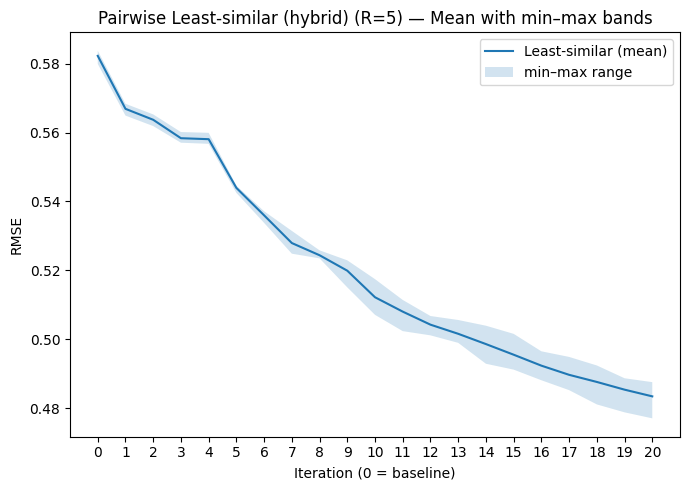

In [12]:
seeds = [101,102,103,104,105]  # R=5
T = 20                           # run iterations per time


#curves_s1 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=1, mode="hybrid")
# curves_s2 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=2, mode="hybrid")
curves_s3 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=3, mode="hybrid")


# plot_mean_with_range_single(curves_s1, title="Pairwise Top-2 (hybrid)", label="Top-2")
# plot_mean_with_range_single(curves_s2, title="Pairwise Most-similar (hybrid)", label="Most-similar")
plot_mean_with_range_single(curves_s3, title="Pairwise Least-similar (hybrid)", label="Least-similar")
